<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

## Inhaltsverzeichnis <a id="0"></a> <br>
1. [Einleitung](#1)
2. [Package- und Datenimport](#2)  
3. [Deskriptive Analyse](#3)  
    3.1 [Datenüberblick](#3.1)   
    3.2 [Datentypen](#3.2)  
    3.3 [Betrachtung der Verteilung](#3.3)   
    3.4 [Analyse der Kategorischen Variablen](#3.4)  
    3.5 [Fehlende Werte](#3.5)   
    3.6 [Ausreißer](#3.6)  
    3.7 [Zeitreihenanalyse](#3.7)   
    3.8 [Korrelationen](#3.8)  
4. [Daten anpassen](#4)  
5. [Geeignete Merkmale](#5)  
6. [Vergleichsmetrik](#6)
7. [ML Verfahren 1](#7)
8. [ML Verfahren 2](#8)
9. [Vergleich](#9)

## 1. Einleitung <a id="1"></a> <br>

Dieses Jupyter Notebook dokumentiert unser Projekt für das Modul Data Mining, in dem wir die Verkaufszahlen der Rossmann-Filialen vorhersagen. Diese Aufgabe basiert auf dem Rossmann Store Sales Datensatz von [Kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), der umfangreiche Verkaufsdaten von über 1000 Filialen enthält. 

## 2. Package- und Datenimport <a id="2"></a> <br>

In [211]:
import calendar
import locale
import zipfile

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date, datetime, timedelta

from matplotlib.pyplot import rcParams
from statsmodels.tsa.stattools import adfuller
%pip install pmdarima -q
import pmdarima as pm

# Machine Learning Verfahren Nummer 2 - Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
# from dask.distributed import Client
import holidays

sns.set_style(style='white') # Hintergrund der Plots

Note: you may need to restart the kernel to use updated packages.


In [212]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

In [213]:
# Maximale Anzahl an Spalten und Zeilen, beim anzeigen von Dataframes
pd.options.display.max_columns = None
pd.options.display.max_rows = 50

## 3. Deskriptive Analyse <a id="3"></a> <br>

### 3.1 Datensatzüberblick <a id="3.1"></a> <br>

Der Rossmann Store Sales-Datensatz enthält historische Verkaufsdaten für 1.115 Rossmann-Filialen. Er besteht aus drei CSV-Dateien:

- train.csv: Historische Daten einschließlich Verkäufe
- test.csv: Historische Daten ohne Verkäufe (für die Vorhersage)
- store.csv: Zusätzliche Informationen über die Filialen

Im ersten Schritt werden die Spalten der Datensätze umbenannt und in Variablen gespeichert.


In [214]:
# Spalten umbennen, damit alles einheitlich auf deutsch ist
train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                                 "DayOfWeek":"Wochentag",
                                                                 "Date":"Datum",
                                                                 "Sales":"Umsatz",
                                                                 "Customers":"Kundenanzahl",
                                                                 "Open":"Geoeffnet",
                                                                 "Promo":"Aktionstag",
                                                                 "StateHoliday":"Feiertag",
                                                                 "SchoolHoliday":"Schulferien"})

test_original = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                                  "Store":"Filiale",
                                                                  "DayOfWeek":"Wochentag",
                                                                  "Date":"Datum",
                                                                  "Open":"Geoeffnet",
                                                                  "Promo":"Aktionstag",
                                                                  "StateHoliday":"Feiertag",
                                                                  "SchoolHoliday":"Schulferien"})

store_original = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                                  "StoreType":"Filialentyp",
                                                                  "Assortment":"Sortiment",
                                                                  "CompetitionDistance":"Wettbewerberentfernung",
                                                                  "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monat",
                                                                  "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahr",
                                                                  "Promo2": "Teilnahme_Langzeitaktion",
                                                                  "Promo2SinceWeek":"Aktion_seit_Woche",
                                                                  "Promo2SinceYear":"Aktion_seit_Jahr",
                                                                  "PromoInterval":"Aktionsmonate"})




# Um in einem späteren Zeitpunkt auf die originalen Datensätze zugreifen zu können, werden diese hier separat gespeichert.
# Außerdem werden die Datensätze _train_original_ und _store_original_ über die Spalte _Filiale_ verbunden und im neuen Datensatz 
# _train_x_store_ gespeichert. Für den Datensatz _test_original_ wird das gleiche Prozedere angewandt.
train = train_original
test = test_original
store = store_original

train_x_store = pd.merge(train, store)
test_x_store = pd.merge(test, store)

C:\Users\AliceKitchkin\AppData\Local\Temp\ipykernel_17952\3191597121.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


| Spalte                        | Umbenennung                           | Beschreibung                                                         |
|-------------------------------|---------------------------------------|----------------------------------------------------------------------|
| `Id`                          | `ID`                                  | Eindeutige ID für jede Filiale und jedes Datumspaar im Testdatensatz.|
| `Store`                       | `Filiale`                             | Eindeutige ID für jede Filiale.|
| `Sales`                       | `Wochentag`                           | Wochentag als Zahl von 1 (Montag) bis 7 (Sonntag) |
| `Date`                        | `Datum`                               | Datum (im "yyyy-mm-dd" Format) |
| `Sales`                       | `Umsatz`                              | Umsatz an einem bestimmten Tag (zu prognostizierendes Ziel).|
| `Customers`                   | `Kundenanzahl`                        | Anzahl der Kunden an einem bestimmten Tag.|
| `Open`                        | `Geoeffnet`                           | Indikator, ob die Filiale geöffnet war (0 = geschlossen, 1 = geöffnet).|
| `Promo`                       | `Aktionstag`                          | Gibt an, ob ein Geschäft an diesem Tag eine Werbeaktion durchführt.|
| `StateHoliday`                | `Feiertag`                            | Feiertagstyp (a = öffentlicher Feiertag, b = Osterfeiertag, c = Weihnachten, 0 = keiner).|
| `SchoolHoliday`               | `Schulferien`                         | Gibt an, ob die Filiale von Schulschließungen betroffen war.|
| `StoreType`                   | `Filialtyp`                           | Unterscheidet zwischen 4 verschiedenen Filialmodellen (a, b, c, d).|
| `Assortment`                  | `Sortiment`                           | Beschreibt das Sortiment (a = grundlegend, b = extra, c = erweitert).|
| `CompetitionDistance`         | `Wettbewerberentfernung`              | Entfernung in Metern zum nächsten Wettbewerbergeschäft.|
| `CompetitionOpenSinceMonth`   | `Wettbewerber_Eroeffnet_seit_Monat`   | Gibt den Monat an, in dem der nächste Wettbewerber eröffnet wurde.|
| `CompetitionOpenSinceYear`    | `Wettbewerber_Eroeffnet_seit_Jahr`    | Gibt das Jahr an, in dem der nächste Wettbewerber eröffnet wurde.|
| `Promo2`                      | `Teilnahme_Langzeitaktion`            | Promo2 ist eine fortlaufende und aufeinanderfolgende Werbeaktion für einige Geschäfte (0 = nein, 1 = ja).|
| `Promo2SinceWeek`             | `Aktion_seit_Woche`                   | Beschreibt die Kalenderwoche, in der das Geschäft an Promo2 teilnimmt.|
| `Promo2SinceYear`             | `Aktion_seit_Jahr`                    | Beschreibt das Jahr, in der das Geschäft an Promo2 teilnimmt.|
| `PromoInterval`               | `Aktionsmonate`                       | Beschreibt die aufeinanderfolgenden Intervalle, in denen Promo2 gestartet wird (z. B. "Feb, Mai, Aug, Nov").|

**Datensätze: Train, Test, Store, Train_x_store**

In [215]:
display(train.head())

Filiale  Wochentag       Datum  Umsatz  Kundenanzahl  Geoeffnet  \
0        1          5  2015-07-31    5263           555          1   
1        2          5  2015-07-31    6064           625          1   
2        3          5  2015-07-31    8314           821          1   
3        4          5  2015-07-31   13995          1498          1   
4        5          5  2015-07-31    4822           559          1   

   Aktionstag Feiertag  Schulferien  
0           1        0            1  
1           1        0            1  
2           1        0            1  
3           1        0            1  
4           1        0            1

In [216]:
display(test.head())

ID  Filiale  Wochentag       Datum  Geoeffnet  Aktionstag Feiertag  \
0   1        1          4  2015-09-17        1.0           1        0   
1   2        3          4  2015-09-17        1.0           1        0   
2   3        7          4  2015-09-17        1.0           1        0   
3   4        8          4  2015-09-17        1.0           1        0   
4   5        9          4  2015-09-17        1.0           1        0   

   Schulferien  
0            0  
1            0  
2            0  
3            0  
4            0

In [217]:
display(store.head())

Filiale Filialentyp Sortiment  Wettbewerberentfernung  \
0        1           c         a                  1270.0   
1        2           a         a                   570.0   
2        3           a         a                 14130.0   
3        4           c         c                   620.0   
4        5           a         a                 29910.0   

   Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
0                                9.0                            2008.0   
1                               11.0                            2007.0   
2                               12.0                            2006.0   
3                                9.0                            2009.0   
4                                4.0                            2015.0   

   Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr  \
0                         0                NaN               NaN   
1                         1               13.0            2010.0   
2                         1               14.0            2011.0   
3                         0                NaN               NaN   
4                         0                NaN               NaN   

     Aktionsmonate  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [218]:
display(train_x_store.head())

Filiale  Wochentag       Datum  Umsatz  Kundenanzahl  Geoeffnet  \
0        1          5  2015-07-31    5263           555          1   
1        1          4  2015-07-30    5020           546          1   
2        1          3  2015-07-29    4782           523          1   
3        1          2  2015-07-28    5011           560          1   
4        1          1  2015-07-27    6102           612          1   

   Aktionstag Feiertag  Schulferien Filialentyp Sortiment  \
0           1        0            1           c         a   
1           1        0            1           c         a   
2           1        0            1           c         a   
3           1        0            1           c         a   
4           1        0            1           c         a   

   Wettbewerberentfernung  Wettbewerber_Eroeffnet_seit_Monat  \
0                  1270.0                                9.0   
1                  1270.0                                9.0   
2                  1270.0                                9.0   
3                  1270.0                                9.0   
4                  1270.0                                9.0   

   Wettbewerber_Eroeffnet_seit_Jahr  Teilnahme_Langzeitaktion  \
0                            2008.0                         0   
1                            2008.0                         0   
2                            2008.0                         0   
3                            2008.0                         0   
4                            2008.0                         0   

   Aktion_seit_Woche  Aktion_seit_Jahr Aktionsmonate  
0                NaN               NaN           NaN  
1                NaN               NaN           NaN  
2                NaN               NaN           NaN  
3                NaN               NaN           NaN  
4                NaN               NaN           NaN

### 3.2 Datentypen <a id="3.2"></a> <br>

In [219]:
# Datentypen vor Korrektur
train_x_store.dtypes

Filiale                                int64
Wochentag                              int64
Datum                                 object
Umsatz                                 int64
Kundenanzahl                           int64
Geoeffnet                              int64
Aktionstag                             int64
Feiertag                              object
Schulferien                            int64
Filialentyp                           object
Sortiment                             object
Wettbewerberentfernung               float64
Wettbewerber_Eroeffnet_seit_Monat    float64
Wettbewerber_Eroeffnet_seit_Jahr     float64
Teilnahme_Langzeitaktion               int64
Aktion_seit_Woche                    float64
Aktion_seit_Jahr                     float64
Aktionsmonate                         object
dtype: object

In [220]:
# Anpassungen Train
train_x_store["Datum"] = pd.to_datetime(train_x_store["Datum"])
train_x_store["Wochentag"] = train_x_store["Datum"].dt.weekday

# Anpassungen Test
test_x_store["Datum"] = pd.to_datetime(test_x_store["Datum"])
test_x_store["Wochentag"] = test_x_store["Datum"].dt.weekday

In [221]:
# Datentypen nach Korrektur
display(train_x_store.dtypes)

display(test_x_store.dtypes)

Filiale                                       int64
Wochentag                                     int32
Datum                                datetime64[ns]
Umsatz                                        int64
Kundenanzahl                                  int64
Geoeffnet                                     int64
Aktionstag                                    int64
Feiertag                                     object
Schulferien                                   int64
Filialentyp                                  object
Sortiment                                    object
Wettbewerberentfernung                      float64
Wettbewerber_Eroeffnet_seit_Monat           float64
Wettbewerber_Eroeffnet_seit_Jahr            float64
Teilnahme_Langzeitaktion                      int64
Aktion_seit_Woche                           float64
Aktion_seit_Jahr                            float64
Aktionsmonate                                object
dtype: object

ID                                            int64
Filiale                                       int64
Wochentag                                     int32
Datum                                datetime64[ns]
Geoeffnet                                   float64
Aktionstag                                    int64
Feiertag                                     object
Schulferien                                   int64
Filialentyp                                  object
Sortiment                                    object
Wettbewerberentfernung                      float64
Wettbewerber_Eroeffnet_seit_Monat           float64
Wettbewerber_Eroeffnet_seit_Jahr            float64
Teilnahme_Langzeitaktion                      int64
Aktion_seit_Woche                           float64
Aktion_seit_Jahr                            float64
Aktionsmonate                                object
dtype: object

### 3.3 Neue Spalten <a id="3.2"></a> <br>

Nach der Datentypenkorrektur werden folgende neuen Spalten aus den bereits existierenden hinzugefügt:
| Originale Spalte              | Neue Spalte                           | Beschreibung                                                              |
|-------------------------------|---------------------------------------|---------------------------------------------------------------------------|
| `Datum`                       | `Tag`                                 | Gibt den Tag aus der ursprünglichen Spalte Datum an (von 1 bis 31).       |
| `Datum`                       | `Monat`                               | Gibt den Monat aus der ursprünglichen Spalte Datum an (von 1 bis 12).     |
| `Datum`                       | `Jahr`                                | Gibt das Jahr aus der ursprünglichen Spalte Datum an.             	    |
| `Datum`                       | `Quartal`                             | Gibt das Quartal aus der ursprünglichen Spalte Datum an (von 1 bis 4).    |
| `Umsatz und Kundenanzahl`     | `UmsatzProKunde`                      | Gibt prozentual den Umsatz je Kunde pro Tag an.                           |

In [222]:
neue_spalten = {
    "Tag": train_x_store["Datum"].dt.day,
    "Monat": train_x_store["Datum"].dt.month,
    "Jahr": train_x_store["Datum"].dt.year,
    "Quartal": train_x_store["Datum"].dt.quarter
}

# Dataframe teilen, um die neuen Spalten in gewünschter Reihenfolge einzufügen
train_x_store_before = train_x_store.iloc[:, :1]
train_x_store_after = train_x_store.iloc[:, 1:]

# Alten Dataframe mit den neuen Spalten zusammenführen
train_x_store = pd.concat([train_x_store_before, pd.DataFrame(neue_spalten), train_x_store_after], axis=1)

display(train_x_store)

Filiale  Tag  Monat  Jahr  Quartal  Wochentag      Datum  Umsatz  \
0              1   31      7  2015        3          4 2015-07-31    5263   
1              1   30      7  2015        3          3 2015-07-30    5020   
2              1   29      7  2015        3          2 2015-07-29    4782   
3              1   28      7  2015        3          1 2015-07-28    5011   
4              1   27      7  2015        3          0 2015-07-27    6102   
...          ...  ...    ...   ...      ...        ...        ...     ...   
1017204     1115    5      1  2013        1          5 2013-01-05    4771   
1017205     1115    4      1  2013        1          4 2013-01-04    4540   
1017206     1115    3      1  2013        1          3 2013-01-03    4297   
1017207     1115    2      1  2013        1          2 2013-01-02    3697   
1017208     1115    1      1  2013        1          1 2013-01-01       0   

         Kundenanzahl  Geoeffnet  Aktionstag Feiertag  Schulferien  \
0                 555          1           1        0            1   
1                 546          1           1        0            1   
2                 523          1           1        0            1   
3                 560          1           1        0            1   
4                 612          1           1        0            1   
...               ...        ...         ...      ...          ...   
1017204           339          1           0        0            1   
1017205           326          1           0        0            1   
1017206           300          1           0        0            1   
1017207           305          1           0        0            1   
1017208             0          0           0        a            1   

        Filialentyp Sortiment  Wettbewerberentfernung  \
0                 c         a                  1270.0   
1                 c         a                  1270.0   
2                 c         a                  1270.0   
3                 c         a                  1270.0   
4                 c         a                  1270.0   
...             ...       ...                     ...   
1017204           d         c                  5350.0   
1017205           d         c                  5350.0   
1017206           d         c                  5350.0   
1017207           d         c                  5350.0   
1017208           d         c                  5350.0   

         Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
0                                      9.0                            2008.0   
1                                      9.0                            2008.0   
2                                      9.0                            2008.0   
3                                      9.0                            2008.0   
4                                      9.0                            2008.0   
...                                    ...                               ...   
1017204                                NaN                               NaN   
1017205                                NaN                               NaN   
1017206                                NaN                               NaN   
1017207                                NaN                               NaN   
1017208                                NaN                               NaN   

         Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr  \
0                               0                NaN               NaN   
1                               0                NaN               NaN   
2                               0                NaN               NaN   
3                               0                NaN               NaN   
4                               0                NaN               NaN   
...                           ...                ...               ...   
1017204                         1               22.0            2012.0   
10172

In [223]:
neue_spalten = { "UmsatzProKunde":  train['Umsatz']/train['Kundenanzahl'] }

# Dataframe teilen, um die neuen Spalten in gewünschter Reihenfolge einzufügen
train_x_store_before = train_x_store.iloc[:, :9]
train_x_store_after = train_x_store.iloc[:, 9:]

# Alten Dataframe mit den neuen Spalten zusammenführen
train_x_store = pd.concat([train_x_store_before, pd.DataFrame(neue_spalten), train_x_store_after], axis=1)

display(train_x_store)

Filiale  Tag  Monat  Jahr  Quartal  Wochentag      Datum  Umsatz  \
0              1   31      7  2015        3          4 2015-07-31    5263   
1              1   30      7  2015        3          3 2015-07-30    5020   
2              1   29      7  2015        3          2 2015-07-29    4782   
3              1   28      7  2015        3          1 2015-07-28    5011   
4              1   27      7  2015        3          0 2015-07-27    6102   
...          ...  ...    ...   ...      ...        ...        ...     ...   
1017204     1115    5      1  2013        1          5 2013-01-05    4771   
1017205     1115    4      1  2013        1          4 2013-01-04    4540   
1017206     1115    3      1  2013        1          3 2013-01-03    4297   
1017207     1115    2      1  2013        1          2 2013-01-02    3697   
1017208     1115    1      1  2013        1          1 2013-01-01       0   

         Kundenanzahl  UmsatzProKunde  Geoeffnet  Aktionstag Feiertag  \
0                 555        9.482883          1           1        0   
1                 546        9.702400          1           1        0   
2                 523       10.126675          1           1        0   
3                 560        9.342457          1           1        0   
4                 612        8.626118          1           1        0   
...               ...             ...        ...         ...      ...   
1017204           339             NaN          1           0        0   
1017205           326             NaN          1           0        0   
1017206           300             NaN          1           0        0   
1017207           305             NaN          1           0        0   
1017208             0             NaN          0           0        a   

         Schulferien Filialentyp Sortiment  Wettbewerberentfernung  \
0                  1           c         a                  1270.0   
1                  1           c         a                  1270.0   
2                  1           c         a                  1270.0   
3                  1           c         a                  1270.0   
4                  1           c         a                  1270.0   
...              ...         ...       ...                     ...   
1017204            1           d         c                  5350.0   
1017205            1           d         c                  5350.0   
1017206            1           d         c                  5350.0   
1017207            1           d         c                  5350.0   
1017208            1           d         c                  5350.0   

         Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
0                                      9.0                            2008.0   
1                                      9.0                            2008.0   
2                                      9.0                            2008.0   
3                                      9.0                            2008.0   
4                                      9.0                            2008.0   
...                                    ...                               ...   
1017204                                NaN                               NaN   
1017205                                NaN                               NaN   
1017206                                NaN                               NaN   
1017207                                NaN                               NaN   
1017208                                NaN                               NaN   

         Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr  \
0                               0                NaN               NaN   
1                               0                NaN               NaN   
2                               0                NaN               NaN   
3                               0                NaN               NaN   
4                               0  

### 3.4 Betrachtung der Verteilung <a id="3.3"></a> <br>

Es werden die statistischen Kennzahlen für den train_x_store-Datensatz berechnet, auf drei Dezimalstellen gerundet und die Datentypen angezeigt.

In [224]:
describe = round(train_x_store.describe(include='all'), 3)
dtypes = pd.DataFrame(train_x_store.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

Filiale        Tag      Monat       Jahr    Quartal  Wochentag  \
dtypes      int64      int32      int32      int32      int32      int32   
count   1017209.0  1017209.0  1017209.0  1017209.0  1017209.0  1017209.0   
unique        NaN        NaN        NaN        NaN        NaN        NaN   
top           NaN        NaN        NaN        NaN        NaN        NaN   
freq          NaN        NaN        NaN        NaN        NaN        NaN   
mean       558.43     15.703      5.847   2013.832      2.294      2.998   
min           1.0        1.0        1.0     2013.0        1.0        0.0   
25%         280.0        8.0        3.0     2013.0        1.0        1.0   
50%         558.0       16.0        6.0     2014.0        2.0        3.0   
75%         838.0       23.0        8.0     2014.0        3.0        5.0   
max        1115.0       31.0       12.0     2015.0        4.0        6.0   
std       321.909      8.788      3.326      0.777      1.082      1.997   

                                Datum     Umsatz Kundenanzahl UmsatzProKunde  \
dtypes                 datetime64[ns]      int64        int64        float64   
count                         1017209  1017209.0    1017209.0       844340.0   
unique                            NaN        NaN          NaN            NaN   
top                               NaN        NaN          NaN            NaN   
freq                              NaN        NaN          NaN            NaN   
mean    2014-04-11 01:30:42.846061824   5773.819      633.146          9.494   
min               2013-01-01 00:00:00        0.0          0.0            0.0   
25%               2013-08-17 00:00:00     3727.0        405.0          7.896   
50%               2014-04-02 00:00:00     5744.0        609.0           9.25   
75%               2014-12-12 00:00:00     7856.0        837.0           10.9   
max               2015-07-31 00:00:00    41551.0       7388.0         64.958   
std                               NaN   3849.926      464.412          2.197   

        Geoeffnet Aktionstag Feiertag Schulferien Filialentyp Sortiment  \
dtypes      int64      int64   object       int64      object    object   
count   1017209.0  1017209.0  1017209   1017209.0     1017209   1017209   
unique        NaN        NaN        5         NaN           4         3   
top           NaN        NaN        0         NaN           a         a   
freq          NaN        NaN   855087         NaN      551627    537445   
mean         0.83      0.382      NaN       0.179         NaN       NaN   
min           0.0        0.0      NaN         0.0         NaN       NaN   
25%           1.0        0.0      NaN         0.0         NaN       NaN   
50%           1.0        0.0      NaN         0.0         NaN       NaN   
75%           1.0        1.0      NaN         0.0         NaN       NaN   
max           1.0        1.0      NaN         1.0         NaN       NaN   
std         0.376      0.486      NaN       0.383         NaN       NaN   

       Wettbewerberentfernung Wettbewerber_Eroeffnet_seit_Monat  \
dtypes                float64                           float64   
count               1014567.0                          693861.0   
unique                    NaN                               NaN   
top                       NaN                               NaN   
freq                      NaN                               NaN   
mean                 5430.086                             7.223   
min                      20.0                               1.0   
25%                     710.0                               4.0   
50%                    2330.0                               8.0   
75%                    6890.0                              10.0   
max                   75860.0                              12.0   
std                  7715.324                             3.212   

       Wettbewerber_Eroeffnet_seit_Jahr Teilnahme_Langzeitaktion  \
dtypes                          float64                    int64

### 3.5 Analyse der kategorischen Variablen <a id="3.4"></a> <br>



##### Betrachtung der Filialtypen und der Verteilung der Filialen auf diese Typen

In [225]:
df_filialentyp = pd.DataFrame(data = store["Filialentyp"].value_counts()).rename(columns= {"count": "Anzahl"})
df_filialentyp["Anteil"] = round(df_filialentyp["Anzahl"] / df_filialentyp["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
df_filialentyp.sort_index(inplace = True)
display(df_filialentyp)

Anzahl  Anteil
Filialentyp                
a               602  53.99%
b                17   1.52%
c               148  13.27%
d               348  31.21%

Verteilung der Kundenzahlen und Umsätze auf die Filialtypen

In [226]:
df_filialentyp_x = train_x_store.groupby('Filialentyp')[['Kundenanzahl', 'Umsatz']].sum()

df_filialentyp_x = pd.merge(df_filialentyp, df_filialentyp_x, on ="Filialentyp")

df_filialentyp_x["Kundenzahl_pro_Filiale"] = round(df_filialentyp_x["Kundenanzahl"] / df_filialentyp_x["Anzahl"], 0).astype(int)
df_filialentyp_x["Umsatz_pro_Filiale"] = round(df_filialentyp_x["Umsatz"] / df_filialentyp_x["Anzahl"], 0).astype(int)

# Reihenfolge der Spalten ändern
df_filialentyp_x = df_filialentyp_x[["Anzahl", "Anteil", "Kundenanzahl", "Kundenzahl_pro_Filiale", "Umsatz", "Umsatz_pro_Filiale"]]

display(df_filialentyp_x)

Anzahl  Anteil  Kundenanzahl  Kundenzahl_pro_Filiale      Umsatz  \
Filialentyp                                                                     
a               602  53.99%     363541434                  603889  3165334859   
b                17   1.52%      31465621                 1850919   159231395   
c               148  13.27%      92129705                  622498   783221426   
d               348  31.21%     156904995                  450876  1765392943   

             Umsatz_pro_Filiale  
Filialentyp                      
a                       5258031  
b                       9366553  
c                       5292037  
d                       5072968

##### Betrachtung der Sortimente und der Verteilung der Sortimente auf die Filialen

In [227]:
df_sortimenttyp = pd.DataFrame(data = store["Sortiment"].value_counts()).rename(columns= {"count": "Anzahl"})
df_sortimenttyp["Anteil"] = round(df_sortimenttyp["Anzahl"] / df_sortimenttyp["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
df_sortimenttyp.sort_index(inplace = True)
display(df_sortimenttyp)

Anzahl  Anteil
Sortiment                
a             593  53.18%
b               9   0.81%
c             513  46.01%

##### Betrachtung der Sortimente und der Verteilung der Sortimente auf die Filialen unter Berücksichtigung der Filialtypen

In [228]:
df_filialentyp_x_sortimenttyp = pd.DataFrame(data = store[["Filialentyp", "Sortiment"]].value_counts()).rename(columns= {"count": "Anzahl"})

df_filialentyp_x_sortimenttyp["Gruppenanteil"] = round(df_filialentyp_x_sortimenttyp["Anzahl"] / df_filialentyp_x_sortimenttyp.groupby(level = "Filialentyp")["Anzahl"].transform("sum") * 100, 2).apply(lambda x: f"{x}%")
df_filialentyp_x_sortimenttyp["Gesamtanteil"] = round(df_filialentyp_x_sortimenttyp["Anzahl"] / df_filialentyp_x_sortimenttyp["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
df_filialentyp_x_sortimenttyp.sort_index(inplace = True)
display(df_filialentyp_x_sortimenttyp)

Anzahl Gruppenanteil Gesamtanteil
Filialentyp Sortiment                                   
a           a             381        63.29%       34.17%
            c             221        36.71%       19.82%
b           a               7        41.18%        0.63%
            b               9        52.94%        0.81%
            c               1         5.88%        0.09%
c           a              77        52.03%        6.91%
            c              71        47.97%        6.37%
d           a             128        36.78%       11.48%
            c             220        63.22%       19.73%

Von den Filialen des Typs a haben 381 das Sortiment a, damit haben 63,29% der Filialen des Typs a das Sortiment a, was 34,17% aller Filialtyps und Sortimentskombinationen ausmacht.

##### Betrachtung der Angabe Feiertag (Häufigkeit der einzelnen Ausprägungen)

In [229]:
df_feiertag = pd.DataFrame(data= train_x_store["Feiertag"].value_counts()).rename(columns= {"count": "Anzahl"})
display(df_feiertag)

Anzahl
Feiertag        
0         855087
0         131072
a          20260
b           6690
c           4100

Aus irgendeinem Grund taucht die 0 (kein Feiertag) zwei mal als Ausprägungstyp auf, daher untersuchen wir den Datentyp.

In [230]:
for index in df_feiertag.index:
    print(f"{index}: {type(index)}")

0: <class 'str'>
0: <class 'int'>
a: <class 'str'>
b: <class 'str'>
c: <class 'str'>


Die Kategorie 0 (kein Feiertag) ist einmal als str und einmal als int codiert. Das passen wir im folgenden an.

In [231]:
train_x_store["Feiertag"] = train_x_store["Feiertag"].astype(str)

df_feiertag = pd.DataFrame(data= train_x_store["Feiertag"].value_counts()).rename(columns= {"count": "Anzahl"})
display(df_feiertag)

for index in df_feiertag.index:
    print(f"{index}: {type(index)}")

Anzahl
Feiertag        
0         986159
a          20260
b           6690
c           4100

0: <class 'str'>
a: <class 'str'>
b: <class 'str'>
c: <class 'str'>


In [232]:
df_feiertag["Anteil"] = round(df_feiertag["Anzahl"] / df_feiertag["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
display(df_feiertag)

Anzahl  Anteil
Feiertag                
0         986159  96.95%
a          20260   1.99%
b           6690   0.66%
c           4100    0.4%

97% der Datenpunkte haben für das Merkmal Feiertag die Ausprägung 0 (kein Feiertag). Damit machen die Feiertage rund 3% der in den Daten enthaltenen Tage aus. Das entspricht dem Erwartungswert, da in Deutschland die Zahl der gesetzlichen Feiertage, je nach Bundesland zwischen 10 und 12 liegt (pro Jahr) --> [11 / 365 = 0,03]

##### Geöffnet

In [233]:
df_geoeffnet = pd.DataFrame(data= train_x_store["Geoeffnet"].value_counts()).rename(columns= {"count": "Anzahl"})
df_geoeffnet["Anteil"] = round(df_geoeffnet["Anzahl"] / df_geoeffnet["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
display(df_geoeffnet)

Anzahl  Anteil
Geoeffnet                
1          844392  83.01%
0          172817  16.99%

Von den Datenpunkten im Datensatz train_x_store haben 83% die Ausprägung "Geöffnet" = 1 und 17% die Ausprägung "Geoeffnet" = 0.

In Ferien oder an Feiertagen geöffnet

In [234]:
df_geoeffnet = pd.DataFrame(data= train_x_store[["Schulferien", "Feiertag", "Geoeffnet"]].value_counts()).rename(columns= {"count": "Anzahl"})
df_geoeffnet["Anteil"] = round(df_geoeffnet["Anzahl"] / df_geoeffnet["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
display(df_geoeffnet)

Anzahl  Anteil
Schulferien Feiertag Geoeffnet                
0           0        1          680339  66.88%
1           0        1          163143  16.04%
0           0        0          139610  13.72%
            a        0           14465   1.42%
1           b        0            6067    0.6%
            a        0            5101    0.5%
            c        0            4029    0.4%
            0        0            3067    0.3%
0           a        1             590   0.06%
            b        0             478   0.05%
1           b        1             139   0.01%
            a        1             104   0.01%
            c        1              71   0.01%
0           b        1               6    0.0%

66,88% der Datenpunkte im Datensatz train_x_store besitzen die Ausprägungskombination (Geoffnet, keine Ferien, kein Feiertag)

##### Schulferien und Feiertag

In [235]:
df_ferien_x_feiertag = pd.DataFrame(data= train_x_store[["Schulferien", "Feiertag"]].value_counts()).rename(columns= {"count": "Anzahl"})
df_ferien_x_feiertag["Anteil"] = round(df_ferien_x_feiertag["Anzahl"] / df_ferien_x_feiertag["Anzahl"].sum() * 100, 2).apply(lambda x: f"{x}%")
display(df_ferien_x_feiertag)

Anzahl  Anteil
Schulferien Feiertag                
0           0         819949  80.61%
1           0         166210  16.34%
0           a          15055   1.48%
1           b           6206   0.61%
            a           5205   0.51%
            c           4100    0.4%
0           b            484   0.05%

### 3.6 Fehlende Werte<a id="3.5"></a> <br>

Überblick über den zeitlichen Verlauf (liegen für jeden Tag Angaben vor)

In [236]:
# Anzahl Tage im Datensatz
number_of_days = len(pd.unique(train_x_store["Datum"]))

# Anzahl an Tagen zwischen der ersten und letzten Datumsangabe
first_day= train_x_store["Datum"].min()
last_day = train_x_store["Datum"].max()
expected_number_of_days = (last_day - first_day).days + 1

print(f"Anzahl an Tagen im Datensatz: {number_of_days}\n"
      + f"Differenz zwischen kleinster und größter Datumsangabe (in Tagen): {expected_number_of_days-1}\n"
      + f"Erwarte Anzahl an Tagen im Datensatz: {expected_number_of_days}")

Anzahl an Tagen im Datensatz: 942
Differenz zwischen kleinster und größter Datumsangabe (in Tagen): 941
Erwarte Anzahl an Tagen im Datensatz: 942


Die Anzahl der Tage für den Datenpunkte im Datensatz vorhanden sind deckt sich mit der Zeitspanne zwischen der ersten und letzten Datumsangabe im Datensatz. Es gibt also keinen Tag an dem uns alle Werte fehlen.

Überischt über die Filialen:
- liegen im Datensatz für alle Filialen und für jeden Tag Werte vor?

In [237]:
# Anzahl an Filian
number_of_stores = len(pd.unique(train_x_store["Filiale"]))

stores_with_missing_data = train_x_store["Filiale"].value_counts()
stores_with_missing_data = stores_with_missing_data[stores_with_missing_data != number_of_days]

number_of_stores_with_missing_data = len(stores_with_missing_data)

print(f"Anzahl Filialen bei denen Daten fehlen: {number_of_stores_with_missing_data}")

Anzahl Filialen bei denen Daten fehlen: 181


Für insgesamt 181 Filialen sind die Daten unvollständig. Der Grund dafür könnte sein, dass die Filialen im Laufe des betrachteten Zeitraus eröffnet oder geschlossen haben. Dafür betrachten wir im folgenden den zeitlichen Verlauf.

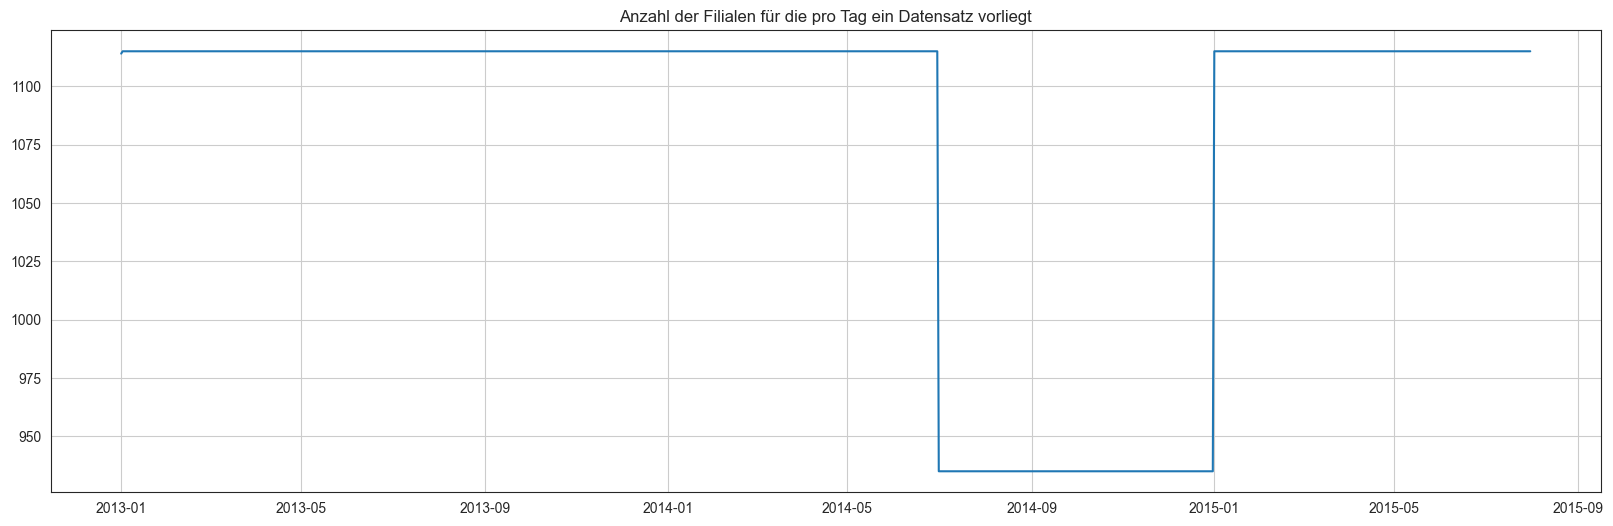

In [238]:
train_x_store_gp_date = train_x_store.groupby("Datum")

number_of_stores_by_date = {}

for date, df in train_x_store_gp_date:
    number_of_stores_by_date[date] = len(pd.unique(df["Filiale"]))
 
df_number_of_stores_by_date = pd.DataFrame.from_dict(number_of_stores_by_date, orient = "index", columns= ["Number_of_Stores"])

fig, ax = plt.subplots(figsize= (20,6))

ax.set_title("Anzahl der Filialen für die pro Tag ein Datensatz vorliegt")
ax.plot(df_number_of_stores_by_date.index, df_number_of_stores_by_date["Number_of_Stores"])
ax.grid()
plt.show()

Über einen Zeitraum von ca. 6 Monaten fehlen die Daten für 181 Filialen. Da der Zeitraum für den dieses Datenpunkte fehlen, innerhalb des Betrachtungshorzionts und nicht etwa am Rande liegen, ist die Theorie der Neueröffnung oder dauerhaften Schließung hinfällig.

Aber wie viele Daten fehlen insgesamt?

In [239]:
number_of_datapoints = len(train_x_store)
expected_number_of_datapoint = number_of_stores * number_of_days

number_of_missing_datapoints = expected_number_of_datapoint - number_of_datapoints

number_of_datapoints, expected_number_of_datapoint, number_of_missing_datapoints
print(f"Anzahl erhaltener Datenpunkte: {number_of_datapoints}\n"
      + f"Anzahl erwarteter Datenpunkte: {expected_number_of_datapoint-1}\n"
      + f"Anzahl fehlender Datenpunkte: {number_of_missing_datapoints} ({round(number_of_missing_datapoints / expected_number_of_datapoint * 100, 2)}%)")

Anzahl erhaltener Datenpunkte: 1017209
Anzahl erwarteter Datenpunkte: 1050329
Anzahl fehlender Datenpunkte: 33121 (3.15%)


Insgesamt fehlen 33121 Datenpunkte.

In [240]:
# Fehlende Werte in Train_x_store
missing_data_abs = train_x_store.isnull().sum()
missing_data_per = ( round(train_x_store.isnull().sum()/train_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

Fehlende Werte (absolut)  \
Filiale                                                   0   
Tag                                                       0   
Monat                                                     0   
Jahr                                                      0   
Quartal                                                   0   
Wochentag                                                 0   
Datum                                                     0   
Umsatz                                                    0   
Kundenanzahl                                              0   
UmsatzProKunde                                       172869   
Geoeffnet                                                 0   
Aktionstag                                                0   
Feiertag                                                  0   
Schulferien                                               0   
Filialentyp                                               0   
Sortiment                                                 0   
Wettbewerberentfernung                                 2642   
Wettbewerber_Eroeffnet_seit_Monat                    323348   
Wettbewerber_Eroeffnet_seit_Jahr                     323348   
Teilnahme_Langzeitaktion                                  0   
Aktion_seit_Woche                                    508031   
Aktion_seit_Jahr                                     508031   
Aktionsmonate                                        508031   

                                  Fehlende Werte (prozentual)  
Filiale                                                  0.0%  
Tag                                                      0.0%  
Monat                                                    0.0%  
Jahr                                                     0.0%  
Quartal                                                  0.0%  
Wochentag                                                0.0%  
Datum                                                    0.0%  
Umsatz                                                   0.0%  
Kundenanzahl                                             0.0%  
UmsatzProKunde                                         16.99%  
Geoeffnet                                                0.0%  
Aktionstag                                               0.0%  
Feiertag                                                 0.0%  
Schulferien                                              0.0%  
Filialentyp                                              0.0%  
Sortiment                                                0.0%  
Wettbewerberentfernung                                  0.26%  
Wettbewerber_Eroeffnet_seit_Monat                      31.79%  
Wettbewerber_Eroeffnet_seit_Jahr                       31.79%  
Teilnahme_Langzeitaktion                                 0.0%  
Aktion_seit_Woche                                      49.94%  
Aktion_seit_Jahr                                       49.94%  
Aktionsmonate                                          49.94%

#### Fehlende Werte im Train-Store-Datensatz

##### Spalte: Wettbewerberentfernung

Im Datensatz gibt es einige Spalten mit fehlenden Werten, welche wir uns nach und nach ansehen werden. Wir beginnen mit der Spalte _Wettbewerberentfernung_, worin 2.642 NaN-Werte gefunden wurden.

In [241]:
train_x_store[pd.isnull(train_x_store.Wettbewerberentfernung)].head()

Filiale  Tag  Monat  Jahr  Quartal  Wochentag      Datum  Umsatz  \
263244      291   31      7  2015        3          4 2015-07-31   10052   
263245      291   30      7  2015        3          3 2015-07-30    9030   
263246      291   29      7  2015        3          2 2015-07-29    8204   
263247      291   28      7  2015        3          1 2015-07-28   10374   
263248      291   27      7  2015        3          0 2015-07-27   11692   

        Kundenanzahl  UmsatzProKunde  Geoeffnet  Aktionstag Feiertag  \
263244           973       11.773071          1           1        0   
263245           883        9.157383          1           1        0   
263246           814       12.917234          1           1        0   
263247           943        8.928367          1           1        0   
263248          1086       10.203103          1           1        0   

        Schulferien Filialentyp Sortiment  Wettbewerberentfernung  \
263244            1           d         a                     NaN   
263245            1           d         a                     NaN   
263246            1           d         a                     NaN   
263247            1           d         a                     NaN   
263248            1           d         a                     NaN   

        Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
263244                                NaN                               NaN   
263245                                NaN                               NaN   
263246                                NaN                               NaN   
263247                                NaN                               NaN   
263248                                NaN                               NaN   

        Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr  \
263244                         0                NaN               NaN   
263245                         0                NaN               NaN   
263246                         0                NaN               NaN   
263247                         0                NaN               NaN   
263248                         0                NaN               NaN   

       Aktionsmonate  
263244           NaN  
263245           NaN  
263246           NaN  
263247           NaN  
263248           NaN

In [242]:
describe = pd.DataFrame(round(train_x_store["Wettbewerberentfernung"].describe(), 3))
display(describe)

Wettbewerberentfernung
count             1014567.000
mean                 5430.086
std                  7715.324
min                    20.000
25%                   710.000
50%                  2330.000
75%                  6890.000
max                 75860.000

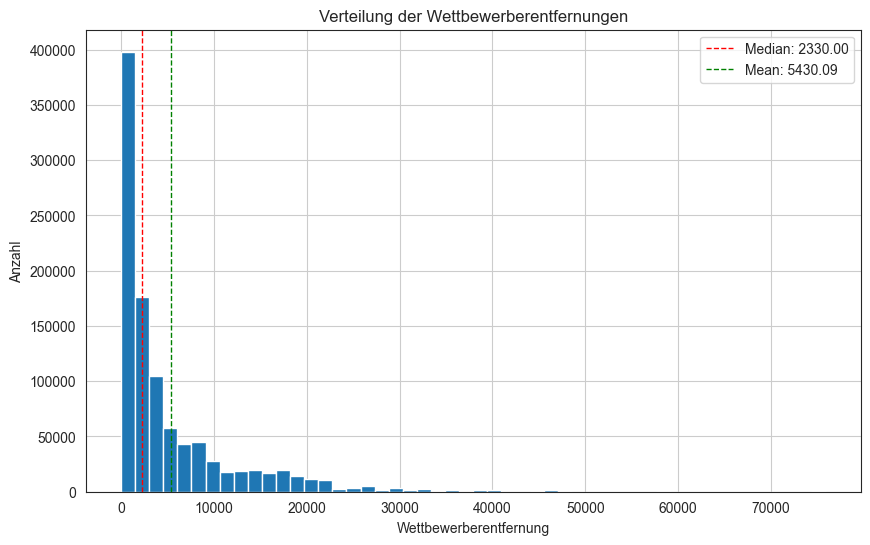

In [243]:
plt.figure(figsize=(10, 6))
plt.hist(train_x_store["Wettbewerberentfernung"], bins=50, edgecolor='white')
plt.title('Verteilung der Wettbewerberentfernungen')
plt.xlabel('Wettbewerberentfernung')
plt.ylabel('Anzahl')

median = train_x_store["Wettbewerberentfernung"].median()
mean = train_x_store["Wettbewerberentfernung"].mean()

plt.axvline(median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.2f}')
plt.axvline(mean, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')

plt.legend()
plt.grid(True)

Wir nehmen  an, dass die Daten einfach nicht vorhanden sind und ersetzen daher die fehlenden Werte in _Wettbewerberentfernung_ mit dem Median.
Warum Median?
-  Robustheit gegenüber Ausreißern: Der Median ist weniger anfällig für Ausreißer im Vergleich zum arithmetischen Mittelwert
- Verteilung der Daten: Wenn die Verteilung der Daten nicht symmetrisch ist oder nicht normal verteilt ist, kann der Median oft die zentrale Tendenz der Daten besser widerspiegeln als der Mittelwert. Dies ist häufig der Fall bei Daten, die rechtsschief oder linksschief verteilt sind.
- Der Median ist ein besserer Indikator für die zentrale Tendenz der Daten, insbesondere wenn man bedenkt, dass die Standardabweichung (7.706,913) relativ hoch ist. Dies deutet darauf hin, dass die Daten möglicherweise eine gewisse Varianz oder Ausreißer aufweisen könnten, die den Mittelwert verzerren würden.

In [244]:
train_x_store["Wettbewerberentfernung"].fillna(train_x_store["Wettbewerberentfernung"].median(), inplace=True)

##### Spalten: _Wettbewerber_Eroeffnet_seit_Monat_, _Wettbewerber_Eroeffnet_seit_Jahr_

In [245]:
display(train_x_store[(train_x_store.Wettbewerberentfernung>0) & (pd.isnull(train_x_store.Wettbewerber_Eroeffnet_seit_Monat))].head())
display(train_x_store[(train_x_store.Wettbewerberentfernung>0) & (pd.isnull(train_x_store.Wettbewerber_Eroeffnet_seit_Jahr))].head())

Filiale  Tag  Monat  Jahr  Quartal  Wochentag      Datum  Umsatz  \
10362       12   31      7  2015        3          4 2015-07-31    8959   
10363       12   30      7  2015        3          3 2015-07-30    7996   
10364       12   29      7  2015        3          2 2015-07-29    9236   
10365       12   28      7  2015        3          1 2015-07-28    8822   
10366       12   27      7  2015        3          0 2015-07-27   10227   

       Kundenanzahl  UmsatzProKunde  Geoeffnet  Aktionstag Feiertag  \
10362           962        8.066532          1           1        0   
10363           835        9.504798          1           1        0   
10364           989        8.717868          1           1        0   
10365           861        6.530303          1           1        0   
10366           979        7.355294          1           1        0   

       Schulferien Filialentyp Sortiment  Wettbewerberentfernung  \
10362            1           a         c                  1070.0   
10363            1           a         c                  1070.0   
10364            1           a         c                  1070.0   
10365            1           a         c                  1070.0   
10366            1           a         c                  1070.0   

       Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
10362                                NaN                               NaN   
10363                                NaN                               NaN   
10364                                NaN                               NaN   
10365                                NaN                               NaN   
10366                                NaN                               NaN   

       Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr  \
10362                         1               13.0            2010.0   
10363                         1               13.0            2010.0   
10364                         1               13.0            2010.0   
10365                         1               13.0            2010.0   
10366                         1               13.0            2010.0   

         Aktionsmonate  
10362  Jan,Apr,Jul,Oct  
10363  Jan,Apr,Jul,Oct  
10364  Jan,Apr,Jul,Oct  
10365  Jan,Apr,Jul,Oct  
10366  Jan,Apr,Jul,Oct

Filiale  Tag  Monat  Jahr  Quartal  Wochentag      Datum  Umsatz  \
10362       12   31      7  2015        3          4 2015-07-31    8959   
10363       12   30      7  2015        3          3 2015-07-30    7996   
10364       12   29      7  2015        3          2 2015-07-29    9236   
10365       12   28      7  2015        3          1 2015-07-28    8822   
10366       12   27      7  2015        3          0 2015-07-27   10227   

       Kundenanzahl  UmsatzProKunde  Geoeffnet  Aktionstag Feiertag  \
10362           962        8.066532          1           1        0   
10363           835        9.504798          1           1        0   
10364           989        8.717868          1           1        0   
10365           861        6.530303          1           1        0   
10366           979        7.355294          1           1        0   

       Schulferien Filialentyp Sortiment  Wettbewerberentfernung  \
10362            1           a         c                  1070.0   
10363            1           a         c                  1070.0   
10364            1           a         c                  1070.0   
10365            1           a         c                  1070.0   
10366            1           a         c                  1070.0   

       Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
10362                                NaN                               NaN   
10363                                NaN                               NaN   
10364                                NaN                               NaN   
10365                                NaN                               NaN   
10366                                NaN                               NaN   

       Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr  \
10362                         1               13.0            2010.0   
10363                         1               13.0            2010.0   
10364                         1               13.0            2010.0   
10365                         1               13.0            2010.0   
10366                         1               13.0            2010.0   

         Aktionsmonate  
10362  Jan,Apr,Jul,Oct  
10363  Jan,Apr,Jul,Oct  
10364  Jan,Apr,Jul,Oct  
10365  Jan,Apr,Jul,Oct  
10366  Jan,Apr,Jul,Oct

Da zwischen den Spalten Wettbewerberentfernung, _Wettbewerber_Eroeffnet_seit_Monat_ und _Wettbewerber_Eroeffnet_seit_Jahr_ kaum eine Korrelation (Korrelationskoeffizienten liegen nah um 0 herum) besteht und die Anzahl an fehlenden Werten (32%) zu groß ist um sie zu entfernen, werden die fehlenden Werte durch den jewieligen Median ersetzt.

In [246]:
median_W_Eroeffnet_seit_Monat = train_x_store['Wettbewerber_Eroeffnet_seit_Monat'].median()
median_W_Eroeffnet_seit_Jahr = train_x_store['Wettbewerber_Eroeffnet_seit_Jahr'].median()

train_x_store['Wettbewerber_Eroeffnet_seit_Monat'].fillna(median_W_Eroeffnet_seit_Monat, inplace=True)
train_x_store['Wettbewerber_Eroeffnet_seit_Jahr'].fillna(median_W_Eroeffnet_seit_Jahr, inplace=True)

##### Spalten: _Teilnahme_Langzeitaktion_, _Aktion_seit_Woche_, _Aktion_seit_Jahr_, _Aktionsmonate_

Als nächstes sehen wir uns die Spalten _Teilnahme_Langzeitaktion_, _Aktion_seit_Woche_ und _Aktion_seit_Jahr_ an. Sofern eine Filiale an einer Langzeitaktion teilnimmt, sollten auch Monat und Jahr nicht fehlen. Da dies der Fall ist, können wir die fehlenden Werte durch Null ersetzen.

In [247]:
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktion_seit_Woche))])
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktion_seit_Jahr))])
display(train_x_store[(train_x_store.Teilnahme_Langzeitaktion==1) & (pd.isnull(train_x_store.Aktionsmonate))])

Empty DataFrame
Columns: [Filiale, Tag, Monat, Jahr, Quartal, Wochentag, Datum, Umsatz, Kundenanzahl, UmsatzProKunde, Geoeffnet, Aktionstag, Feiertag, Schulferien, Filialentyp, Sortiment, Wettbewerberentfernung, Wettbewerber_Eroeffnet_seit_Monat, Wettbewerber_Eroeffnet_seit_Jahr, Teilnahme_Langzeitaktion, Aktion_seit_Woche, Aktion_seit_Jahr, Aktionsmonate]
Index: []

Empty DataFrame
Columns: [Filiale, Tag, Monat, Jahr, Quartal, Wochentag, Datum, Umsatz, Kundenanzahl, UmsatzProKunde, Geoeffnet, Aktionstag, Feiertag, Schulferien, Filialentyp, Sortiment, Wettbewerberentfernung, Wettbewerber_Eroeffnet_seit_Monat, Wettbewerber_Eroeffnet_seit_Jahr, Teilnahme_Langzeitaktion, Aktion_seit_Woche, Aktion_seit_Jahr, Aktionsmonate]
Index: []

Empty DataFrame
Columns: [Filiale, Tag, Monat, Jahr, Quartal, Wochentag, Datum, Umsatz, Kundenanzahl, UmsatzProKunde, Geoeffnet, Aktionstag, Feiertag, Schulferien, Filialentyp, Sortiment, Wettbewerberentfernung, Wettbewerber_Eroeffnet_seit_Monat, Wettbewerber_Eroeffnet_seit_Jahr, Teilnahme_Langzeitaktion, Aktion_seit_Woche, Aktion_seit_Jahr, Aktionsmonate]
Index: []

In [248]:
train_x_store["Aktion_seit_Woche"].fillna(0, inplace=True)
train_x_store["Aktion_seit_Jahr"].fillna(0, inplace=True)
train_x_store["Aktionsmonate"].fillna(0, inplace=True)

#### Fehlende Werte im Test-Store-Datensatz

In [249]:
# Fehlende Werte in Test_x_store
missing_data_abs = test_x_store.isnull().sum()
missing_data_per = ( round(test_x_store.isnull().sum()/test_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

Fehlende Werte (absolut)  \
ID                                                        0   
Filiale                                                   0   
Wochentag                                                 0   
Datum                                                     0   
Geoeffnet                                                11   
Aktionstag                                                0   
Feiertag                                                  0   
Schulferien                                               0   
Filialentyp                                               0   
Sortiment                                                 0   
Wettbewerberentfernung                                   96   
Wettbewerber_Eroeffnet_seit_Monat                     15216   
Wettbewerber_Eroeffnet_seit_Jahr                      15216   
Teilnahme_Langzeitaktion                                  0   
Aktion_seit_Woche                                     17232   
Aktion_seit_Jahr                                      17232   
Aktionsmonate                                         17232   

                                  Fehlende Werte (prozentual)  
ID                                                       0.0%  
Filiale                                                  0.0%  
Wochentag                                                0.0%  
Datum                                                    0.0%  
Geoeffnet                                               0.03%  
Aktionstag                                               0.0%  
Feiertag                                                 0.0%  
Schulferien                                              0.0%  
Filialentyp                                              0.0%  
Sortiment                                                0.0%  
Wettbewerberentfernung                                  0.23%  
Wettbewerber_Eroeffnet_seit_Monat                      37.03%  
Wettbewerber_Eroeffnet_seit_Jahr                       37.03%  
Teilnahme_Langzeitaktion                                 0.0%  
Aktion_seit_Woche                                      41.94%  
Aktion_seit_Jahr                                       41.94%  
Aktionsmonate                                          41.94%

##### Spalte: Geoffnet

In [250]:
test_x_store.head()

ID  Filiale  Wochentag      Datum  Geoeffnet  Aktionstag Feiertag  \
0     1        1          3 2015-09-17        1.0           1        0   
1   857        1          2 2015-09-16        1.0           1        0   
2  1713        1          1 2015-09-15        1.0           1        0   
3  2569        1          0 2015-09-14        1.0           1        0   
4  3425        1          6 2015-09-13        0.0           0        0   

   Schulferien Filialentyp Sortiment  Wettbewerberentfernung  \
0            0           c         a                  1270.0   
1            0           c         a                  1270.0   
2            0           c         a                  1270.0   
3            0           c         a                  1270.0   
4            0           c         a                  1270.0   

   Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
0                                9.0                            2008.0   
1                                9.0                            2008.0   
2                                9.0                            2008.0   
3                                9.0                            2008.0   
4                                9.0                            2008.0   

   Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr Aktionsmonate  
0                         0                NaN               NaN           NaN  
1                         0                NaN               NaN           NaN  
2                         0                NaN               NaN           NaN  
3                         0                NaN               NaN           NaN  
4                         0                NaN               NaN           NaN

In [251]:
# Nur Filiale 622 hat NaNs in der Spalte Geoffnet
display(test_x_store[pd.isnull(test_x_store.Geoeffnet)])

ID  Filiale  Wochentag      Datum  Geoeffnet  Aktionstag Feiertag  \
22992    480      622          3 2015-09-17        NaN           1        0   
22993   1336      622          2 2015-09-16        NaN           1        0   
22994   2192      622          1 2015-09-15        NaN           1        0   
22995   3048      622          0 2015-09-14        NaN           1        0   
22997   4760      622          5 2015-09-12        NaN           0        0   
22998   5616      622          4 2015-09-11        NaN           0        0   
22999   6472      622          3 2015-09-10        NaN           0        0   
23000   7328      622          2 2015-09-09        NaN           0        0   
23001   8184      622          1 2015-09-08        NaN           0        0   
23002   9040      622          0 2015-09-07        NaN           0        0   
23004  10752      622          5 2015-09-05        NaN           0        0   

       Schulferien Filialentyp Sortiment  Wettbewerberentfernung  \
22992            0           a         c                     NaN   
22993            0           a         c                     NaN   
22994            0           a         c                     NaN   
22995            0           a         c                     NaN   
22997            0           a         c                     NaN   
22998            0           a         c                     NaN   
22999            0           a         c                     NaN   
23000            0           a         c                     NaN   
23001            0           a         c                     NaN   
23002            0           a         c                     NaN   
23004            0           a         c                     NaN   

       Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
22992                                NaN                               NaN   
22993                                NaN                               NaN   
22994                                NaN                               NaN   
22995                                NaN                               NaN   
22997                                NaN                               NaN   
22998                                NaN                               NaN   
22999                                NaN                               NaN   
23000                                NaN                               NaN   
23001                                NaN                               NaN   
23002                                NaN                               NaN   
23004                                NaN                               NaN   

       Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr  \
22992                         0                NaN               NaN   
22993                         0                NaN               NaN   
22994                         0                NaN               NaN   
22995                         0                NaN               NaN   
22997                         0                NaN               NaN   
22998                         0                NaN               NaN   
22999                         0                NaN               NaN   
23000                         0                NaN               NaN   
23001                         0                NaN               NaN   
23002                         0                NaN               NaN   
23004                         0                NaN               NaN   

      Aktionsmonate  
22992           NaN  
22993           NaN  
22994           NaN  
22995           NaN  
22997           NaN  
22998           NaN  
22999           NaN  
23000           NaN  
23001           NaN  
23002           NaN  
23004           NaN

In [252]:
# Datum extrahieren, wo Geoffnet fehlende Werte hat
unique_dates = test_x_store[pd.isnull(test_x_store['Geoeffnet'])]['Datum'].unique()

# Datensatz nach dem Datum filtern
filtered_df = test_x_store[test_x_store['Datum'].isin(unique_dates)]

# Nach Datum und Geoffnet gruppieren
grouped = filtered_df.groupby(['Datum', 'Geoeffnet']).size().unstack(fill_value=0)
grouped.columns = ['Anzahl_Geschlossen', 'Anzahl_Geoeffnet']

display(grouped)

Anzahl_Geschlossen  Anzahl_Geoeffnet
Datum                                           
2015-09-05                   0               855
2015-09-07                   1               854
2015-09-08                   1               854
2015-09-09                   1               854
2015-09-10                   0               855
2015-09-11                   1               854
2015-09-12                   2               853
2015-09-14                   3               852
2015-09-15                   3               852
2015-09-16                   3               852
2015-09-17                   3               852

Da die aller meisten Filialen an den ausgewählten Tagen geöffnet sind, werden die fehlenden Werte in der Spalte _Geoffnet_ ebenfalls auf 1 gesetzt.

In [253]:
test_x_store["Geoeffnet"].fillna(1, inplace=True)

##### Restliche Spalten mit fehlenden Werten

Hier gehen wir genau so vor, wie im Train-Store-Datensatz.

In [254]:
# Median des Train-Datensatzes benutzen
test_x_store["Wettbewerberentfernung"].fillna(test_x_store["Wettbewerberentfernung"].median(), inplace=True)

In [255]:
# Median des Train-Datensatzes benutzen
median_W_Eroeffnet_seit_Monat = test_x_store['Wettbewerber_Eroeffnet_seit_Monat'].median()
median_W_Eroeffnet_seit_Jahr = test_x_store['Wettbewerber_Eroeffnet_seit_Jahr'].median()

test_x_store['Wettbewerber_Eroeffnet_seit_Monat'].fillna(median_W_Eroeffnet_seit_Monat, inplace=True)
test_x_store['Wettbewerber_Eroeffnet_seit_Jahr'].fillna(median_W_Eroeffnet_seit_Jahr, inplace=True)

In [256]:
test_x_store["Aktion_seit_Woche"].fillna(0, inplace=True)
test_x_store["Aktion_seit_Jahr"].fillna(0, inplace=True)
test_x_store["Aktionsmonate"].fillna(0, inplace=True)

In [257]:
test_x_store.head()

ID  Filiale  Wochentag      Datum  Geoeffnet  Aktionstag Feiertag  \
0     1        1          3 2015-09-17        1.0           1        0   
1   857        1          2 2015-09-16        1.0           1        0   
2  1713        1          1 2015-09-15        1.0           1        0   
3  2569        1          0 2015-09-14        1.0           1        0   
4  3425        1          6 2015-09-13        0.0           0        0   

   Schulferien Filialentyp Sortiment  Wettbewerberentfernung  \
0            0           c         a                  1270.0   
1            0           c         a                  1270.0   
2            0           c         a                  1270.0   
3            0           c         a                  1270.0   
4            0           c         a                  1270.0   

   Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
0                                9.0                            2008.0   
1                                9.0                            2008.0   
2                                9.0                            2008.0   
3                                9.0                            2008.0   
4                                9.0                            2008.0   

   Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr Aktionsmonate  
0                         0                0.0               0.0             0  
1                         0                0.0               0.0             0  
2                         0                0.0               0.0             0  
3                         0                0.0               0.0             0  
4                         0                0.0               0.0             0

#### Prüfen, ob noch fehlende Werte vorhanden sind

In [258]:
missing_data_abs = train_x_store.isnull().sum()
missing_data_per = ( round(train_x_store.isnull().sum()/train_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

Fehlende Werte (absolut)  \
Filiale                                                   0   
Tag                                                       0   
Monat                                                     0   
Jahr                                                      0   
Quartal                                                   0   
Wochentag                                                 0   
Datum                                                     0   
Umsatz                                                    0   
Kundenanzahl                                              0   
UmsatzProKunde                                       172869   
Geoeffnet                                                 0   
Aktionstag                                                0   
Feiertag                                                  0   
Schulferien                                               0   
Filialentyp                                               0   
Sortiment                                                 0   
Wettbewerberentfernung                                    0   
Wettbewerber_Eroeffnet_seit_Monat                         0   
Wettbewerber_Eroeffnet_seit_Jahr                          0   
Teilnahme_Langzeitaktion                                  0   
Aktion_seit_Woche                                         0   
Aktion_seit_Jahr                                          0   
Aktionsmonate                                             0   

                                  Fehlende Werte (prozentual)  
Filiale                                                  0.0%  
Tag                                                      0.0%  
Monat                                                    0.0%  
Jahr                                                     0.0%  
Quartal                                                  0.0%  
Wochentag                                                0.0%  
Datum                                                    0.0%  
Umsatz                                                   0.0%  
Kundenanzahl                                             0.0%  
UmsatzProKunde                                         16.99%  
Geoeffnet                                                0.0%  
Aktionstag                                               0.0%  
Feiertag                                                 0.0%  
Schulferien                                              0.0%  
Filialentyp                                              0.0%  
Sortiment                                                0.0%  
Wettbewerberentfernung                                   0.0%  
Wettbewerber_Eroeffnet_seit_Monat                        0.0%  
Wettbewerber_Eroeffnet_seit_Jahr                         0.0%  
Teilnahme_Langzeitaktion                                 0.0%  
Aktion_seit_Woche                                        0.0%  
Aktion_seit_Jahr                                         0.0%  
Aktionsmonate                                            0.0%

In [259]:
missing_data_abs = test_x_store.isnull().sum()
missing_data_per = ( round(test_x_store.isnull().sum()/test_x_store.shape[0]*100, 2)).apply(lambda x: f"{x}%")

missing_data_table = pd.DataFrame({
    "Fehlende Werte (absolut)": missing_data_abs,
    "Fehlende Werte (prozentual)": missing_data_per
})

display(missing_data_table)

Fehlende Werte (absolut)  \
ID                                                        0   
Filiale                                                   0   
Wochentag                                                 0   
Datum                                                     0   
Geoeffnet                                                 0   
Aktionstag                                                0   
Feiertag                                                  0   
Schulferien                                               0   
Filialentyp                                               0   
Sortiment                                                 0   
Wettbewerberentfernung                                    0   
Wettbewerber_Eroeffnet_seit_Monat                         0   
Wettbewerber_Eroeffnet_seit_Jahr                          0   
Teilnahme_Langzeitaktion                                  0   
Aktion_seit_Woche                                         0   
Aktion_seit_Jahr                                          0   
Aktionsmonate                                             0   

                                  Fehlende Werte (prozentual)  
ID                                                       0.0%  
Filiale                                                  0.0%  
Wochentag                                                0.0%  
Datum                                                    0.0%  
Geoeffnet                                                0.0%  
Aktionstag                                               0.0%  
Feiertag                                                 0.0%  
Schulferien                                              0.0%  
Filialentyp                                              0.0%  
Sortiment                                                0.0%  
Wettbewerberentfernung                                   0.0%  
Wettbewerber_Eroeffnet_seit_Monat                        0.0%  
Wettbewerber_Eroeffnet_seit_Jahr                         0.0%  
Teilnahme_Langzeitaktion                                 0.0%  
Aktion_seit_Woche                                        0.0%  
Aktion_seit_Jahr                                         0.0%  
Aktionsmonate                                            0.0%

### 3.7 Ausreißer <a id="3.6"></a> <br>

Hier betrachten wir verschiedene Umsatzszenarien, um den Datensatz besser zu verstehen und Ausreißer zu ermitteln.

In [260]:
kein_umsatz = train_x_store[train_x_store.Umsatz==0.0]
print("An " + str(kein_umsatz.shape[0]) + " von " + str(train_x_store.shape[0]) + " Tagen (" + str(round(kein_umsatz.shape[0]/train_x_store.shape[0]*100,2)) + "%) wurde kein Umsatz gemacht.")

An 172871 von 1017209 Tagen (16.99%) wurde kein Umsatz gemacht.


In [261]:
kein_umsatz_und_geoeffnet = train_x_store[(train_x_store["Umsatz"]==0.0) & (train_x_store["Geoeffnet"]==1)]
print("An " + str(kein_umsatz_und_geoeffnet.shape[0]) + " von " + str(train_x_store.shape[0]) + " Tagen (" + str(round(kein_umsatz_und_geoeffnet.shape[0]/train_x_store.shape[0]*100,2)) + "%) wurde kein Umsatz gemacht, obwohl diese Filialen geöffnet waren.")

An 54 von 1017209 Tagen (0.01%) wurde kein Umsatz gemacht, obwohl diese Filialen geöffnet waren.


In [262]:
kein_umsatz_geoeffnet_grouped = kein_umsatz_und_geoeffnet.groupby(["Wochentag", "Geoeffnet"]).agg(
    Anzahl_Tage=('Umsatz', 'size'),   # Anzahl der Zeilen
    Umsatz=('Umsatz', 'sum')     # Summe der Umsätze
)

kein_umsatz_geoeffnet_grouped

Anzahl_Tage  Umsatz
Wochentag Geoeffnet                     
0         1                    3       0
1         1                    6       0
2         1                   14       0
3         1                   18       0
4         1                    7       0
5         1                    6       0

Offene Filialen ohne Umsatz sind zwar selten und nicht unrealistisch, aber wären für die Vorhersage problematisch. Außerdem werden auch alle Zeilen entfernt, in denen die Filiale geschlossen war, es keinen Umsatz gab und es sich nicht um einen Sonntag handelt, entfernt.

In [263]:
train_x_store = train_x_store.drop( train_x_store[(train_x_store["Umsatz"]==0.0) & (train_x_store["Geoeffnet"]==1)].index )
train_x_store = train_x_store.drop( train_x_store[(train_x_store["Umsatz"]==0.0) & (train_x_store["Geoeffnet"]==0) & (train_x_store["Wochentag"]!=5)].index )

Was jedoch unrealistisch wäre, sind geschlossene Filialen mit Umsatz - das prüfen wir als nächstes.

In [264]:
umsatz_geschlossen = train_x_store[(train_x_store["Umsatz"]!= 0) & (train_x_store["Geoeffnet"]==0)].shape[0]
print("An " + str(umsatz_geschlossen) + " von " + str(train_x_store.shape[0]) + " Tagen (" + str(round(umsatz_geschlossen/train_x_store.shape[0]*100,2)) + "%) wurde Umsatz gemacht, obwohl diese Filialen geschlossen waren.")

An 0 von 845010 Tagen (0.0%) wurde Umsatz gemacht, obwohl diese Filialen geschlossen waren.


### 3.8 Zeitreihenanalyse <a id="3.7"></a> <br>

- Trendanalyse: Darstellung des Umsatzes über die Zeit, um Trends, saisonale Muster oder Zyklen zu identifizieren.
- Saisonale Muster: Analyse von Wochen-, Monats- und Jahresmustern.

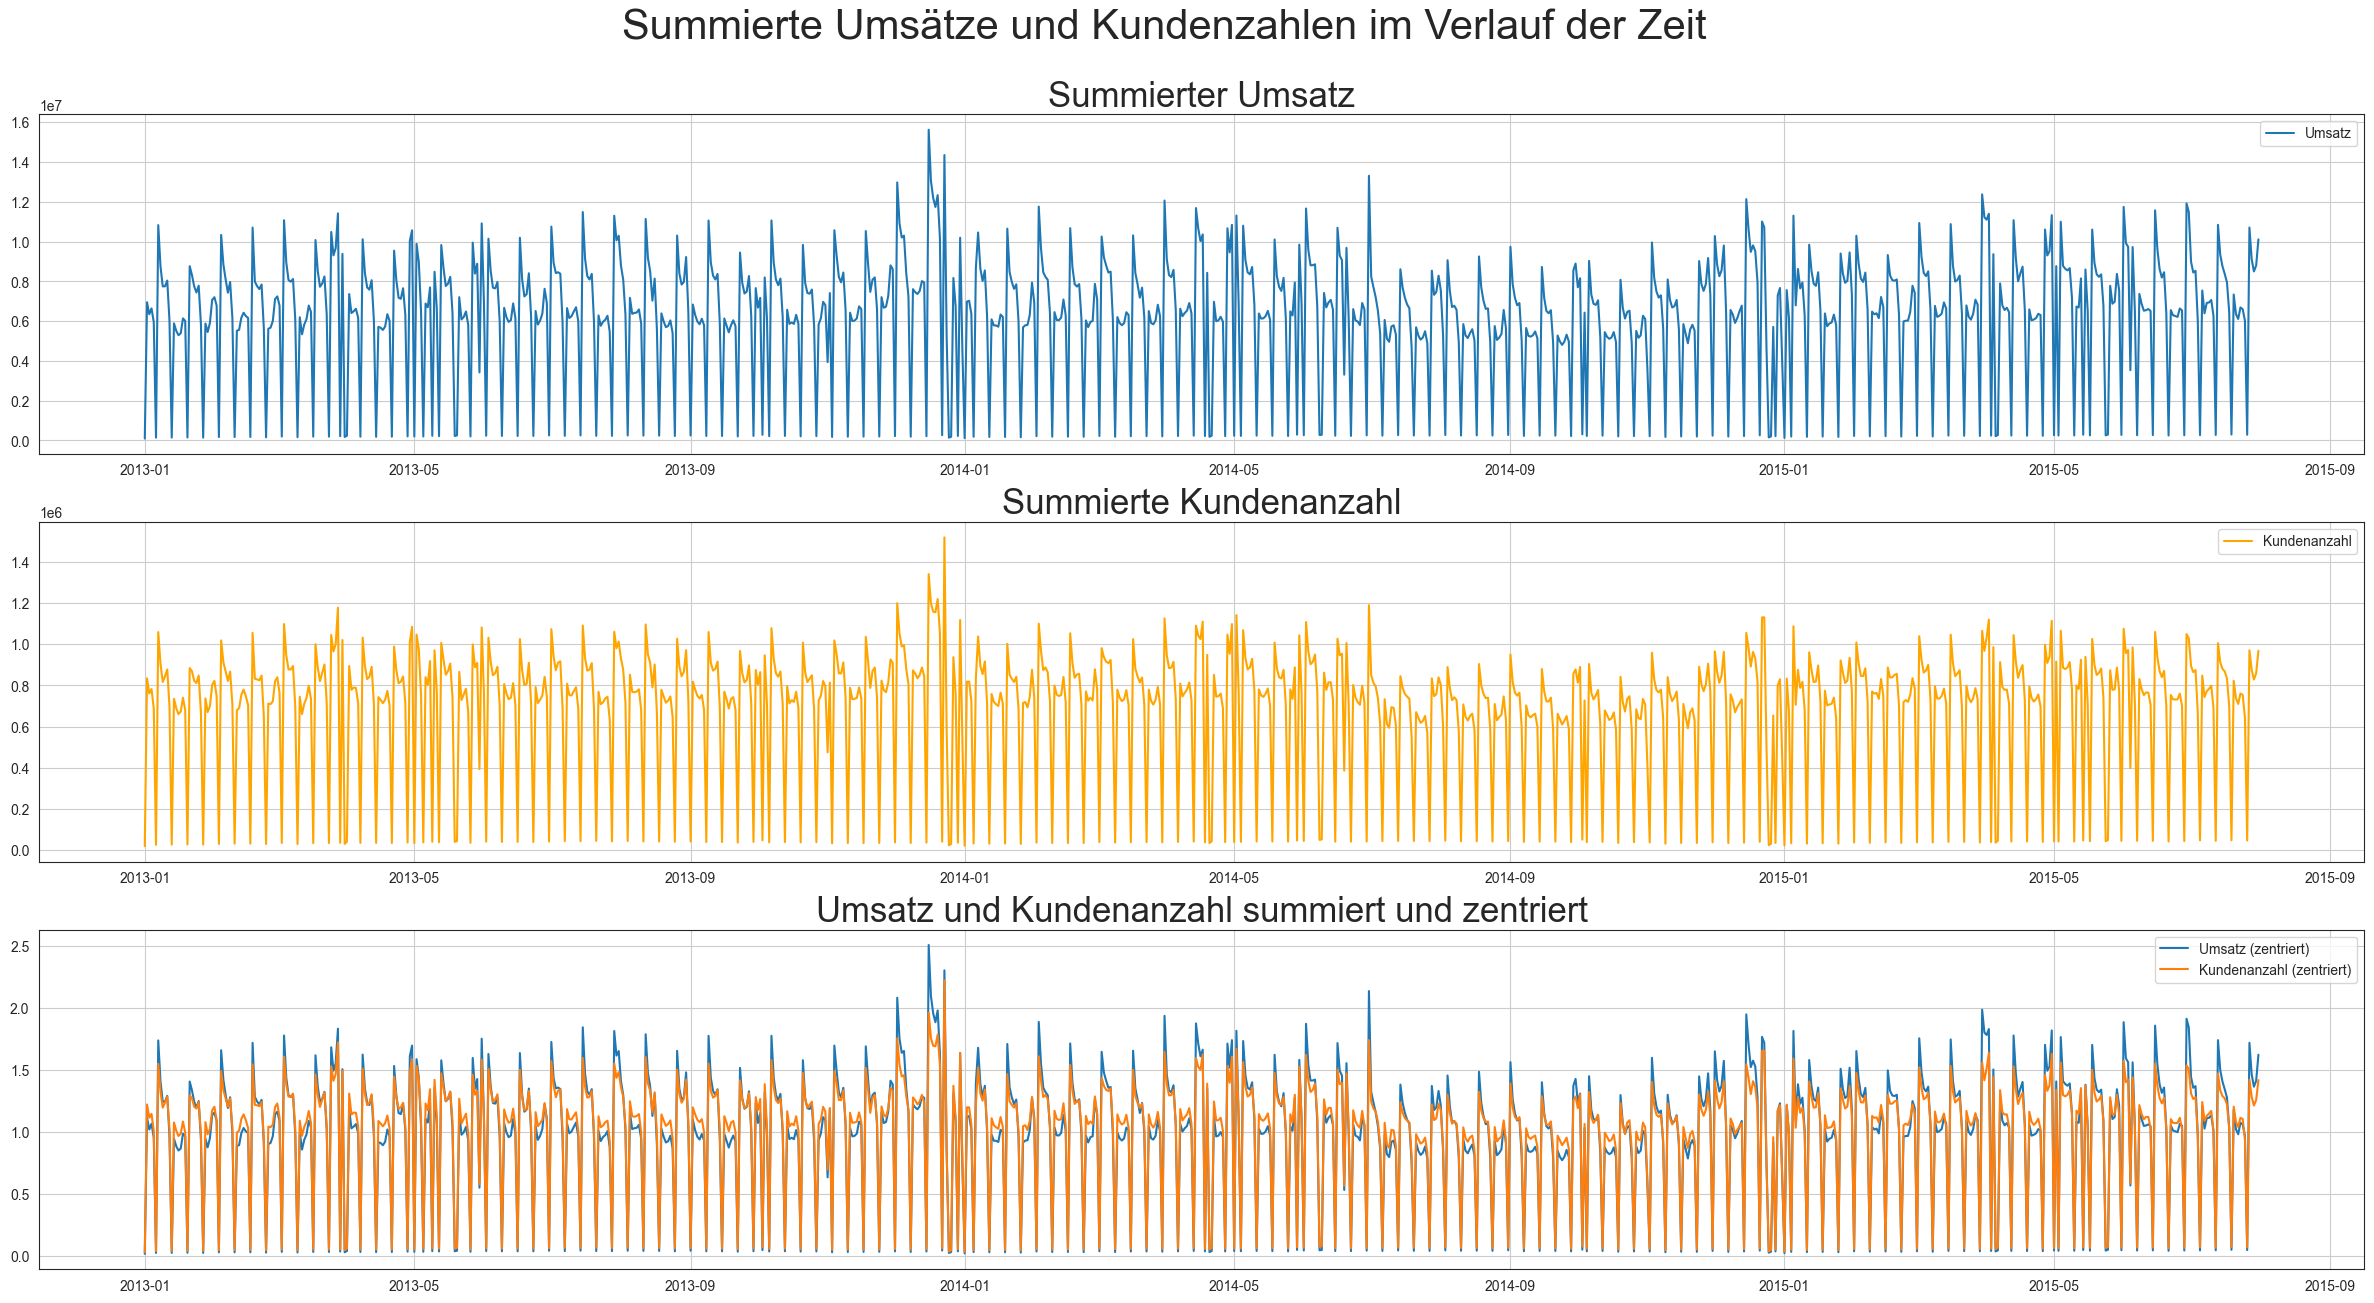

In [265]:
# Plot der Summe des Umsatzes und der Kundenzahl im zeitlichen Verlauf
revenue = train_x_store.groupby("Datum")["Umsatz"].sum()
customer = train_x_store.groupby("Datum")["Kundenanzahl"].sum()

fig, axs = plt.subplots(3, figsize=(30,15))


axs[0].plot(revenue.index, revenue.values, label = "Umsatz")
axs[0].set_title("Summierter Umsatz", fontsize=25, y=1)

axs[1].plot(customer.index, customer.values, label = "Kundenanzahl", color = "orange")
axs[1].set_title("Summierte Kundenanzahl", fontsize=25, y=1)

axs[2].plot(revenue.index, revenue.values/revenue.mean(), label = "Umsatz (zentriert)")
axs[2].plot(customer.index, customer.values/customer.mean(), label = "Kundenanzahl (zentriert)")
axs[2].set_title("Umsatz und Kundenanzahl summiert und zentriert", fontsize=25, y=1)

for ax in axs:
    ax.grid()
    ax.legend()
    

fig.suptitle('Summierte Umsätze und Kundenzahlen im Verlauf der Zeit', fontsize=30, y=.95)
plt.show()


In [266]:
stores_without_missing_data = train_x_store[~train_x_store["Filiale"].isin(stores_with_missing_data.index)].copy()

# choose random store (id) of each store typ
store_id_a = stores_without_missing_data[stores_without_missing_data["Filialentyp"] == "a"]["Filiale"].sample(n=1).values[0]
store_id_b = stores_without_missing_data[stores_without_missing_data["Filialentyp"] == "b"]["Filiale"].sample(n=1).values[0]
store_id_c = stores_without_missing_data[stores_without_missing_data["Filialentyp"] == "c"]["Filiale"].sample(n=1).values[0]
store_id_d = stores_without_missing_data[stores_without_missing_data["Filialentyp"] == "d"]["Filiale"].sample(n=1).values[0]

# store_id = 200

"""
get a sample of the training data for each choosen store id (only "Datum", "Umsatz" and "Kundenanzahl" is needed)
Sample includes all data of the selected store (id)
"""
sample_a = train_x_store[train_x_store["Filiale"]==store_id_a][["Datum", "Umsatz", "Kundenanzahl"]].copy().set_index("Datum", drop = True).sort_index()
sample_b = train_x_store[train_x_store["Filiale"]==store_id_b][["Datum", "Umsatz", "Kundenanzahl"]].copy().set_index("Datum", drop = True).sort_index()
sample_c = train_x_store[train_x_store["Filiale"]==store_id_c][["Datum", "Umsatz", "Kundenanzahl"]].copy().set_index("Datum", drop = True).sort_index()
sample_d = train_x_store[train_x_store["Filiale"]==store_id_d][["Datum", "Umsatz", "Kundenanzahl"]].copy().set_index("Datum", drop = True).sort_index()

In [267]:
# display(sample)
# lags = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 30, 60, 90]

# fig, axs = plt.subplots(4, figsize= (20,12))
# plot_acf(sample_a["Umsatz"], lags = 60, zero = False, ax = axs[0])
# plot_acf(sample_b["Umsatz"], lags = 60, zero = False, ax = axs[1])
# plot_acf(sample_c["Umsatz"], lags = 60, zero = False, ax = axs[2])
# plot_acf(sample_d["Umsatz"], lags = 60, zero = False, ax = axs[3])

# plt.show()

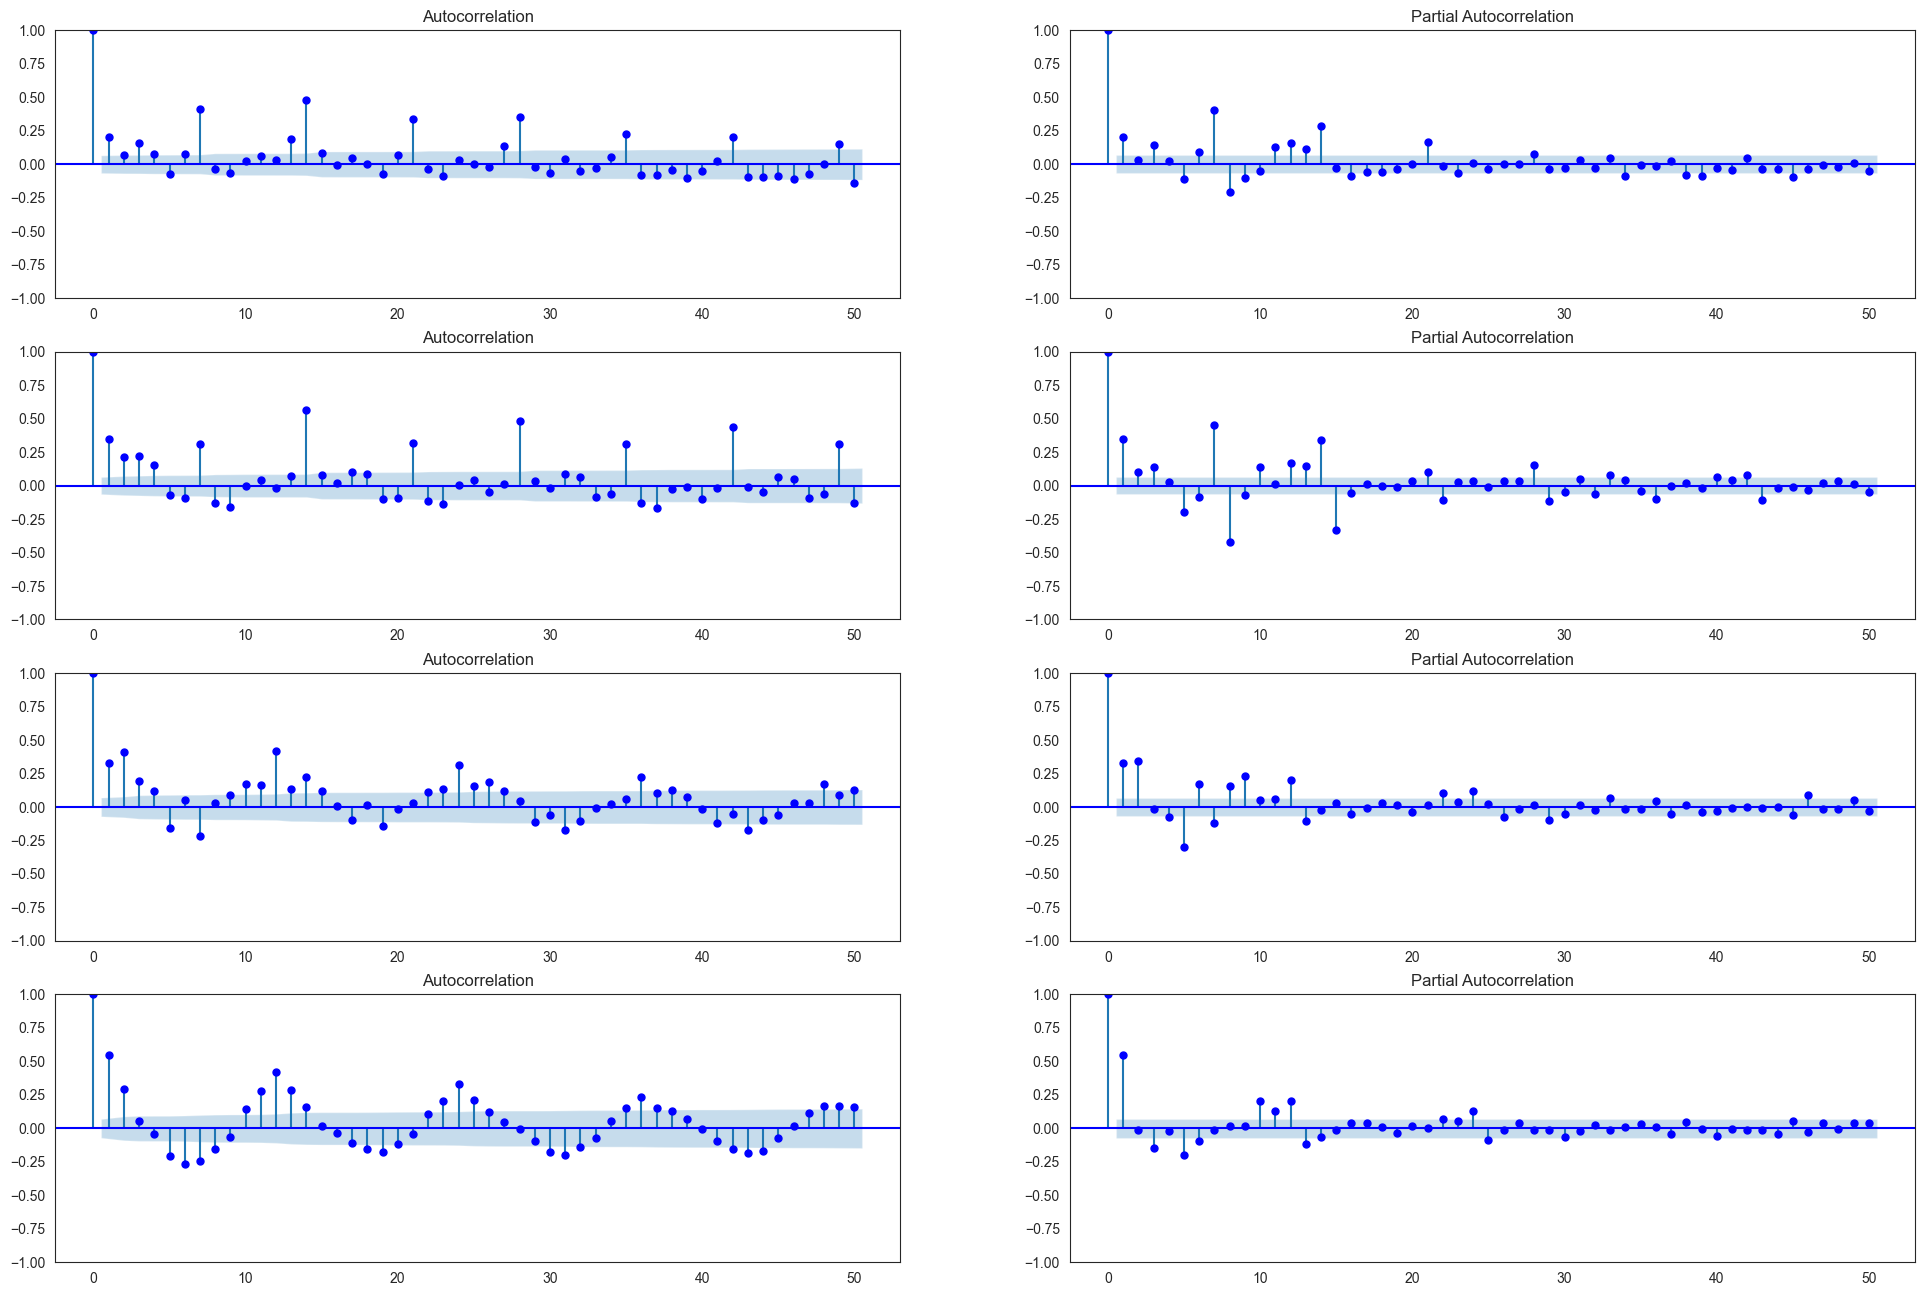

In [268]:
# figure for subplots
plt.figure(figsize = (24, 16))

# acf and pacf for sample a (Umsatz)
plt.subplot(421); plot_acf(sample_a["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")
plt.subplot(422); plot_pacf(sample_a["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")

# acf and pacf for sample b (Umsatz)
plt.subplot(423); plot_acf(sample_b["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")
plt.subplot(424); plot_pacf(sample_b["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")

# acf and pacf for sample c (Umsatz)
plt.subplot(425); plot_acf(sample_c["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")
plt.subplot(426); plot_pacf(sample_c["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")

# acf and pacf for sample d (Umsatz)
plt.subplot(427); plot_acf(sample_d["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")
plt.subplot(428); plot_pacf(sample_d["Umsatz"], lags = 50, ax = plt.gca(), color = "blue")

plt.show()

Der Umsatz weist eine Autokorrelation zu den Vielfachen von Sieben auf, was darauf schließen lässt, dass der Umsatz vom Wochentag abhängig ist. Die Autokorrelation gibt keinen Hinweis auf einen anderen zeitlichen Einfluss. Im Folgenden wird der zeitliche Einfluss der Woche als Saisonalität aus den Daten herausgerechnet und so der Einfluss der Saisonalität dargestellt. Aufgrund der Ergebnisse der Untersuchung der Autokorrelation wird als Periode (Dauer einer Saisonalität) 7 gewählt. 

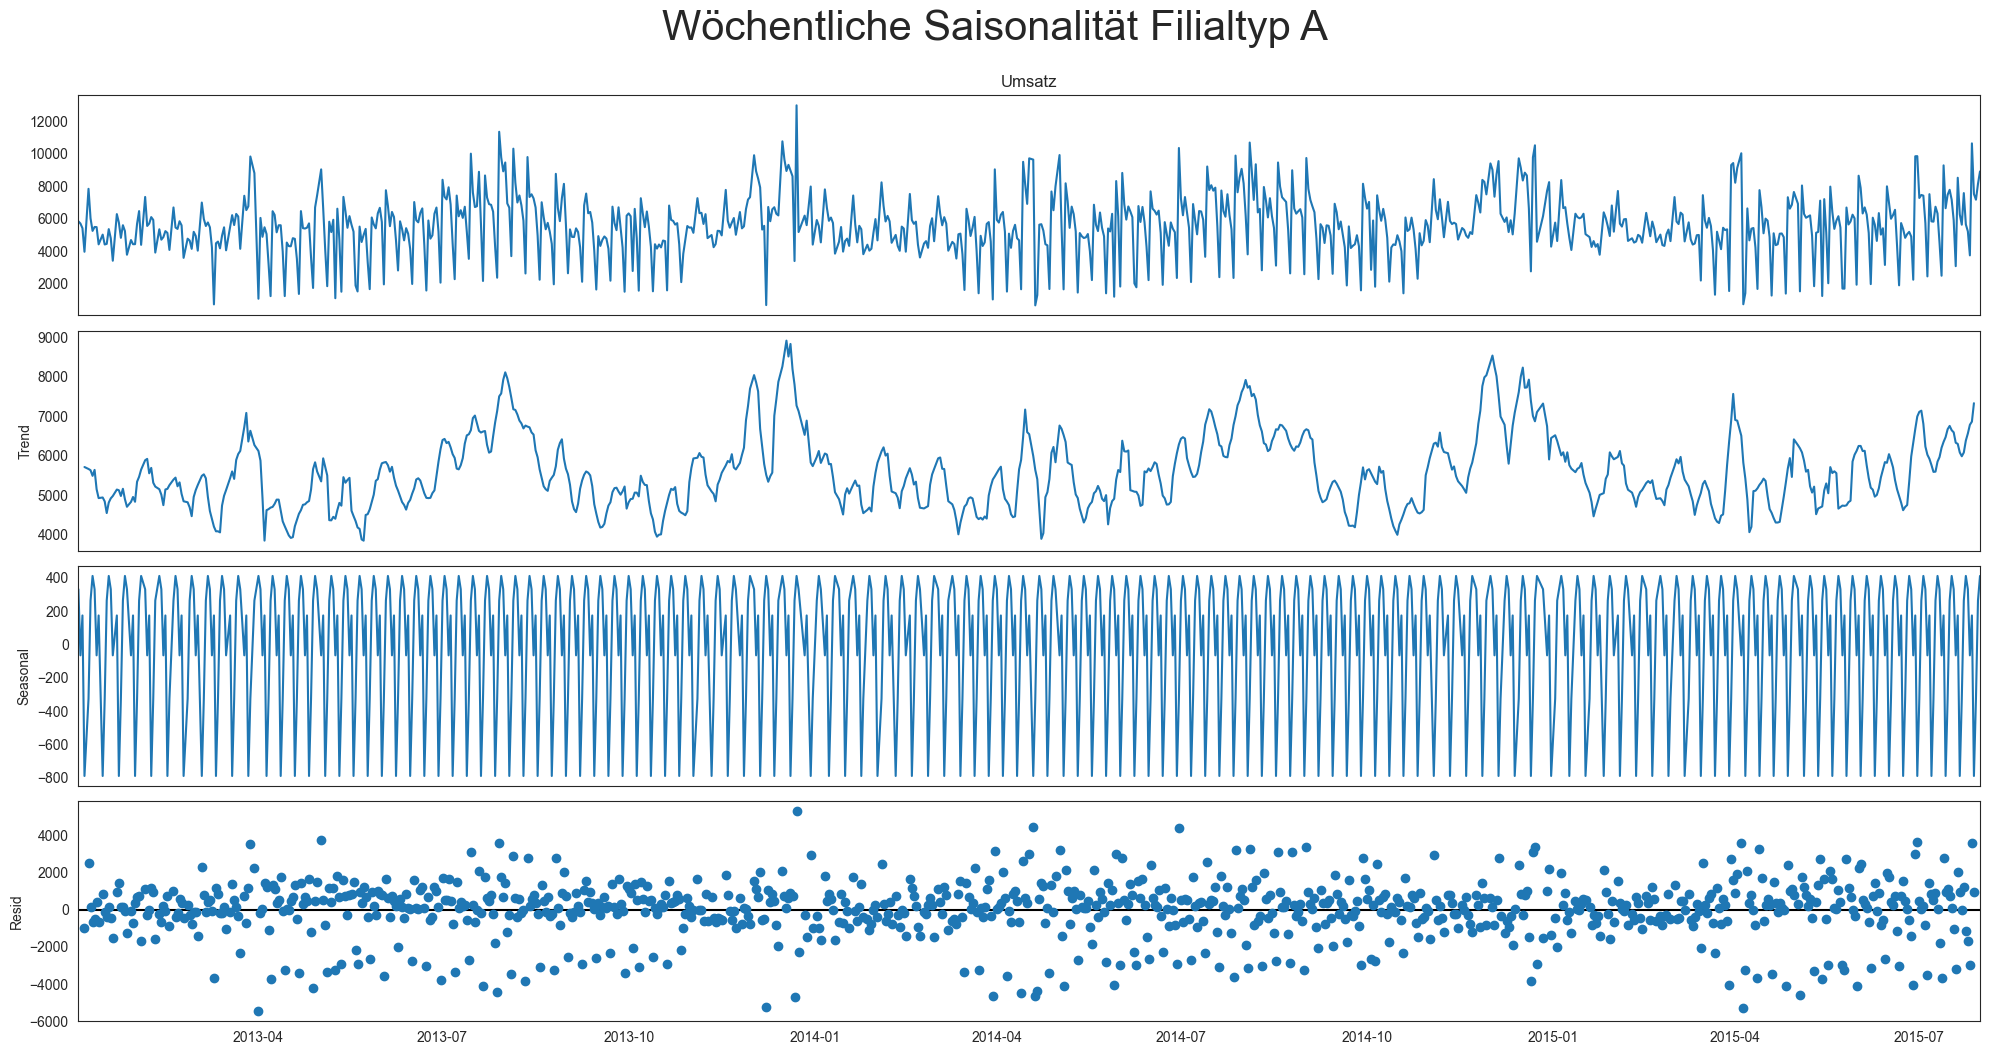

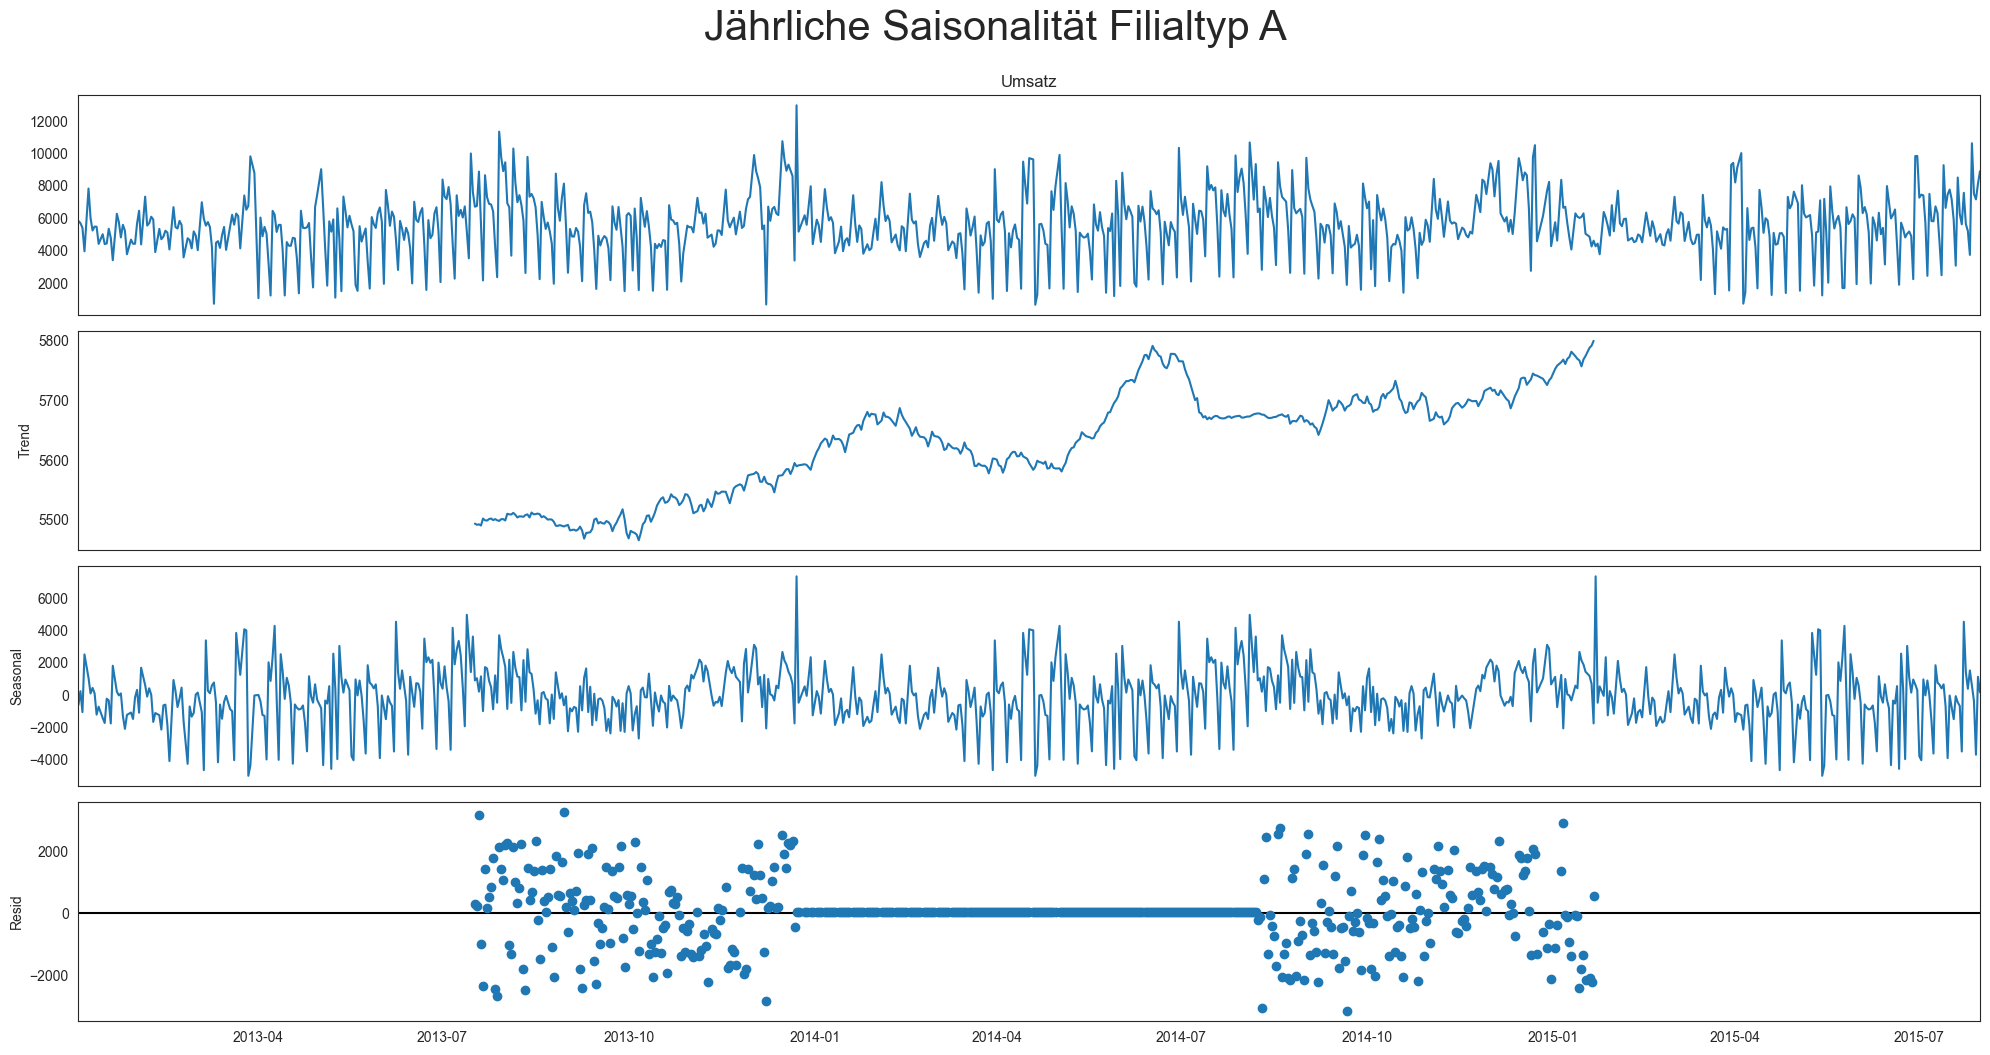

In [269]:
stl_weekly_umsatz = seasonal_decompose(sample_a["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample_a["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität Filialtyp A', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität Filialtyp A', fontsize=30, y=1.05)
plt.show()

Bei der Zerlegung des Umsatzes in einen Wiederkehrenden Term (Saisonalität - Seasonal), einen den zugrunden liegenden Trend und einen unerklärlichen Teil (Residuen - Resid) ergeben sich, bei einer Periodenlänge von 7 bzw. 365 Tagen die oberen Plots. Auch wenn die Autokorrelation keinen Hinweis auf weitere zeitliche Einflüsse als die Woche (den Wochentag) gegeben hat, weist der Trend markante und wiederkehrende Erhebungen auf, die auf eine weitere Saisonalität hindeuten. 

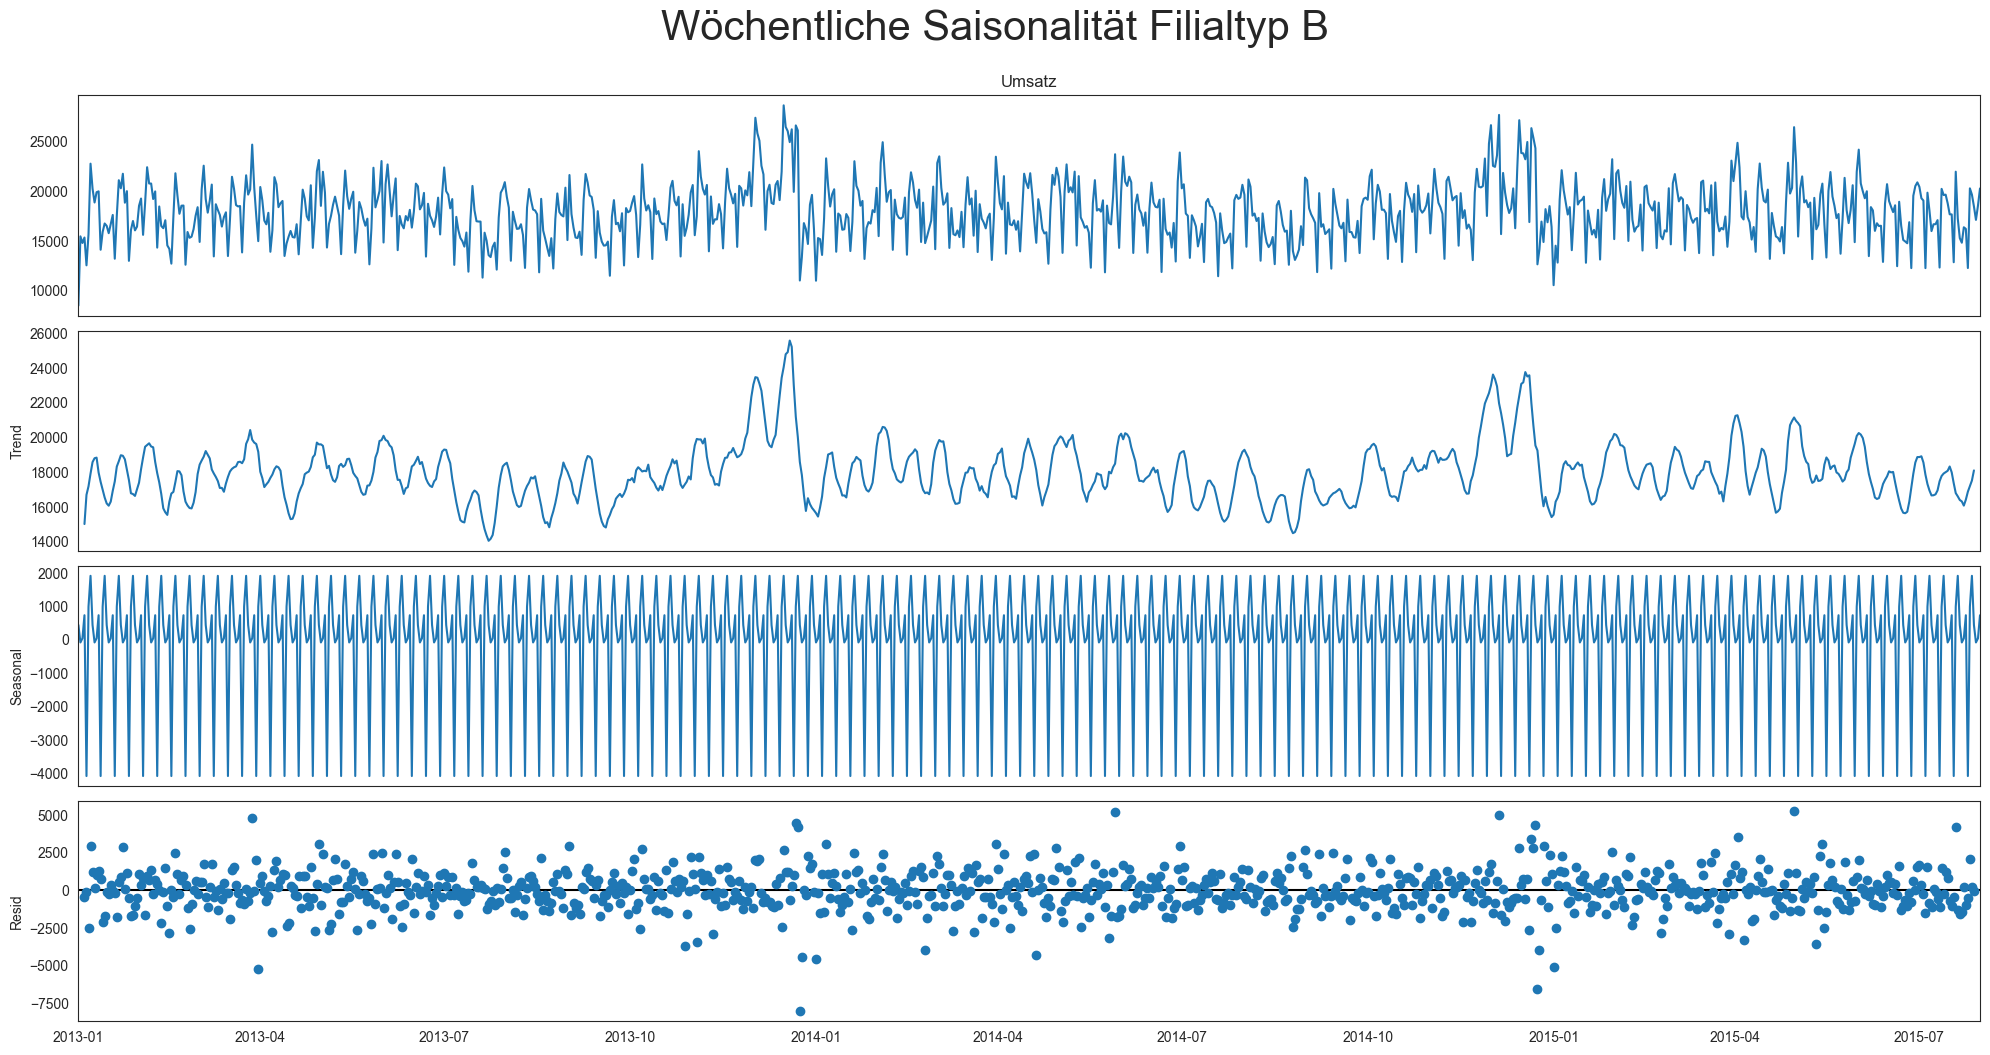

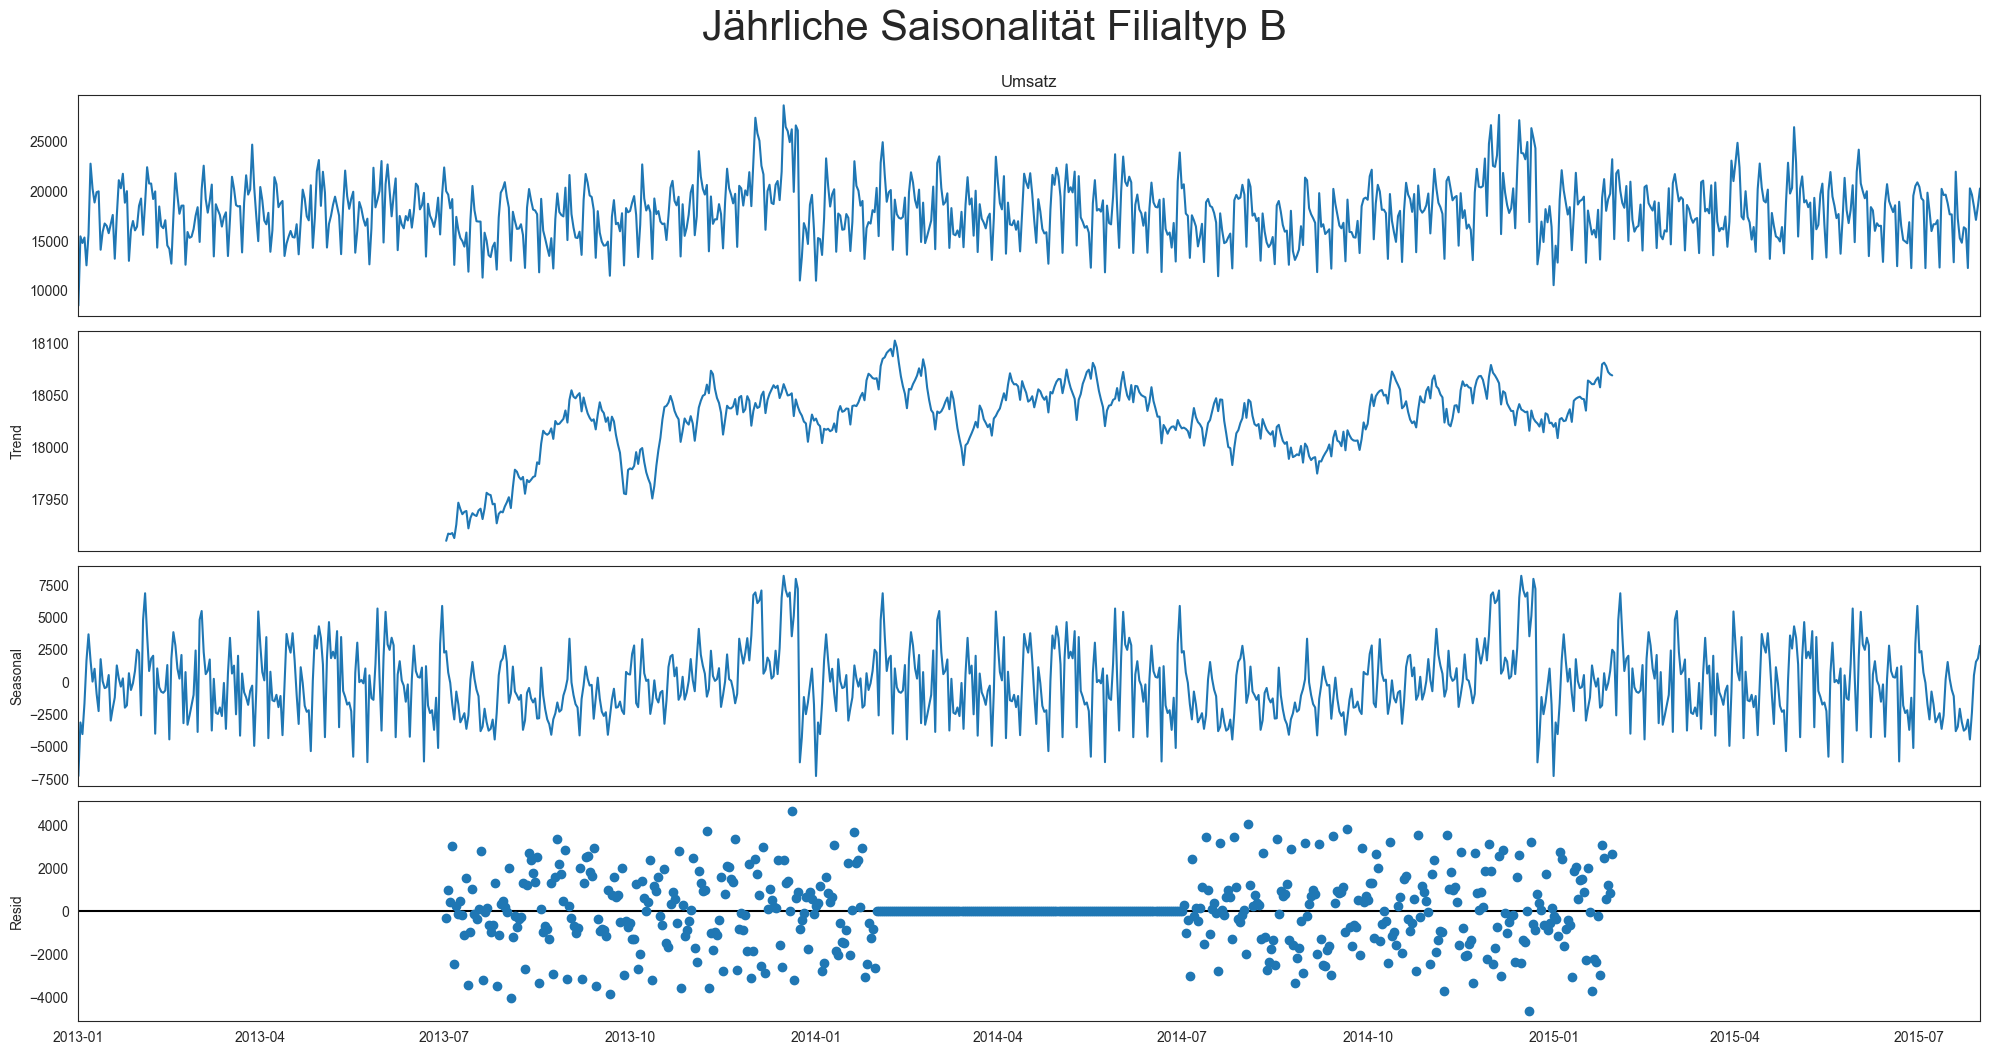

In [270]:
stl_weekly_umsatz = seasonal_decompose(sample_b["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample_b["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität Filialtyp B', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität Filialtyp B', fontsize=30, y=1.05)
plt.show()

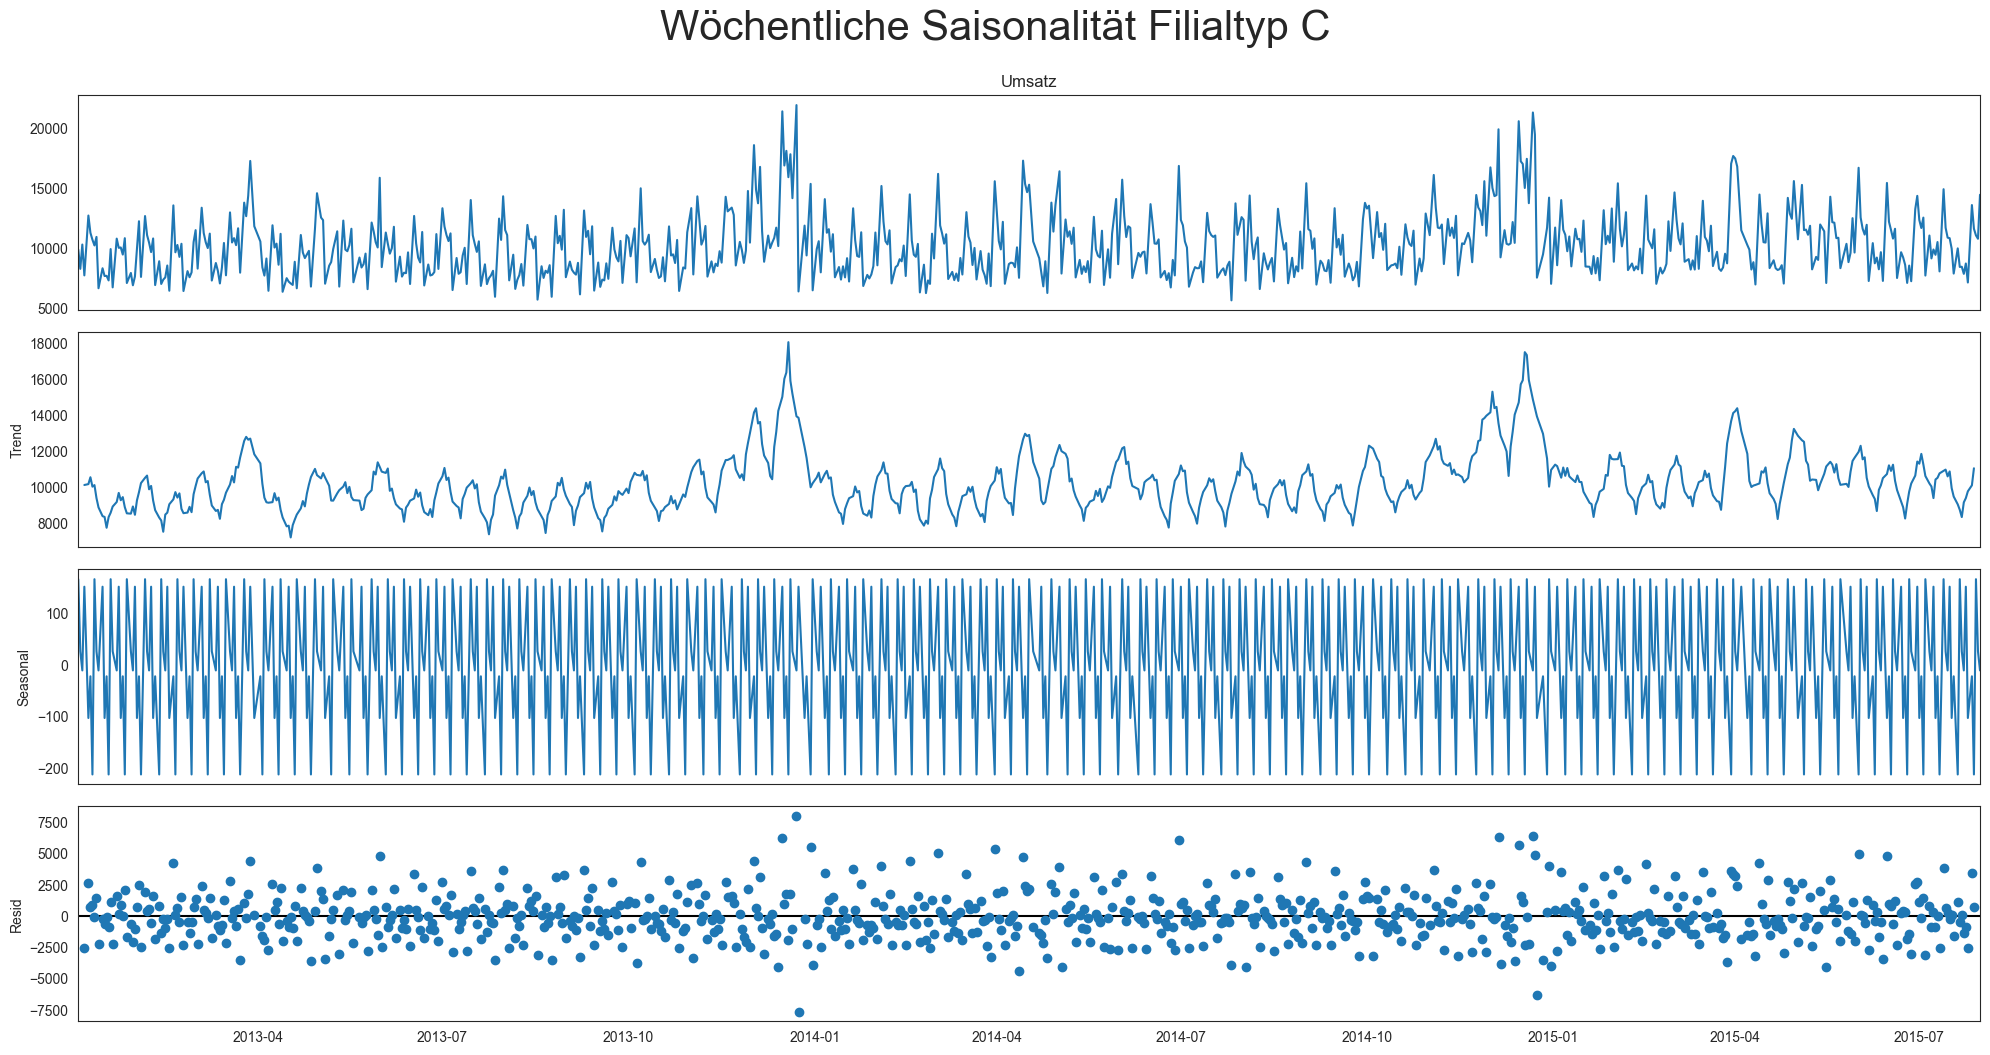

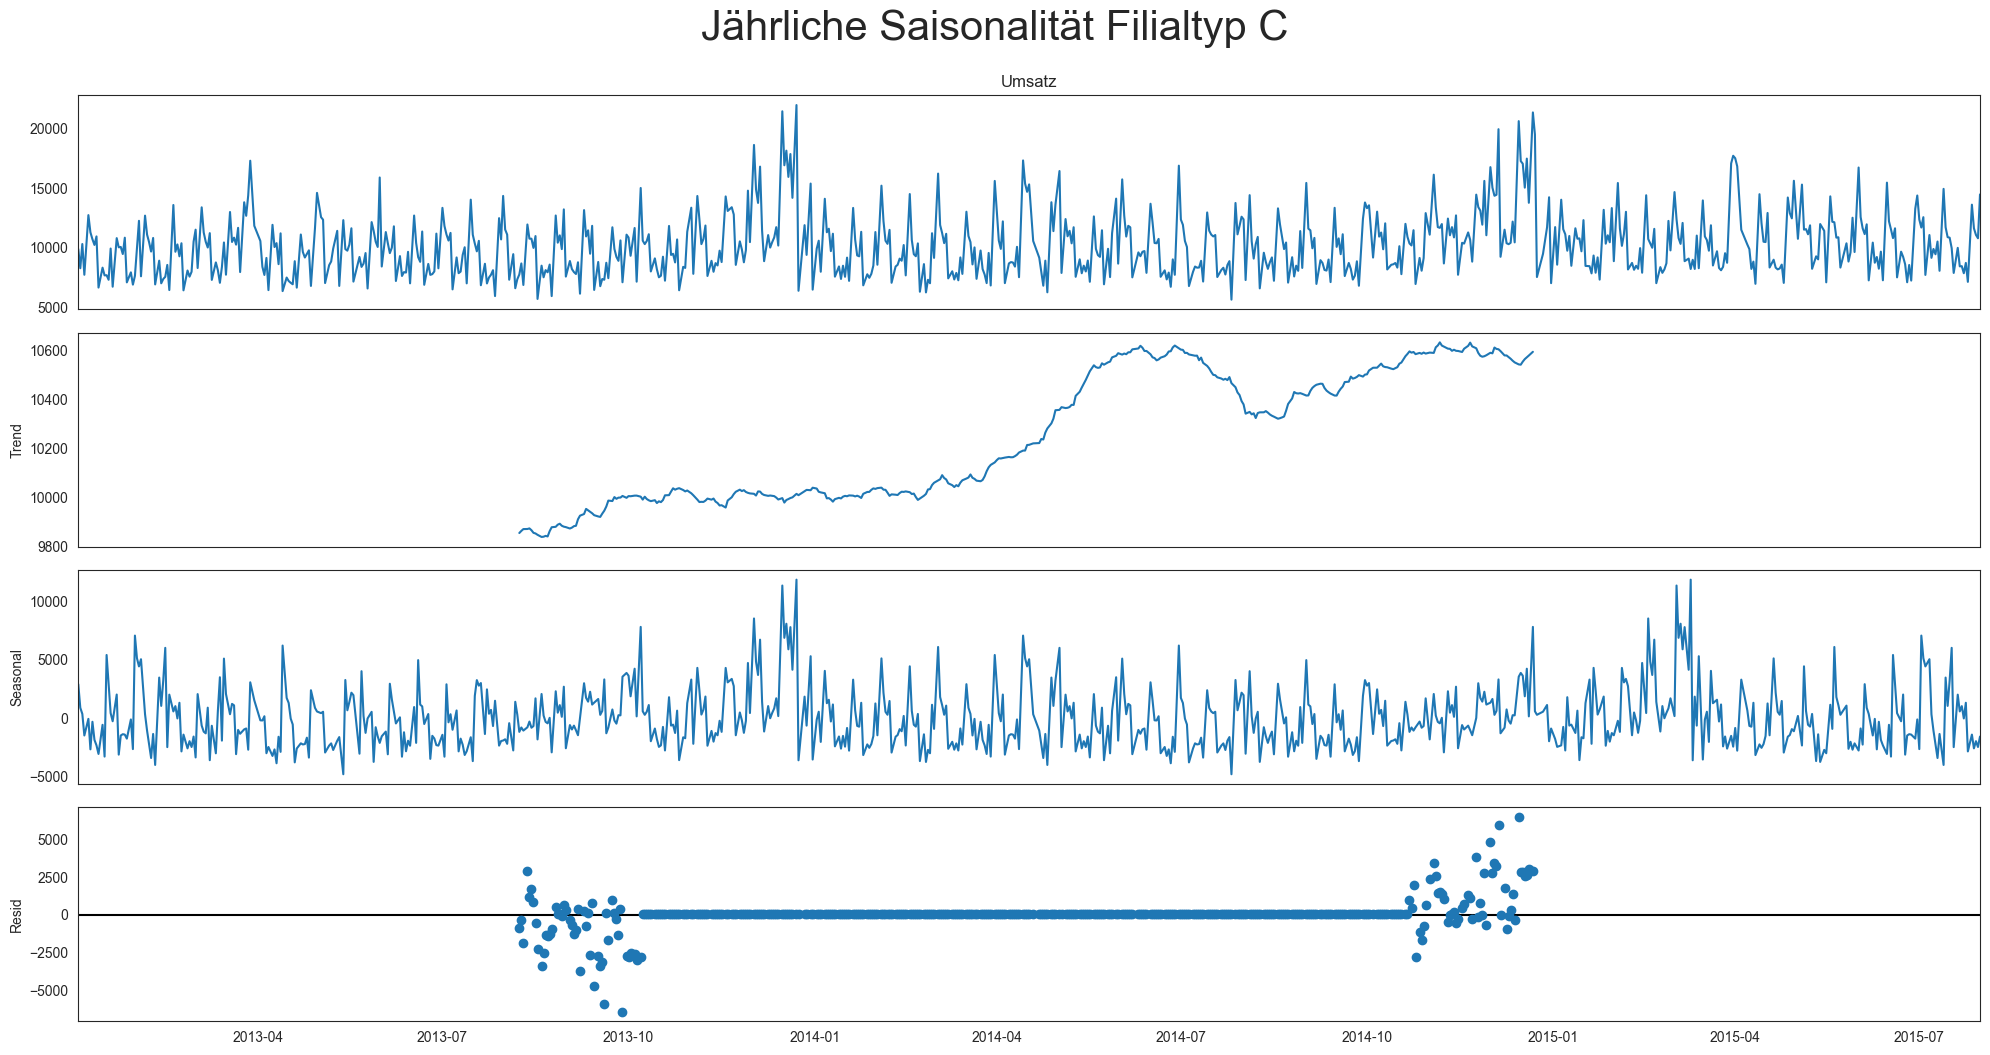

In [271]:
stl_weekly_umsatz = seasonal_decompose(sample_c["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample_c["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität Filialtyp C', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität Filialtyp C', fontsize=30, y=1.05)
plt.show()

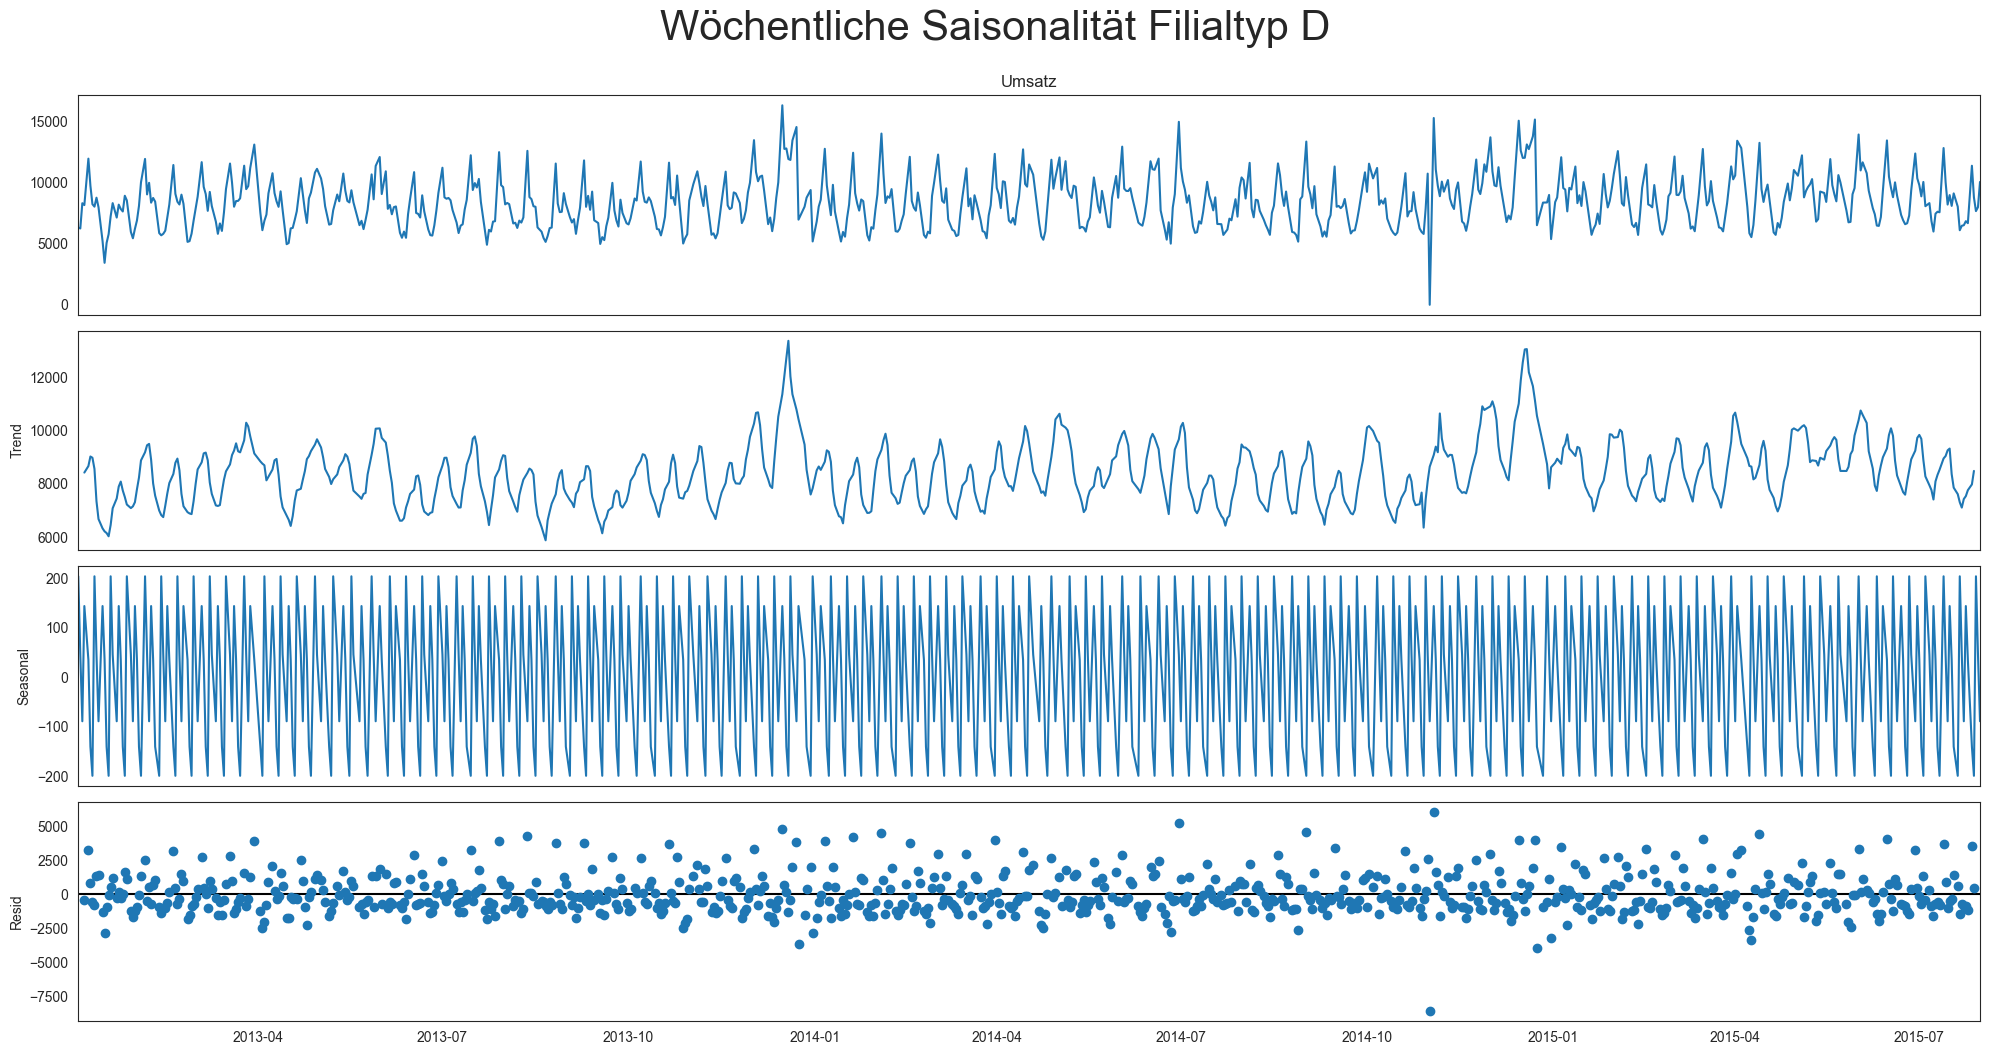

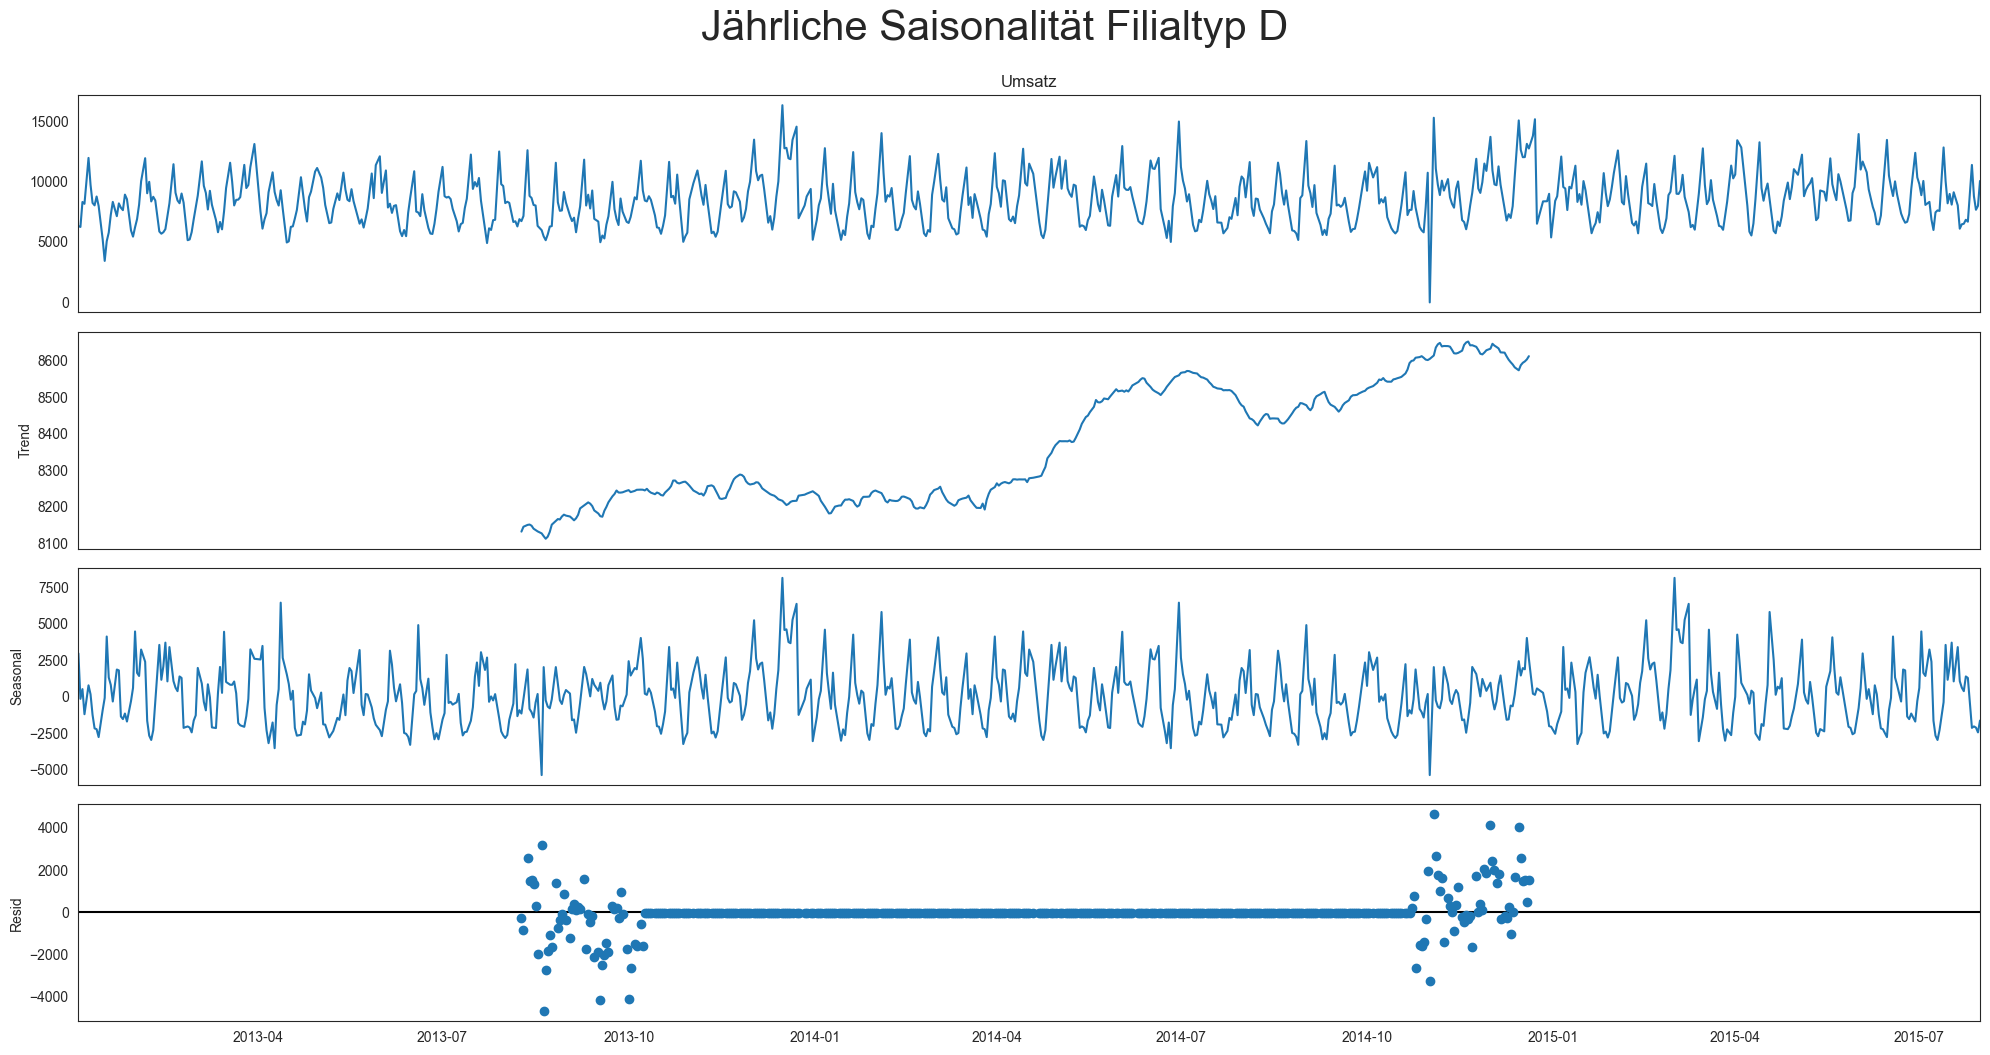

In [272]:
stl_weekly_umsatz = seasonal_decompose(sample_d["Umsatz"], model = "additive", period = 7)
stl_yearly_umsatz = seasonal_decompose(sample_d["Umsatz"], model = "additive", period = 365)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_umsatz.plot().suptitle('Wöchentliche Saisonalität Filialtyp D', fontsize=30, y=1.05)
stl_yearly_umsatz.plot().suptitle('Jährliche Saisonalität Filialtyp D', fontsize=30, y=1.05)
plt.show()

In [273]:
# fig, axs = plt.subplots(3, figsize= (20,12))
# plot_acf(sample["Kundenanzahl"], lags = len(sample)-1, zero = False, ax = axs[0])
# plot_acf(sample["Kundenanzahl"], lags = 60, zero = False, ax = axs[1])
# plot_pacf(sample["Kundenanzahl"], lags = 60, zero = False, ax = axs[2])

# plt.show()

Die Kundenanzahl weist eine Autokorrelation zu den Vielfachen von Sieben auf, was darauf schließen lässt, dass die Kundenanzahl vom Wochentag abhängig ist. Die Autokorrelation gibt keinen Hinweis auf einen anderen zeitlichen Einfluss. Im Folgenden wird der zeitliche Einfluss der Woche als Saisonalität aus den Daten herausgerechnet und so der Einfluss der Saisonalität dargestellt. Aufgrund der Ergebnisse der Untersuchung der Autokorrelation wird als Periode (Dauer einer Saisonalität) 7 gewählt. 

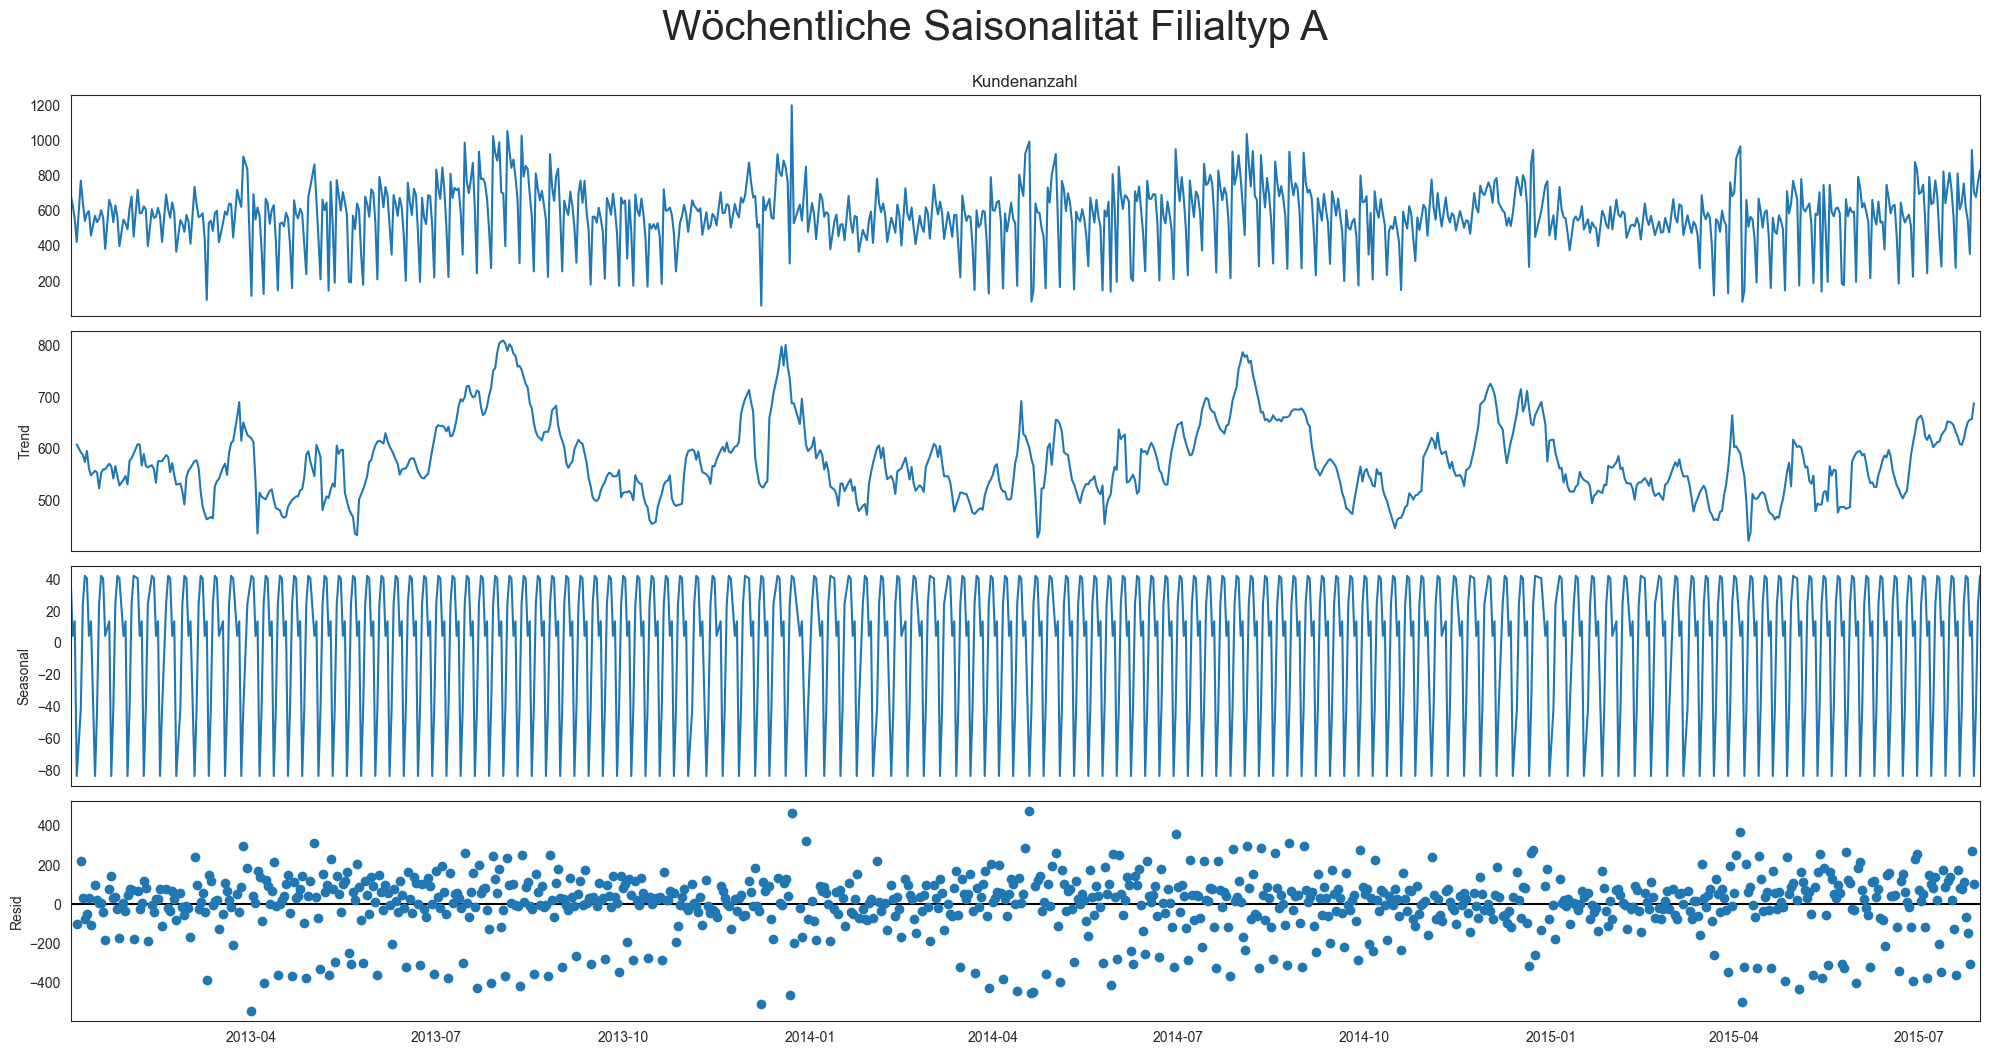

In [274]:
stl_weekly_kundenzahl = seasonal_decompose(sample_a["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität Filialtyp A', fontsize=30, y=1.05)

plt.show()

Bei der Zerlegung der Kundenanzahl in einen Wiederkehrenden Term (Saisonalität - Seasonal), einen den zugrunden liegenden Trend und einen unerklärlichen Teil (Residuen - Resid) ergeben sich, bei einer Periodenlänge von 7 bzw. 365 Tagen die oberen Plots. Auch wenn die Autokorrelation keinen Hinweis auf weitere zeitliche Einflüsse als die Woche (den Wochentag) gegeben hat, besitzt der Trend markante und wiederkehrende Erhebungen, die auf eine weitere Saisonalität hindeuten. 

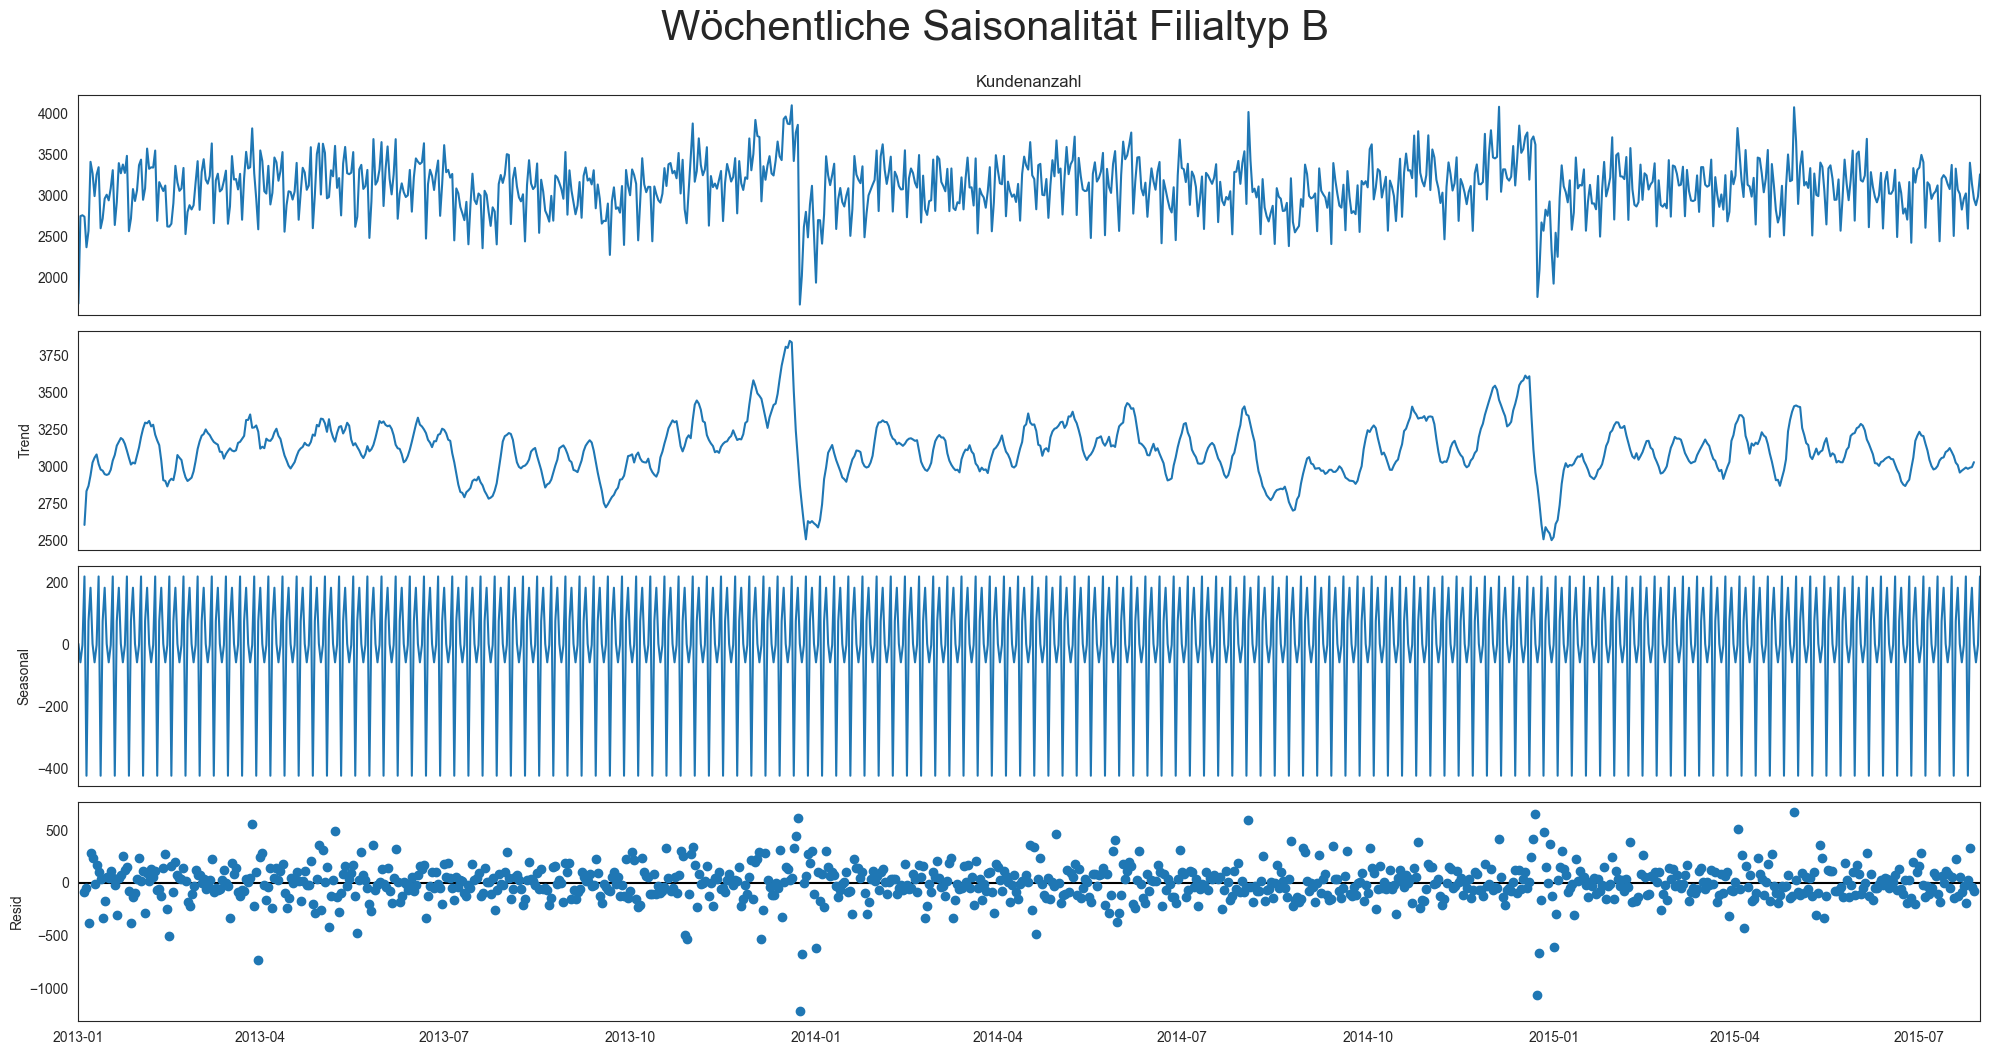

In [275]:
stl_weekly_kundenzahl = seasonal_decompose(sample_b["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität Filialtyp B', fontsize=30, y=1.05)

plt.show()

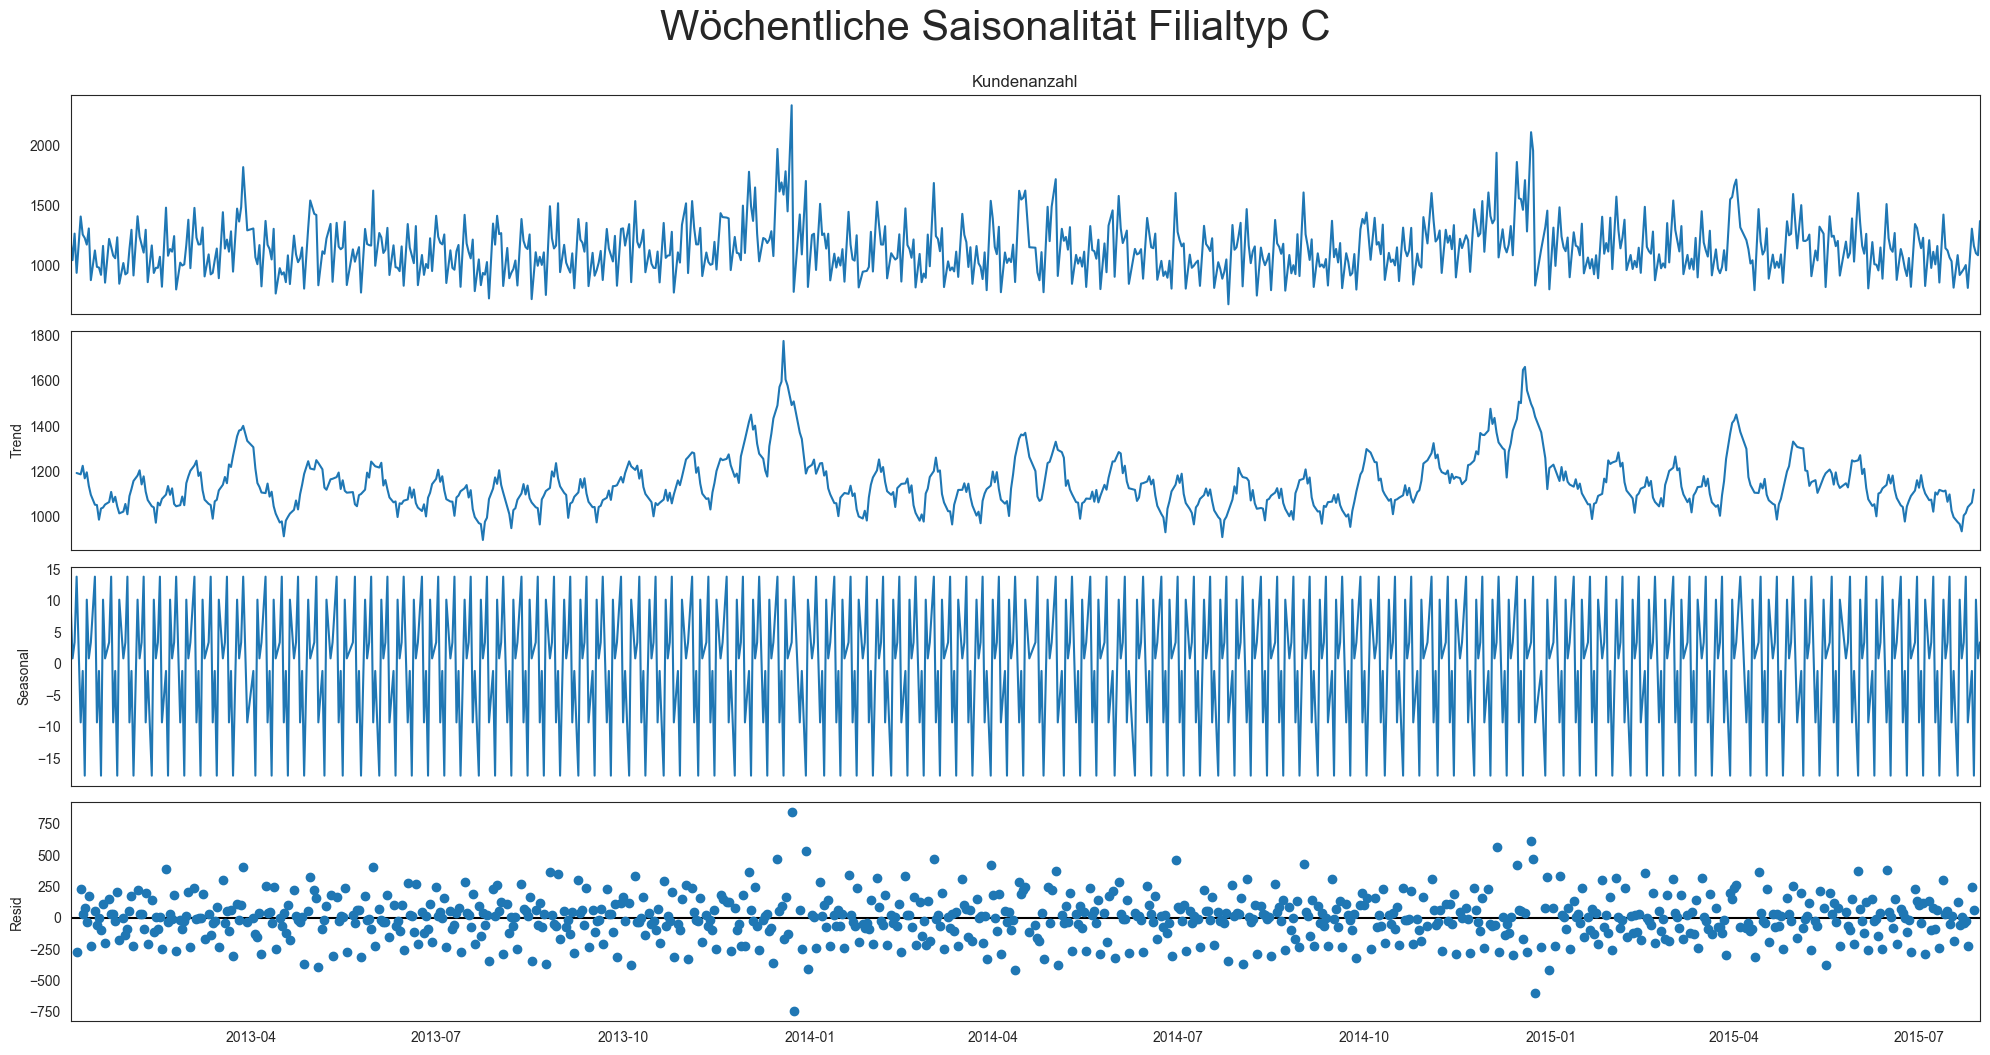

In [276]:
stl_weekly_kundenzahl = seasonal_decompose(sample_c["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität Filialtyp C', fontsize=30, y=1.05)

plt.show()

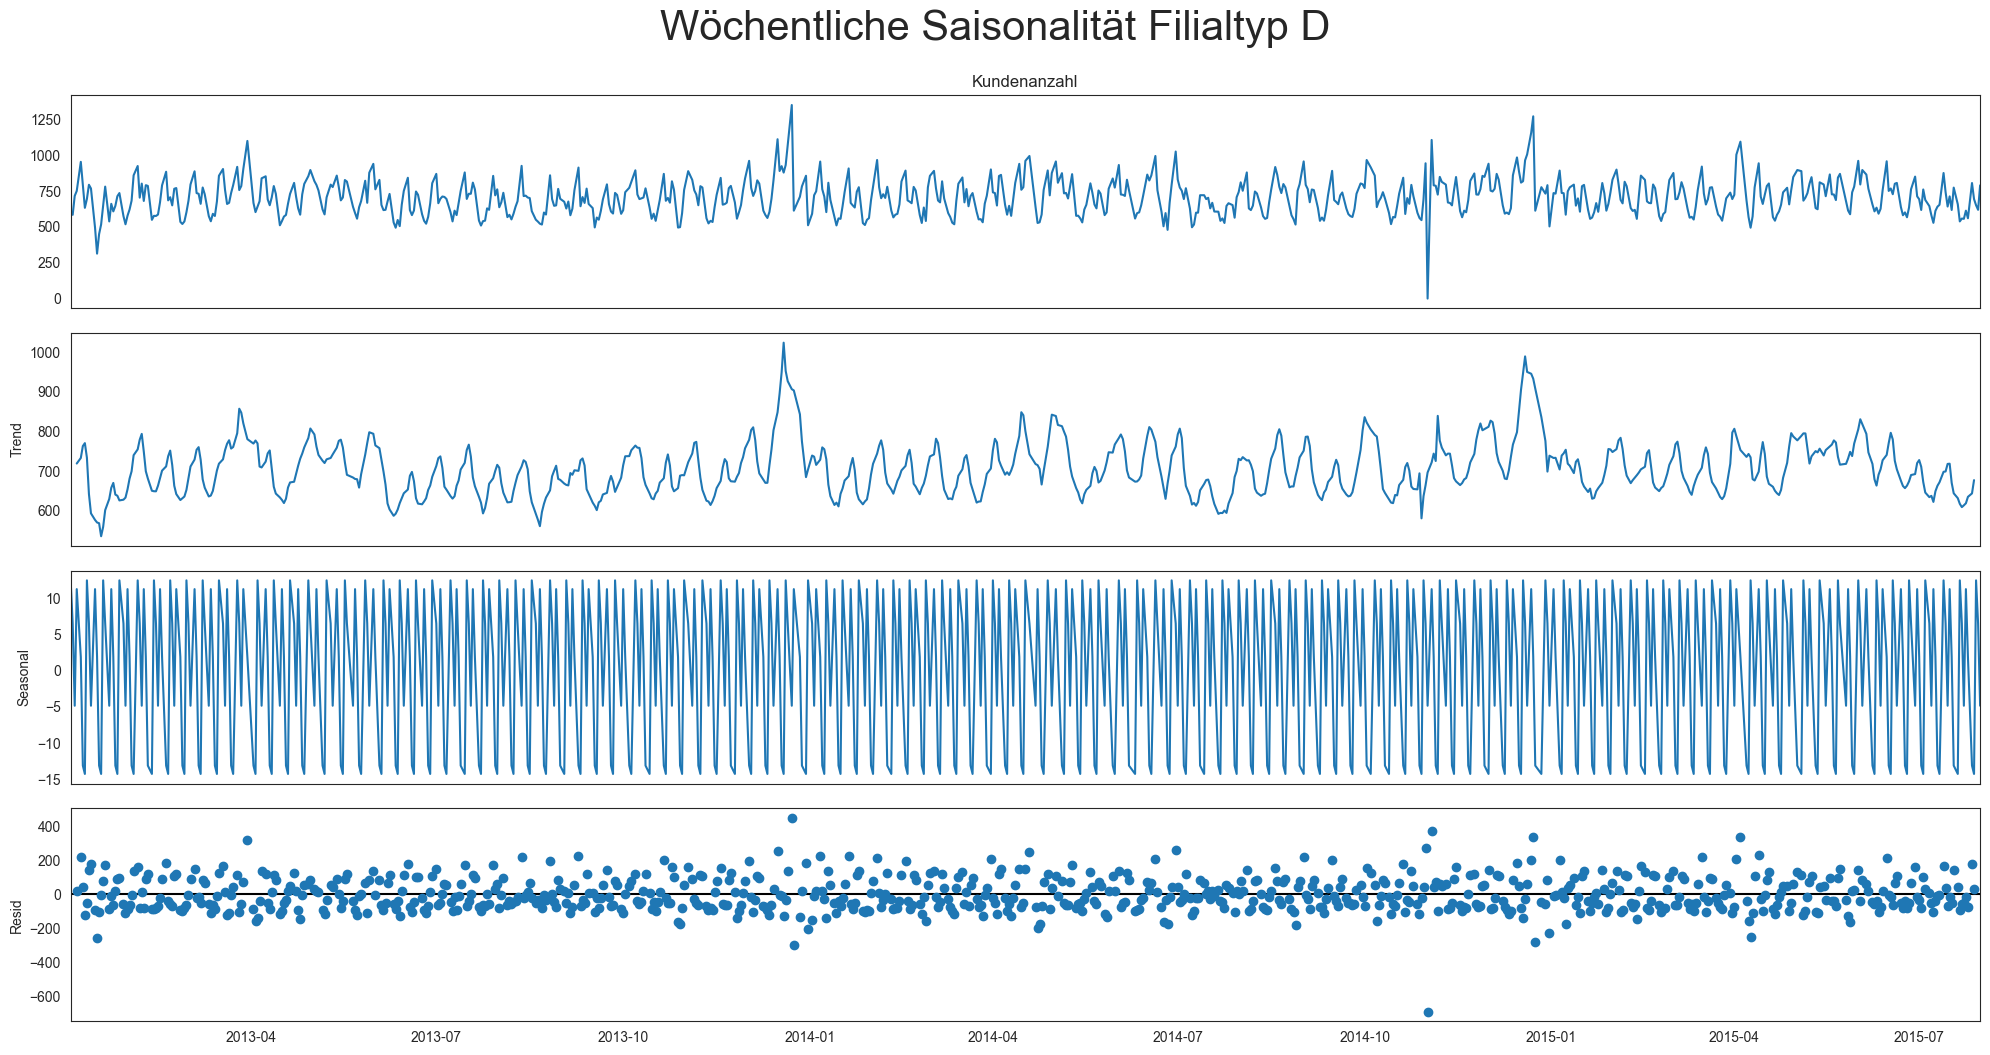

In [277]:
stl_weekly_kundenzahl = seasonal_decompose(sample_d["Kundenanzahl"], model = "additive", period=7)

plt.rcParams.update({'figure.figsize': (20, 10)})
stl_weekly_kundenzahl.plot().suptitle('Wöchentliche Saisonalität Filialtyp D', fontsize=30, y=1.05)

plt.show()

In [278]:
# Eine Filiale zufällig wählen
store_id = store["Filiale"].sample(n=1).values[0]

# Den Datensatz auf die zuvor festgelegte Filiale filtern
sample = train_x_store[train_x_store["Filiale"]==store_id].copy()
sample_gp_weekday = sample.groupby(by=["Wochentag"])

weekdays = []
mean_revenue = []
mean_numb_of_customers = []
for weekday, df in sample_gp_weekday:
    weekdays.append(weekday[0])
    mean_revenue.append(df["Umsatz"].mean())
    mean_numb_of_customers.append(df["Kundenanzahl"].mean())
    

df_avg_week = pd.DataFrame(data = {"Wochentag": weekdays, "Umsatz": mean_revenue, "Kundenanzahl": mean_numb_of_customers})
display(df_avg_week)

Wochentag        Umsatz  Kundenanzahl
0          0  10772.070866   1133.070866
1          1   9694.308271   1068.315789
2          2   9083.946970   1010.530303
3          3   8987.806452   1017.951613
4          4   9246.421875   1033.242188
5          5   7667.052239    857.298507

In [279]:
'''
locale.setlocale(locale.LC_ALL, 'de_DE')

fig, axs = plt.subplots(2, figsize = (10,10))

axs[0].bar(calendar.day_name, df_avg_week.Umsatz, label = "Durchchnittlicher Umsatz")
axs[1].bar(calendar.day_name, df_avg_week.Kundenanzahl, label = "Durchschnittliche Kundenanzahl")

for ax in axs:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax.grid()
plt.show()
'''


'\nlocale.setlocale(locale.LC_ALL, \'de_DE\')\n\nfig, axs = plt.subplots(2, figsize = (10,10))\n\naxs[0].bar(calendar.day_name, df_avg_week.Umsatz, label = "Durchchnittlicher Umsatz")\naxs[1].bar(calendar.day_name, df_avg_week.Kundenanzahl, label = "Durchschnittliche Kundenanzahl")\n\nfor ax in axs:\n    ax.legend(loc=\'upper center\', bbox_to_anchor=(0.5, 1.05))\n    ax.grid()\nplt.show()\n'

In [280]:
sample_gp_day = sample.groupby(by=["Tag"])

days = []
mean_revenue = []
mean_numb_of_customers = []
for day, df in sample_gp_day:
    days.append(day[0])
    mean_revenue.append(df["Umsatz"].mean())
    mean_numb_of_customers.append(df["Kundenanzahl"].mean())
    

df_avg_day_of_month = pd.DataFrame(data = {"Tag": days, "Umsatz": mean_revenue, "Kundenanzahl": mean_numb_of_customers})
display(df_avg_day_of_month.head(3))

Tag        Umsatz  Kundenanzahl
0    1  10123.166667   1039.888889
1    2  10464.111111   1111.185185
2    3  10525.217391   1097.043478

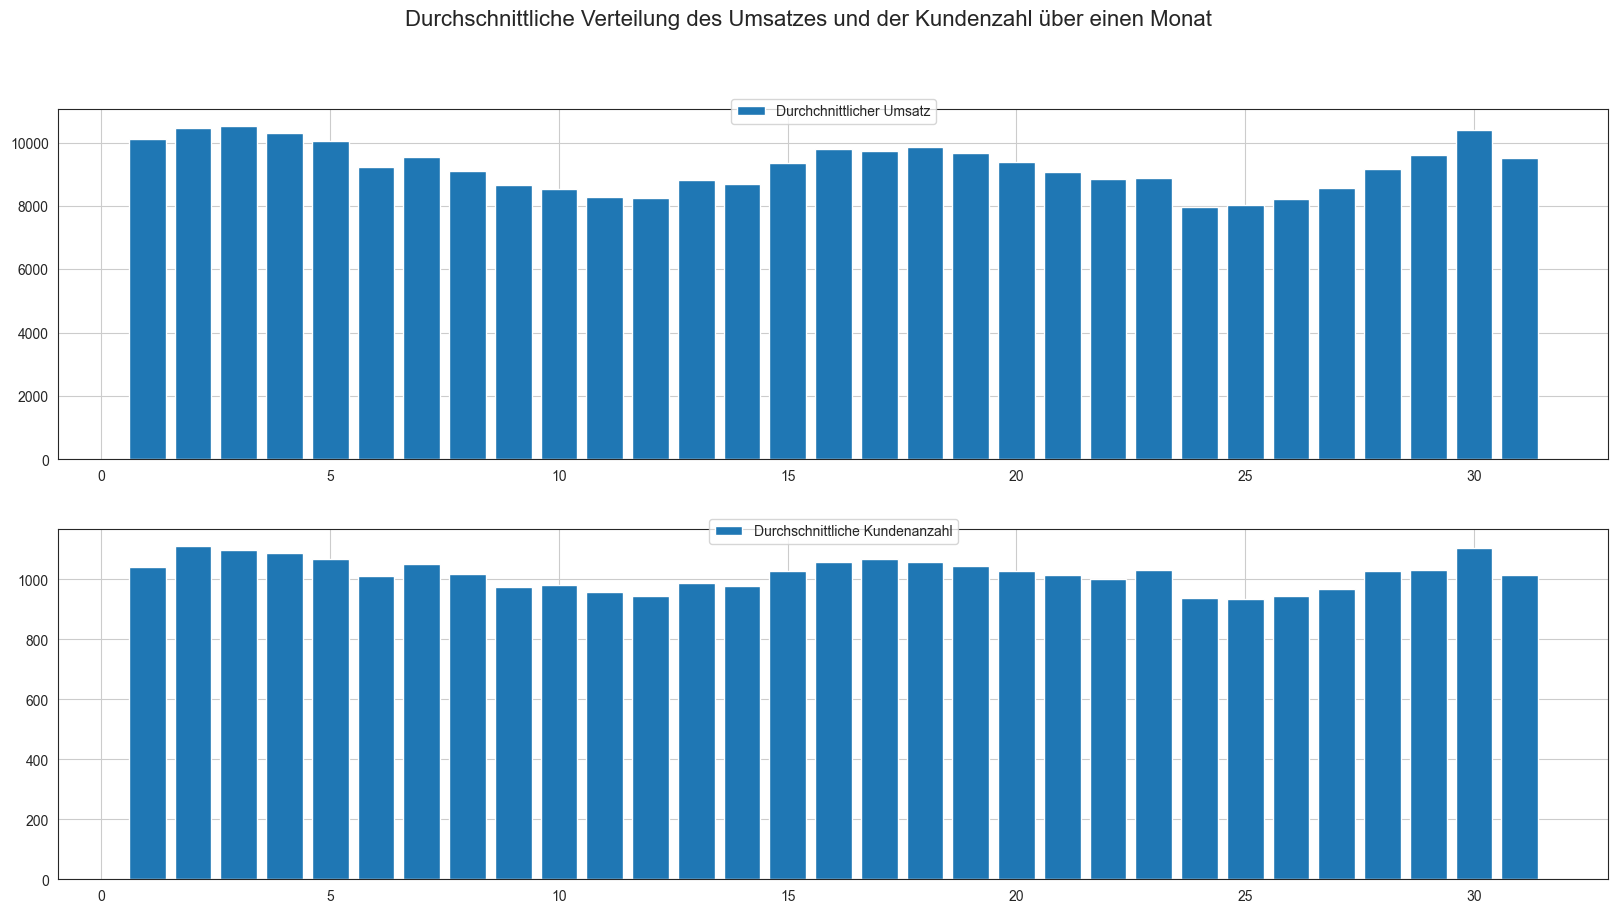

In [281]:
fig, axs = plt.subplots(2, figsize = (20,10))

axs[0].bar(df_avg_day_of_month.Tag, df_avg_day_of_month.Umsatz, label = "Durchchnittlicher Umsatz")
axs[1].bar(df_avg_day_of_month.Tag, df_avg_day_of_month.Kundenanzahl, label = "Durchschnittliche Kundenanzahl")

for ax in axs:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax.grid()

fig.suptitle('Durchschnittliche Verteilung des Umsatzes und der Kundenzahl über einen Monat', fontsize=16)
plt.show()

### 3.9 Korrelationsanalyse <a id="3.8"></a> <br>

#### Korrelationsmatrix auf den gesamten Train-Store-Datensatz

Die Korrelationsmatrix beinhaltet alle numerischen Spalten aus dem _train_x_store_ Datensatz. Dabei wird bei der Pearson-Korrelation mit binären Variablen genauso wie mit kontinuierlichen Variablen umgegangen.

Filiale       Tag     Monat      Jahr   Quartal  Wochentag  \
Filiale  1.000000 -0.000130  0.001378  0.000318  0.001409   0.000409   
Tag     -0.000130  1.000000 -0.007795  0.008247 -0.000526   0.007375   
Monat    0.001378 -0.007795  1.000000 -0.268361  0.968675  -0.018825   
Jahr     0.000318  0.008247 -0.268361  1.000000 -0.260758   0.002048   
Quartal  0.001409 -0.000526  0.968675 -0.260758  1.000000  -0.015274   

           Umsatz  Kundenanzahl  UmsatzProKunde  Geoeffnet  Aktionstag  \
Filiale  0.007602      0.033841       -0.078874  -0.001626   -0.000056   
Tag     -0.049951     -0.033835       -0.000470   0.028019   -0.125587   
Monat    0.072061      0.052599       -0.000976  -0.021103   -0.006940   
Jahr     0.036149     -0.000777       -0.000257   0.001191    0.024009   
Quartal  0.060478      0.045934       -0.000704  -0.021484   -0.003899   

         Schulferien  Wettbewerberentfernung  \
Filiale     0.000508               -0.027124   
Tag         0.038447               -0.000090   
Monat       0.118085                0.003801   
Jahr       -0.038661                0.000643   
Quartal     0.166423                0.003629   

         Wettbewerber_Eroeffnet_seit_Monat  Wettbewerber_Eroeffnet_seit_Jahr  \
Filiale                          -0.040783                         -0.003216   
Tag                               0.000122                         -0.000141   
Monat                            -0.000946                          0.003511   
Jahr                             -0.000538                          0.000808   
Quartal                          -0.000923                          0.003541   

         Teilnahme_Langzeitaktion  Aktion_seit_Woche  Aktion_seit_Jahr  
Filiale                  0.007757           0.010847          0.007789  
Tag                      0.001225           0.001390          0.001226  
Monat                   -0.025600          -0.031555         -0.025606  
Jahr                    -0.005612          -0.006811         -0.005613  
Quartal                 -0.025879          -0.031903         -0.025884

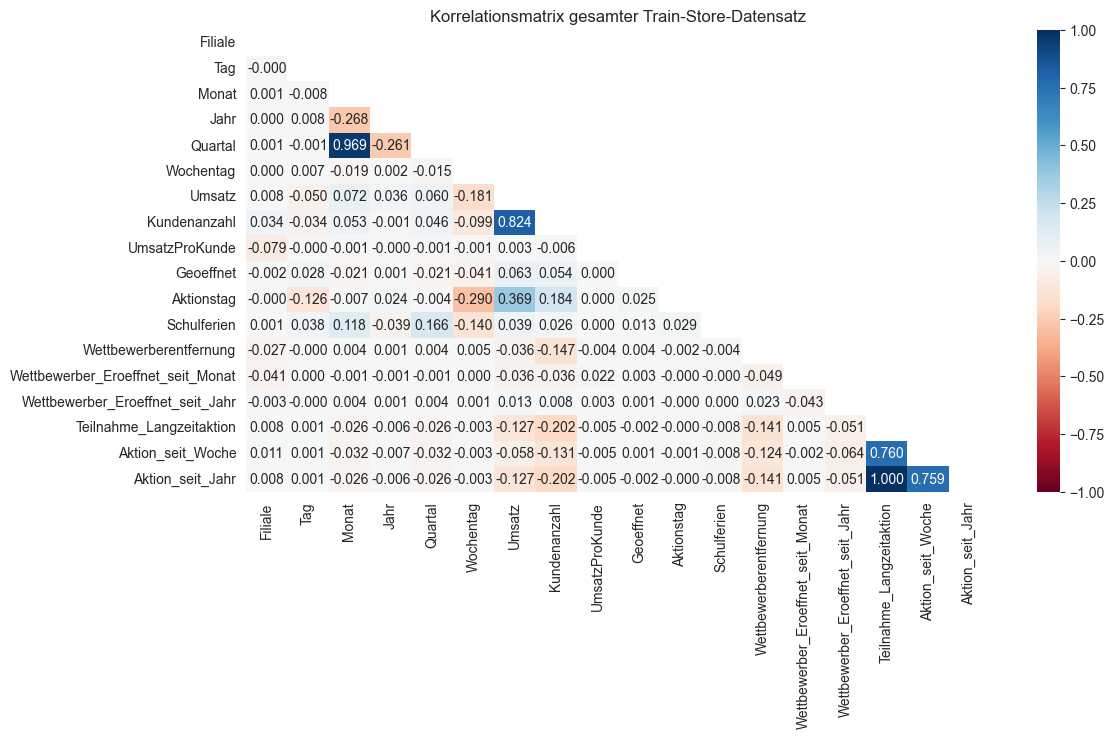

In [282]:
# Spalten mit numerischen Werten (Strings und kategorische Werte ausgeschlossen)
train_x_store_only_nr = train_x_store.select_dtypes(include=['number'])

# Korrelationsmatrix nach Pearson-Verfahren erstellen
corr_matrix_all = train_x_store_only_nr.corr("pearson")
display(corr_matrix_all.head())

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix_all, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(12,6))
plot = sns.heatmap(corr_matrix_all, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Korrelationsmatrix gesamter Train-Store-Datensatz")
plt.show()

#### Korrelationsmatrix einer zufälligen Filiale des Train-Store-Datensatzes

In [283]:
# Eine Filiale zufällig wählen
store_id = store["Filiale"].sample(n=1).values[0]

# Den Datensatz auf die zuvor festgelegte Filiale filtern
sample = train_x_store[train_x_store["Filiale"]==store_id].copy()

# Spalten mit numerischen Werten (Strings und kategorische Werte ausgeschlossen)
sample_only_nr = sample.select_dtypes(include=['number'])

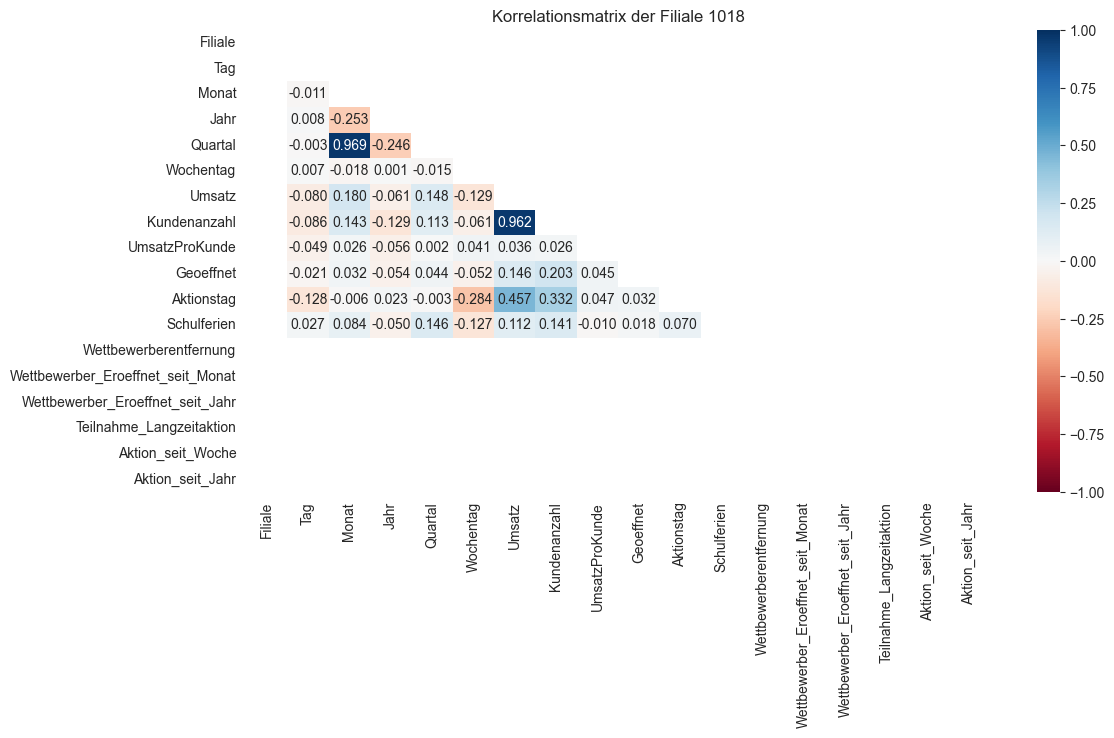

In [284]:
# Korrelationsmatrix nach Pearson-Verfahren erstellen
corr_matrix_sample = sample_only_nr.corr("pearson")

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix_sample, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(12,6))
plot = sns.heatmap(corr_matrix_sample, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title(f"Korrelationsmatrix der Filiale {store_id}")
plt.show()

Die Korrelationsmatrix weist einen großen weißen Bereich mit NaN-Werten auf, da diese Spalten konstante Werte enthalten. In solchen Fällen ist die Standardabweichung gleich null, was zur Folge hat, dass die Berechnung der Korrelation nicht möglich ist.

#### Korrelationsmatritzen miteinander vergleichen

- Positive Werte zeigen an, dass der Korrelationskoeffizient in der ersten Matrix größer ist als in der zweiten Matrix.
- Negative Werte zeigen an, dass der Korrelationskoeffizient in der zweiten Matrix größer ist als in der ersten Matrix.
- Ein Wert von Null in der Differenzmatrix bedeutet, dass sich die Korrelationskoeffizienten zwischen den beiden Matrizen nicht unterscheiden, d.h., die Korrelationen sind für diese Variablenpaare gleich.

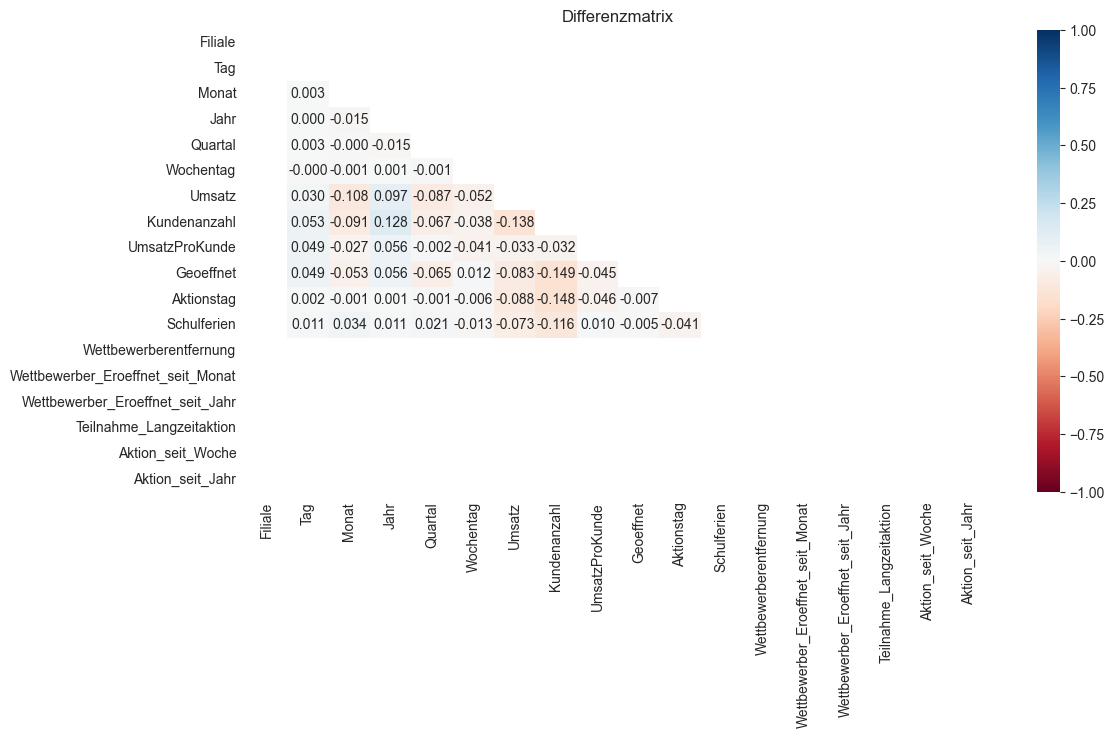

In [285]:
# Differenz der beiden Korrelationsmatritzen nach Pearson-Verfahren erstellen
diff_matrix = corr_matrix_all - corr_matrix_sample

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(diff_matrix, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(12,6))
plot = sns.heatmap(diff_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Differenzmatrix")
plt.show()


## Geeignete Merkmale <a id="4"></a> <br>

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

1. Umsatz je Kunde

In [286]:
# 1. Umsatz je Kunde
example = train_x_store_after.copy()
example["UmsatzProKunde"] = example["Umsatz"] / example["Kundenanzahl"]

display(example["UmsatzProKunde"])


KeyError: 'Umsatz'

2. Wettbewerberentfernung

Beispielsweise durch Bildung von Klassen [0, <250, <500 ...] oder Verwendung der nummerischen Werte (IST Zustand)

3. Umsatz 

4. Kundenanzahl

5. Flilialtyp

6. Sortiment

7. Feiertag

8. Schulferien

9. Datum (Wochentag, Tag im Monat, Tag im Jahr...)



## Vergleichsmetrik <a id="5"></a> <br>

Wir werden den RMSPE als Vergleichsmetrik nutzen. <br>

**Vorteile des RMSPE:**

* Skalenunabhängigkeit:<br>
        Prozentuale Fehlerbewertung: RMSPE bewertet die Fehler in prozentualen Einheiten. Dies bedeutet, dass die Metrik unabhängig von der Größenordnung der Umsätze ist. Dies ist besonders nützlich, wenn Umsätze in verschiedenen Bereichen oder Zeiträumen verglichen werden sollen, da es eine einheitliche Basis für die Bewertung bietet.

* Berücksichtigung großer Fehler:<br>
        Empfindlichkeit gegenüber Ausreißern: Durch die Quadrierung der Fehler ist RMSPE besonders empfindlich gegenüber großen Fehlern. Dies ist von Vorteil, wenn große Abweichungen in den Umsatzprognosen vermieden werden sollen, da solche Abweichungen potenziell erhebliche finanzielle Auswirkungen haben können.

* Vergleichbarkeit:<br>
        Standardisierte Metrik: RMSPE ermöglicht den Vergleich der Vorhersagegenauigkeit verschiedener Modelle oder Algorithmen auf einer standardisierten Grundlage. Dies erleichtert die Auswahl des besten Modells für die Umsatzprognose.

**Nachteile des RMSPE:**

* Empfindlichkeit gegenüber Ausreißern:<br>
        Überbetonung großer Fehler: Die Quadrierung der Fehler bedeutet, dass sehr große Abweichungen unverhältnismäßig stark gewichtet werden. In einigen Fällen kann dies zu einer verzerrten Einschätzung der Modellleistung führen, insbesondere wenn wenige Ausreißer die Metrik dominieren.

* Komplexität der Interpretation:<br>
        Schwierige Interpretation: Im Vergleich zu einfacheren Metriken wie dem Mean Absolute Error (MAE) kann die Interpretation der quadratischen und prozentualen Fehler für Stakeholder weniger intuitiv sein. Dies kann die Kommunikation der Modellleistung an nicht-technische Entscheidungsträger erschweren.

* Probleme bei kleinen tatsächlichen Werten:<br>
        Division durch kleine Werte: Wenn die tatsächlichen Umsatzwerte sehr klein sind, können die prozentualen Fehler und somit der RMSPE sehr groß werden. Dies kann zu instabilen und irreführenden Ergebnissen führen.

Zwei der genannten Nachteile sind für uns nicht relevant: Zum einen sind unsere Stakeholder unserer Meinung nach in der Lage, die Metrik zu interpretieren, und zum anderen werden wir, wie in der ursprünglichen Challenge, Nullwerte des Umsatzes beim Scoring ignorieren.

## Validierungsdatensatz

Wir benötigen zum messen und vergleichen der Performance einen Validierungsdatensatz, worin auch Umsätze enthalten sind. Den in Kaggle hinterlegten Testdatensatz benutzen wir dann für die finale Vorhersage mit den trainierten Machine Learning Modellen.

Hierfür entnehmen wir dem Trainingsdatensatz einen Anteil, der genau so groß ist wie der Testdatensatz aus Kaggle in Tagen.

Um den Code schlank zu halten, werden die neuen Datensätze ab hier "train" und validation" genannt.

In [287]:
# Datensatz nach Datum aufsteigend sortieren
test_sortiert = test_x_store.sort_values(by=["Datum"], ascending=True).reset_index(drop = True)

# Differenz in Tagen
erstes_datum = test_sortiert.iloc[1]["Datum"]
letztes_datum = test_sortiert.iloc[-1]["Datum"]
diff = letztes_datum - erstes_datum

print("Der Anzahl an Tagen zwischen {0} und {1} beträgt {2}.".format(erstes_datum, letztes_datum, diff.days))

Der Anzahl an Tagen zwischen 2015-08-01 00:00:00 und 2015-09-17 00:00:00 beträgt 47.


In [288]:
# Datensatz nach Datum aufsteigend sortieren
train_sortiert = train_x_store.sort_values(by=["Datum"], ascending=True).reset_index(drop = True)

# Index vom letzten Tag in test minus die Differenz
letztes_datum = train_sortiert.iloc[-1]["Datum"]
split_datum = letztes_datum - timedelta(days=diff.days)

print("Der letzte Tag im Trainingsdatensatz ist der {0}, minus {1} Tage ergibt den {2}".format(letztes_datum, diff.days, split_datum))

Der letzte Tag im Trainingsdatensatz ist der 2015-07-31 00:00:00, minus 47 Tage ergibt den 2015-06-14 00:00:00


In [289]:
# Datensatz trennen
train = train_sortiert.loc[train_sortiert.Datum <= split_datum]
validation = train_sortiert.loc[train_sortiert.Datum > split_datum]

In [290]:
train_len = len(train.index)
validation_len = len(validation.index)

print("Der Datensatz train_x_store hat {0} Zeilen und die Datensätze train und validation zusammen {1} Zeilen.".format(len(train_x_store.index), train_len+validation_len))
print("train: {0} Zeilen, validation: {1} Zeilen".format(train_len, validation_len) )

Der Datensatz train_x_store hat 845010 Zeilen und die Datensätze train und validation zusammen 845010 Zeilen.
train: 799150 Zeilen, validation: 45860 Zeilen


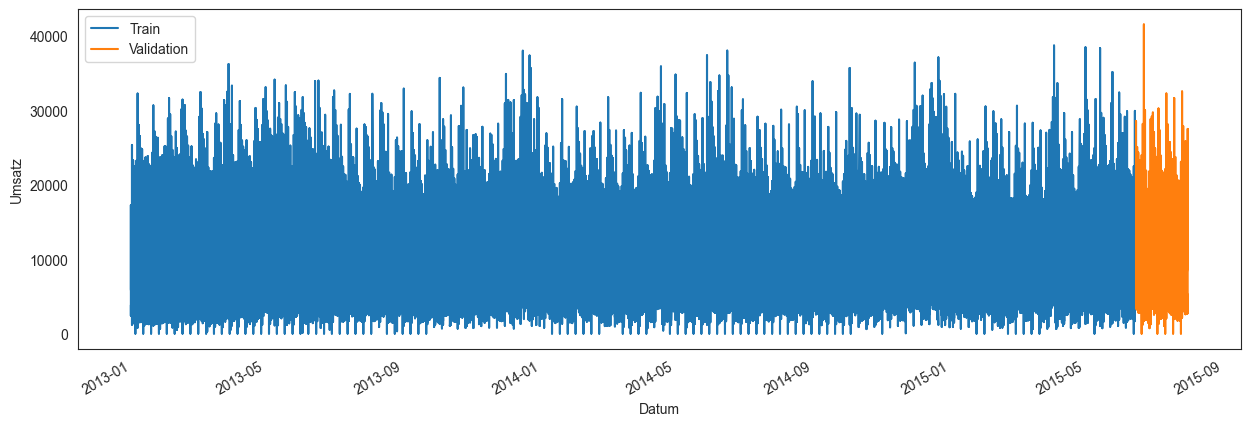

In [291]:
# Plot
fig, ax = plt.subplots(figsize=(15,5))
train.plot(x="Datum", y="Umsatz", ax=ax, label="Train")
validation.plot(x="Datum", y="Umsatz", ax=ax, label="Validation")
ax.set_xlabel("Datum")
ax.set_ylabel("Umsatz")
plt.show()

## Machine Learning Verfahren 1 - SARIMAX<a id="6"></a> <br>

In [21]:
# Notiz von Alice an Niklas: zum weiterarbeiten mit deinem ML-Verfahren:
train_sarimax = train.copy()
test_sarimax = validation.copy()

SARIMAX steht für Seasonal Autoregressive Integrated Moving Average + exogenous variables

In [ ]:
display(train_sarimax.head())
display(test_sarimax.head())

In [23]:
# Zufällige Auswahl treffen
sampled_values = []

# Alle einzigartigen Werte in der Spalte Sortiment ermitteln
unique_sortiments = train_sarimax['Sortiment'].unique()

# Für jeden Wert im Sortiment eine zufällige Filiale auswählen
for sortiment in unique_sortiments:
    filialen = train_sarimax[train_sarimax['Sortiment'] == sortiment]['Filiale'].tolist()
    sampled_values.append(random.choice(filialen))

# Alle einzigartigen Werte in der Spalte Filialentyp ermitteln
unique_filialentypen = train_sarimax['Filialentyp'].unique()

# Für jeden Wert im Sortiment eine zufällige Filiale auswählen
for filialentyp in unique_filialentypen:
    filialen = train_sarimax[train_sarimax['Filialentyp'] == filialentyp]['Filiale'].tolist()
    sampled_values.append(random.choice(filialen))

# Zusätzliche Zufallswerte aus der Spalte Filiale auswählen, um insgesamt 20 Werte zu erhalten
remaining_values = random.sample(train_sarimax['Filiale'].tolist(), 20 - len(sampled_values))
sampled_values.extend(remaining_values)

# # Eine Filiale zufällig wählen
# store_ids = train_sarimax["Filiale"].sample(n=10).values

train_sample_stores = train_sarimax[train_sarimax["Filiale"].isin(sampled_values)]
train_sample_stores.reset_index(inplace=True)
# train_sample_stores.set_index("Datum", drop = True, inplace=True)
test_sample_stores = test_sarimax[test_sarimax["Filiale"].isin(sampled_values)]
test_sample_stores.reset_index(inplace=True)
# test_sample_stores.set_index("Datum", drop = True, inplace=True)

In [24]:
exog_sarimax = pd.get_dummies(train_sample_stores[["Wochentag", "Filialentyp", "Sortiment", "Feiertag", "Datum"]])

In [25]:
exog_sarimax = exog_sarimax.apply(pd.to_numeric, errors = "coerce")
exog_sarimax = exog_sarimax.astype("int64")

In [ ]:


# Auto-ARIMA Modell mit wöchentlicher Saisonalität
sarimax_model = pm.auto_arima(train_sample_stores['Umsatz'],
                           exogenous=exog_sarimax, # SARIMAX
                           start_p=2, start_q=2,
                           max_p=5, max_q=5,
                           start_P=1,
                           seasonal=True,  # SARIMA
                           m=52,  # Wöchentliche Saisonalität (1: jährlich, 4: quartalweise, 52: wöchentlich)
                           stepwise=True,  # Effiziente Suche
                           trace=True)  # Zeige den Fortschritt



(5, 1, 1) (1, 0, 0) [52] hat am besten performt

In [ ]:
print(sarimax_model)
print(sarimax_model.order)
print(sarimax_model.seasonal_order)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(train_sample_stores["Umsatz"],
                        order = (2, 1, 2),# sarimax_model.order,
                        seasonal_order= (1, 0, 0, 52), # sarimax_model.seasonal_order,
                        exog = exog_sarimax,
                        enforce_stationarity=True, 
                        enforce_invertibility=False)

results_sarimax = sarimax_model.fit()
print(results_sarimax.summary())

In [86]:
# results_sarimax.save("sarimax")

In [87]:
# results_sarimax.plot_diagnostics(figsize=(15, 8))
# plt.show()

In [ ]:
# Eine Filiale zufällig wählen
store_id = train_sarimax["Filiale"].sample(n=1).values[0]

train_sample_store = train_sarimax[train_sarimax["Filiale"] == store_id]
train_sample_store.set_index("Datum", inplace = True, drop= True)
test_sample_store = test_sarimax[test_sarimax["Filiale"] == store_id][:56]
# test_sample_store.set_index("Datum", inplace = True, drop= True)
test_sample_store.reset_index(inplace= True)

# display(test_sample_store)

test_exog_sarimax = pd.get_dummies(test_sample_store[["Wochentag", "Filialentyp", "Sortiment", "Feiertag", "Datum"]])
test_exog_sarimax = test_exog_sarimax.apply(pd.to_numeric, errors = "coerce")
test_exog_sarimax = test_exog_sarimax.astype("int64")

# Finden der fehlenden Spalten in df1, die in df2 vorhanden sind
missing_columns = [col for col in exog_sarimax.columns if col not in test_exog_sarimax.columns]

# Hinzufügen der fehlenden Spalten zu df1 und initialisieren mit 0
for col in missing_columns:
    test_exog_sarimax[col] = 0
# display(test_exog_sarimax)


# Auszukommentieren beim Einsatz von statsmodel Sarimax anstatt auto_arima
forecast = results_sarimax.get_forecast(steps=len(test_exog_sarimax), exog=test_exog_sarimax)
forecast_mean = forecast.predicted_mean

# display(forecast.predicted_mean)

# predictions = sarimax_model.predict(n_periods=len(test_sample_store), exogenous=test_exog_sarimax)
# print(predictions)

plt.figure(figsize=(14, 6))
plt.plot(train_sample_store.index[-30:], train_sample_store['Umsatz'][-30:], label='Historischer Umsatz')
plt.plot(test_sample_store["Datum"], test_sample_store['Umsatz'], label='tatsächlicher Umsatz', linestyle = ":")
plt.plot(test_sample_store["Datum"], forecast_mean, label='Prognostizierter Umsatz', linestyle='--')
plt.title('Umsatzprognose mittels SARIMAX')
plt.xlabel('Datum')
plt.ylabel('Umsatz')
plt.legend()
plt.show()

### Abspeichern der Umsatzzahlen in eine externe Datei

In [ ]:
sample_store_ids = list(range(1, 201))

validation_sample = validation[validation["Filiale"].isin(sample_store_ids)]

In [ ]:
sarimax_predictions = pd.DataFrame(columns= ["Datum", "Filiale", "y_true", "y_pred", "rmspe"])
gp_validation_sample = validation_sample.groupby(by = "Filiale")

for store_id, store_validation_data in gp_validation_sample:
    # print(store_validation_data)
    validation_exog = pd.get_dummies(store_validation_data[["Wochentag", "Filialentyp", "Sortiment", "Feiertag", "Datum"]])
    validation_exog = validation_exog.apply(pd.to_numeric, errors = "coerce")
    validation_exog = validation_exog.astype("int64")

    # Finden der fehlenden Spalten in df1, die in df2 vorhanden sind
    missing_columns = [col for col in exog_sarimax.columns if col not in validation_exog.columns]

    # Hinzufügen der fehlenden Spalten zu df1 und initialisieren mit 0
    for col in missing_columns:
        validation_exog[col] = 0
    
    forecast = results_sarimax.get_forecast(steps=len(validation_exog), exog=validation_exog)
    forecast_mean = forecast.predicted_mean 
    # print(type(forecast_mean))

    store_results = pd.DataFrame(columns= ["Datum", "Filiale", "y_true", "y_pred", "rmspe"])

    store_results["Datum"] = store_validation_data["Datum"]
    store_results["Filiale"] = store_validation_data["Filiale"]
    store_results["y_true"] = store_validation_data["Umsatz"]
    store_results["y_pred"] = forecast_mean.values
    store_results["rmspe"] = np.sqrt(np.square(((store_results["y_true"] - store_results["y_pred"])/store_results["y_true"])))


    sarimax_predictions = pd.concat([sarimax_predictions, store_results])

display(sarimax_predictions)

In [ ]:
sarimax_predictions.to_csv("sarimax_results.csv")

## Machine Learning Verfahren 2 - Prophet <a id="7"></a> <br>

In diesem Kapitel werden wir den Umsatz der Filialen 1 bis 200 für 48 Tage vorhersagen. Die Ergebnisse werden mit den Umsätzen aus dem Validierungsdatensatz verglichen und im nächsten Kapitel auch mit den Vorhersagen aus dem SARIMAX-Verfahren. In beiden Fällen wird der RSMPE, wie auf [Kaggle](https://www.kaggle.com/c/rossmann-store-sales#evaluation) definiert, verwendet.

Als Grundlage wurde vorallem mit der [Prophet Dokumentation](https://facebook.github.io/prophet/docs/quick_start.html) gearbeitet. Prophet erwartet als Eingabe immer einen Datensatz mit den Spalte ds (Datum) und y (Umsatz). Das Datumsformat muss in YYYY-MM-DD Format vorliegen und die zweite Spalte muss numerisch sein.

Prophet bietet bereits vordefinierte gesetzliche Feiertage, welche auf [GitHub](https://github.com/vacanza/python-holidays/) zu finden sind. Um selbst Feiertage hinzuzufügen, benötigen wir einen separaten Datensatz mit den Spalten "Feiertag" und "ds". In dem Datensatz müssen alle vergangenen und zukünftigen Feiertage für die Vorhersage vorhanden sein.

Für Deutschland sind im Package bereits folgende Feiertage enthalten:

- Neujahr
- Karfreitag
- Ostermontag
- Tag der Arbeit
- Christi Himmelfahrt
- Pfingstmontag
- Tag der deutschen Einheit
- Erster Weihnachtstag
- Zweiter Weihnachtstag

In [301]:
# Kopie der Datensätze ziehen
train_prophet = train
validation_prophet = validation

# Leeres Dataframe vor der Berechnung erstellen
performance_vergleichen = pd.DataFrame(data=[])

Die folgende Funktion dient zum berechnen der Vorhersagen und Performance, sowie dem ablegen aller Umsatzzahlen für den späteren Vergleich.

In [302]:
def vorhersage_prophet(filialennr, anzahl_vorhersagetage, output_anzeigen):

    train_df = train_prophet[train_prophet.Filiale==filialennr][["Datum", "Umsatz"]]        # Datensatz nach Filiale filtern
    train_df = train_df.sort_values(by=["Datum"], ascending=True).reset_index(drop = True)  # Datensatz aufsteigend sortieren
    train_df = train_df.rename(columns = {"Datum": "ds", "Umsatz": "y"})                    # Spalten umbennenen

    model = Prophet(interval_width = 0.95)                                      # Modell mit 95% Konfidenzintervall erstellen
    model.add_country_holidays(country_name='DE')                               # Feiertage in Deutschland hinzufügen
    model.fit(train_df)                                                         # Modell mit den Daten anreichern                                                              
    future = model.make_future_dataframe(periods=anzahl_vorhersagetage)         # Tage die vorhergesagt werden sollen hinzufügen
    vorhersage = model.predict(future)                                          # Vorhersagen erstellen
    vorhersage_df = vorhersage[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]      # Vorhersagedatensatz speichern

    # Output/Plots
    if output_anzeigen==True:
        display(vorhersage_df)
        figure1 = model.plot(vorhersage, xlabel = 'Data', ylabel = 'Vendas')
        figure2 = model.plot_components(vorhersage)

    # Wahre und vorhergesagte Umsätze mergen
    performance_merge = vorhersage_df[["ds", "yhat"]].merge(train_x_store[train_x_store.Filiale==filialennr][["Datum", "Umsatz"]],
                                                            left_on='ds', right_on='Datum', how="left")

    # Performance zum vergleichen ablegen
    performance_vergleich = pd.DataFrame(data = {"Datum": performance_merge["ds"],
                                                 "Filiale": filialennr,
                                                 "y_true": performance_merge["Umsatz"],
                                                 "y_pred_alice": performance_merge["yhat"]
                                                 })
    # RSMPE Performance pro Zeile berechnen
    # wurzel [ ((yi-yhat)/yi )^2 ]
    performance_vergleich["rsmpe_alice"] = np.sqrt(np.square(((performance_vergleich["y_true"] - performance_vergleich["y_pred_alice"])/performance_vergleich["y_true"])))

    
    return vorhersage, performance_vergleich

Nun wird die eben definierte Funktion für 200 Filialen aufgerufen und die Ergebnisse werden im Dataframe performance_vergleichen abgelegt.

In [303]:
for i in range(1, 201):
    vorhersage, performance_vergleich = vorhersage_prophet(filialennr=i, anzahl_vorhersagetage=48, output_anzeigen=False)
    performance_vergleichen = pd.concat([performance_vergleichen, performance_vergleich], ignore_index=True)

12:40:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:59 - cmdstanpy - INFO - Chain [1] done processing
12:40:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:59 - cmdstanpy - INFO - Chain [1] done processing
12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:00 - cmdstanpy - INFO - Chain [1] done processing
12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:00 - cmdstanpy - INFO - Chain [1] done processing
12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:00 - cmdstanpy - INFO - Chain [1] done processing
12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing
12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing
12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1]

In [304]:
performance_vergleichen

Datum  Filiale   y_true  y_pred_alice  rsmpe_alice
0      2013-01-02        1   5530.0   5566.254608     0.006556
1      2013-01-03        1   4327.0   5328.985454     0.231566
2      2013-01-04        1   4486.0   5483.088355     0.222267
3      2013-01-05        1   4997.0   5582.464098     0.117163
4      2013-01-07        1   7176.0   5589.686814     0.221058
...           ...      ...      ...           ...          ...
151245 2015-07-27      200   8241.0   9028.189458     0.095521
151246 2015-07-28      200   7465.0   8347.399703     0.118205
151247 2015-07-29      200   7013.0   7921.757210     0.129582
151248 2015-07-30      200   7103.0   7714.337462     0.086068
151249 2015-07-31      200  11177.0   8212.094644     0.265268

[151250 rows x 5 columns]

## Vergleich der Machine Learning Verfahren <a id="8"></a> <br>